In [1]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from pathlib import Path
from data_preparation import load_and_preprocess_data, load_data_splits
import logging
from xgboost_utils import save_pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def split_data_by_groups(X, y, groups, test_size=0.2, random_state=42):
    """
    Split data ensuring all samples from the same group stay together.
    
    Args:
        X: Features DataFrame
        y: Target Series
        groups: Group labels (raceId)
        test_size: Proportion of data to use for testing
        random_state: Random state for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(X, y, groups=groups))
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

def main():
    # Load and preprocess data
    logging.info("Loading and preprocessing data...")
    df = load_and_preprocess_data()
    logging.info(f"Data loaded with shape: {df.shape}")
    
    # Ensure raceId is in the DataFrame
    if 'raceId' not in df.columns:
        raise ValueError("raceId column is required for group-based splitting")
    
    # Prepare features and target
    X = df.drop(columns=["milliseconds", "raceId"])
    y = df["milliseconds"]
    groups = df["raceId"]
    logging.info(f"Features and target prepared. X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data using group-based splitting
    X_train, X_test, y_train, y_test = split_data_by_groups(
        X, y, groups=groups, test_size=0.2, random_state=42
    )
    logging.info(f"Data split into train and test sets.")
    logging.info(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    
    # Define categorical and numerical features
    categorical_features = ["code", "nationality", "status", "circuit_type", "country", 'constructor_nationality']
    numerical_features = [col for col in X.columns if col not in categorical_features]
    logging.info(f"Categorical features: {categorical_features}")
    logging.info(f"Numerical features: {numerical_features}")
    
    # Create preprocessing pipeline including ColumnTransformer and PCA
    preprocessor = Pipeline(steps=[
        ('transformer', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )),
        ('pca', PCA(n_components=100, random_state=42))
    ])
    
    # Create the full pipeline with preprocessor and XGBoost regressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train the pipeline
    logging.info("Training XGBoost pipeline...")
    pipeline.fit(X_train, y_train)
    logging.info("Training completed.")
    
    # Save the entire pipeline
    model_path = "models/xgboost_pipeline.pkl"
    save_pipeline(pipeline, model_path)
    logging.info(f"XGBoost pipeline saved to {model_path}")
    
    # Model performance
    logging.info("Evaluating model performance on test set...")
    y_pred = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    logging.info(f"Test RMSE: {rmse:.2f}")
    logging.info(f"Test MAE: {mae:.2f}")
    logging.info(f"Test R²: {r2:.4f}")

if __name__ == "__main__":
    main()

INFO:root:Loading and preprocessing data...


/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'racetime_milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')



Initial data sizes:
Lap times: (586171, 6)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



After initial merge: (586171, 46) - All lap data merged
After year filtering (>=2018): (159538, 46)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




After adding constructor info: (159538, 52)
After adding circuit info: (159538, 55)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFr

After adding weather info: (159538, 60)

Fetching weather for 92 races: [989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1069, 1070, 1071, 1072, 1073, 1096, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129]
No weather data available for race 992
No weather data available for race 1005
No weather data available for race 1013
No weather data available for race 1023
No weather data available for race 1026
No weather data available for race 1038
No weather data available for race 1057


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

After adding tire info: (159538, 65)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

After adding practice info: (159538, 70)
After cleaning time intervals: (159538, 70)
Calculating enhanced driver metrics...


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

After enhancing driver attributes: (159538, 77)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




After adding dynamic features: (159538, 81)

Calculating race intervals...
After calculating race intervals: (159538, 81)

Before outlier removal:

Before outlier removal:
Unique races: 146
Unique drivers per race: count    146.000000
mean      19.500000
std        0.888625
min       16.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       20.000000
Name: driverId, dtype: float64

After removing outliers: (139755, 81)
Special laps removed: (2648, 81)
After dropping unnecessary columns: (139755, 49)

Removed Columns:
[]
After removing duplicate columns: (139755, 49)

Before handling missing values:
Unique races: 145
Unique drivers per race: count    145.000000
mean      19.234483
std        1.462560
min        8.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       20.000000
Name: driverId, dtype: float64

Initial shape: (139755, 49)
Initial unique races: 145
Initial unique drivers: 39

Columns with missing values:

Column: driver_aggression

INFO:root:Data loaded with shape: (137448, 49)
INFO:root:Features and target prepared. X shape: (137448, 47), y shape: (137448,)
INFO:root:Data split into train and test sets.
INFO:root:X_train shape: (109354, 47), X_test shape: (28094, 47)
INFO:root:Categorical features: ['code', 'nationality', 'status', 'circuit_type', 'country', 'constructor_nationality']
INFO:root:Numerical features: ['driverId', 'lap', 'position', 'year', 'round', 'circuitId', 'lat', 'lng', 'alt', 'positionOrder', 'grid', 'pitstop_milliseconds', 'constructorId', 'constructor_position', 'constructor_performance', 'circuit_length', 'circuit_type_encoded', 'cumulative_milliseconds', 'seconds_from_start', 'TrackTemp', 'AirTemp', 'Humidity', 'TrackStatus', 'GapToLeader_ms', 'IntervalToPositionAhead_ms', 'tire_compound', 'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time', 'driver_overall_skill', 'driver_circuit_skill', 'driver_consistency', 'driver_aggression', 'driver_adaptability', 'driver_reliabili


Final dataset: (137448, 49)


INFO:root:Training completed.
INFO:root:Pipeline saved to models/xgboost_pipeline.pkl
INFO:root:XGBoost pipeline saved to models/xgboost_pipeline.pkl
INFO:root:Evaluating model performance on test set...
INFO:root:Test RMSE: 4294.50
INFO:root:Test MAE: 3044.28
INFO:root:Test R²: 0.8490


INFO:root:Pipeline loaded from models/xgboost_pipeline.pkl
INFO:root:Pipeline loaded from models/xgboost_pipeline.pkl
INFO:root:All data files loaded successfully.
INFO:root:Numerical features: ['driverId', 'lap', 'position', 'year', 'round', 'circuitId', 'lat', 'lng', 'alt', 'positionOrder', 'grid', 'pitstop_milliseconds', 'constructorId', 'constructor_position', 'constructor_performance', 'circuit_length', 'circuit_type_encoded', 'cumulative_milliseconds', 'seconds_from_start', 'TrackTemp', 'AirTemp', 'Humidity', 'TrackStatus', 'GapToLeader_ms', 'IntervalToPositionAhead_ms', 'tire_compound', 'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time', 'driver_overall_skill', 'driver_circuit_skill', 'driver_consistency', 'driver_aggression', 'driver_adaptability', 'driver_reliability', 'driver_risk_taking', 'tire_age', 'fuel_load', 'track_position', 'is_pit_lap']
INFO:root:Categorical features: ['code', 'nationality', 'status', 'circuit_type', 'country', 'constructor_nationa

      Lap      Driver       LapTime  Position  static_raceId  static_driverId  \
781     1  Driver 844  90217.992188         1           1126              844   
852     1  Driver 846  90223.937500         2           1126              846   
1136    1  Driver 853  94904.296875         3           1051              853   
142     1    Driver 4  96734.312500         4           1119                4   
994     1  Driver 849  96812.390625         5           1078              849   

      static_lap  static_position  static_milliseconds static_code  ...  \
781           57                3                91629         LEC  ...   
852           57                1                91575         NOR  ...   
1136          55               18                87340         MAZ  ...   
142           50                9                96966         ALO  ...   
994           57               14                95588         LAT  ...   

     static_is_pit_lap  dynamic_tire_age  dynamic_fuel_load  \

INFO:root:Race positions plot saved to race_positions_plot.png


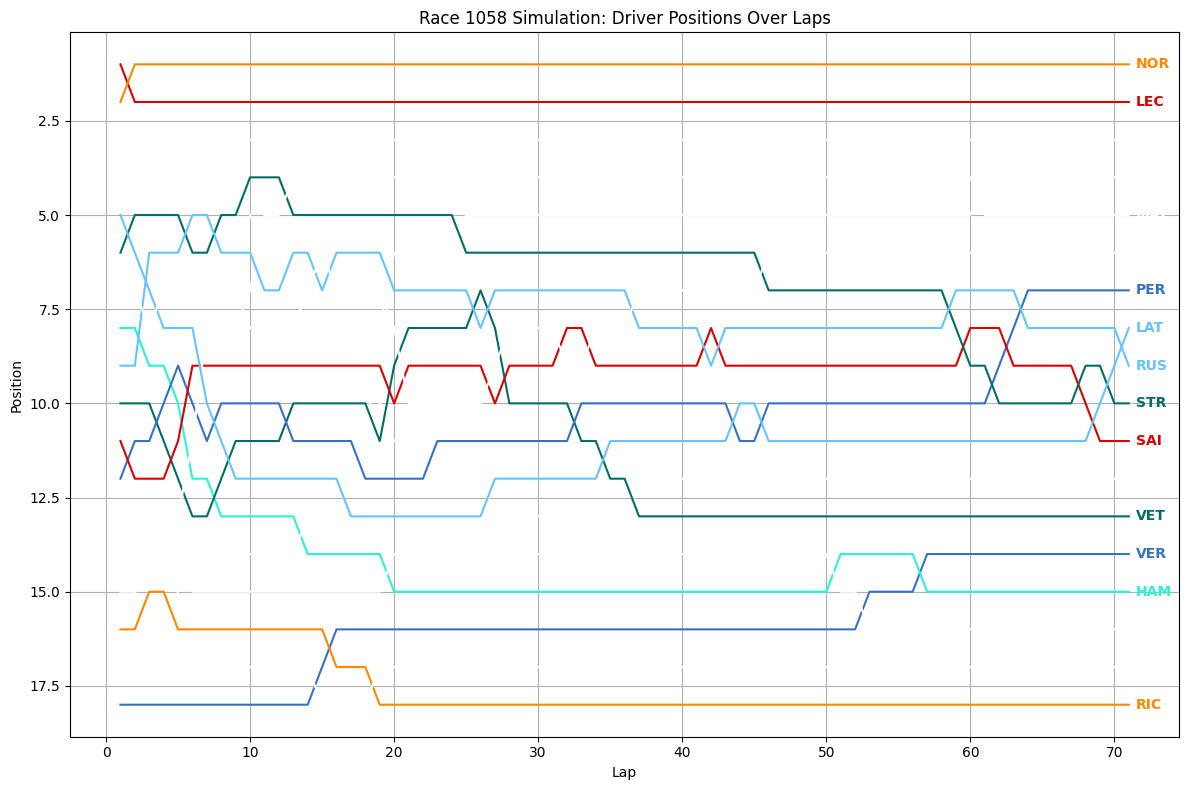

INFO:root:Lap times plot saved to driver_lap_times_plot.png


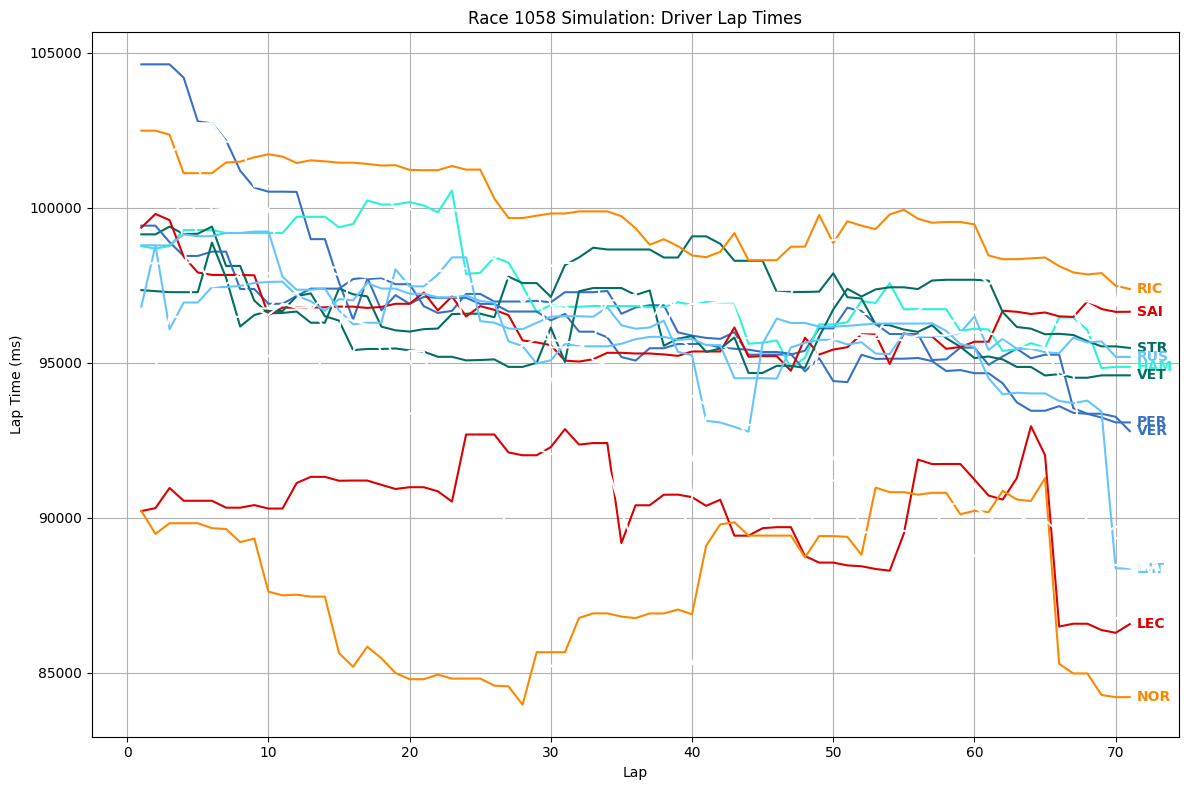

In [2]:
# simulation_with_pit_and_safety_car_strategy.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from typing import List, Tuple, Dict
from race_simulator_xgboost import (
    Race, Driver, RaceSimulator, plot_race_positions, plot_lap_times, create_lap_times_with_inputs_dataframe
)
from sim_utils import extract_pit_strategies, extract_safety_car_periods  # Ensure this is accessible
from xgboost_utils import load_pipeline
import pickle
#plt.style.use('dark_background')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the trained pipeline with exception handling
model_path = 'models/xgboost_pipeline.pkl'
try:
    pipeline = load_pipeline(model_path)
    logging.info(f"Pipeline loaded from {model_path}")
except FileNotFoundError:
    logging.error(f"Model file not found at {model_path}")
    raise
except Exception as e:
    logging.error(f"An error occurred while loading the pipeline: {e}")
    raise

# Function to get race length (you can adjust this based on your data)
def get_race_length(race_id: int, lap_times_df: pd.DataFrame) -> int:
    """
    Get the actual race length for a given race ID from historical data.
    """
    race_laps = lap_times_df[lap_times_df['raceId'] == race_id]['lap'].max()
    if pd.isna(race_laps):
        logging.warning(f"No race data found for raceId {race_id}. Using default race length of 50 laps.")
        return 50
    return int(race_laps)

# Load necessary data with proper handling
try:
    lap_times = pd.read_csv('data/LAPS.csv', na_values=['\\N', 'NaN', ''])
    special_laps = pd.read_csv('data/SPECIAL_LAPS.csv', na_values=['\\N', 'NaN', ''])
    constructors = pd.read_csv('../data/raw_data/constructors.csv', na_values=['\\N', 'NaN', ''])
    drivers_df = pd.read_csv('data/util/drivers_attributes.csv')
    logging.info("All data files loaded successfully.")
except FileNotFoundError as e:
    logging.error(f"Data file not found: {e}")
    raise
except Exception as e:
    logging.error(f"An error occurred while loading data files: {e}")
    raise

race_id = 1058  # Replace with your actual race ID
race_length = get_race_length(race_id, lap_times)  # Use your actual race ID

safety_car_periods = extract_safety_car_periods(special_laps, race_id)

# Create an instance of the Race with actual length and safety car periods
race = Race(
    race_id=race_id,
    circuit_id=70,  # Replace with actual circuit ID
    total_laps=race_length,
    weather_conditions={},  # Add actual weather data if available
    safety_car_periods=safety_car_periods  # Extracted safety car periods
)

# Define categorical and numerical features (must match training)
# Extract numerical and categorical feature names from the pipeline's preprocessor
preprocessor = pipeline.named_steps['preprocessor']
transformers = preprocessor.named_steps['transformer'].transformers_

# Extract numerical and categorical feature names
numerical_features = []
categorical_features = []
for name, transformer, features in transformers:
    if name == 'num':
        numerical_features.extend(features)
    elif name == 'cat':
        categorical_features.extend(features)

logging.info(f"Numerical features: {numerical_features}")
logging.info(f"Categorical features: {categorical_features}")

def initialize_drivers(drivers_df: pd.DataFrame, lap_times_df: pd.DataFrame, special_laps: pd.DataFrame, race: Race) -> Tuple[List[Driver], Dict, List[Tuple[int, int]]]:
    """
    Initializes drivers with their respective pit strategies and grid positions from historical data.

    Args:
        drivers_df (pd.DataFrame): DataFrame containing driver attributes.
        lap_times_df (pd.DataFrame): DataFrame containing lap data.
        special_laps (pd.DataFrame): DataFrame containing special lap information like pit stops and safety cars.
        race (Race): The race instance.

    Returns:
        Tuple[List[Driver], Dict, List[Tuple[int, int]]]: A tuple containing:
            - List of initialized Driver instances.
            - Pit strategies dictionary.
            - Safety car periods list.
    """
    drivers = []
    
    # Extract pit strategies
    pit_strategies = extract_pit_strategies(special_laps, race.race_id)
    
    # Filter driver attributes for the specific raceId
    drivers_race_df = drivers_df[drivers_df['raceId'] == race.race_id]
    
    if drivers_race_df.empty:
        raise ValueError(f"No drivers found for raceId {race.race_id}")
    
    # Get grid positions for this race
    grid_positions = lap_times_df[
        (lap_times_df['raceId'] == race.race_id) & 
        (lap_times_df['lap'] == 1)
    ][['driverId', 'grid']].drop_duplicates()
    
    # Create a grid position mapping
    grid_mapping = grid_positions.set_index('driverId')['grid'].to_dict()
    
    for idx, row in drivers_race_df.iterrows():
        driver_id = row['driverId']
        driver_name = row.get('driverName', f"Driver {driver_id}")
        
        # Get the actual grid position, default to back of grid if not found
        grid_position = grid_mapping.get(driver_id, len(drivers_race_df))
        
        # Load driver features from LAPS.csv
        driver_features_df = lap_times_df[lap_times_df['driverId'] == driver_id]
        
        if driver_features_df.empty:
            raise ValueError(f"No feature data found for driverId {driver_id}")
        
        # For simplicity, take the latest lap's features or aggregate as needed
        driver_features = driver_features_df.iloc[-1].to_dict()
        
        # Extract pit strategy for the driver
        pit_strategy_info = pit_strategies.get(driver_id, {})
        starting_compound = pit_strategy_info.get('starting_compound', 2)  # Default to medium compound if not found
        pit_strategy = pit_strategy_info.get('pit_strategy', [])
        
        # Update dynamic features based on simulation requirements
        dynamic_features = {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': grid_position,  # Use actual grid position instead of idx + 1
            'TrackTemp': 35.0,
            'AirTemp': 25.0,
            'Humidity': 50.0,
            'TrackStatus': 1,  # Default to normal conditions
            'is_pit_lap': 0,
            'tire_compound': starting_compound
        }
        
        # Combine static and dynamic features
        full_features = driver_features.copy()
        full_features.update(dynamic_features)
        
        # Ensure all necessary columns are present
        for col in numerical_features + categorical_features + ['raceId', 'driverId', 'lap']:
            if col not in full_features:
                if col in numerical_features:
                    full_features[col] = 0
                elif col in categorical_features:
                    full_features[col] = 'unknown'
                else:
                    full_features[col] = 1
        
        # Extract features needed for the pipeline
        driver_feature_values = {col: full_features[col] for col in numerical_features + categorical_features + ['raceId', 'driverId', 'lap']}
        driver_df = pd.DataFrame([driver_feature_values])
        
        # Create the Driver instance with actual grid position
        driver = Driver(
            driver_id=driver_id,
            name=driver_name,
            static_features=full_features,
            initial_dynamic_features=dynamic_features,
            start_position=grid_position,  # Use actual grid position
            pit_strategy=pit_strategy,
            starting_compound=starting_compound
        )
        
        drivers.append(driver)
    
    # Sort drivers by grid position to ensure correct initial ordering
    drivers.sort(key=lambda x: x.start_position)
    
    logging.info(f"Initialized {len(drivers)} drivers for raceId {race.race_id}")
    return drivers, pit_strategies, race.safety_car_periods

# Initialize drivers using the pipeline
drivers_list, pit_strategies, safety_car_periods = initialize_drivers(drivers_df, lap_times, special_laps, race)

# Add drivers to the race
race.drivers.extend(drivers_list)

# Initialize the RaceSimulator with the loaded pipeline
simulator = RaceSimulator(pipeline, model_type='xgboost')

# Simulate the race
race_lap_data = simulator.simulate_race(race)

# Create the DataFrame with inputs and predicted lap times
lap_times_df = create_lap_times_with_inputs_dataframe(race)

# Display the first few rows
print(lap_times_df.head())

# Optionally, save to a CSV for further analysis
lap_times_df.to_csv('race_simulation_results.csv', index=False)

# 1. Create Constructor Mapping
constructor_mapping = constructors.set_index('constructorId')['name'].to_dict()
constructor_mapping = {k: v.lower() for k, v in constructor_mapping.items()}  # Convert to lowercase

# 2. Create Driver Code Mapping
if 'code' in drivers_df.columns:
    driver_code_mapping = drivers_df.set_index('driverId')['code'].to_dict()
else:
    # Create 'code' based on forename and surname
    drivers_df['code'] = drivers_df['forename'].str[0].str.upper() + drivers_df['surname'].str[:2].str.upper()
    driver_code_mapping = drivers_df.set_index('driverId')['code'].to_dict()

# 3. Define TEAM_COLORS
TEAM_COLORS: dict[str, str] = {
    'alpine': '#fe86bc',
    'aston martin': '#006f62',
    'ferrari': '#dc0000',
    'haas': '#B6BABD',
    'mclaren': '#ff8700',
    'mercedes': '#27F4D2',
    'red bull': '#3671C6',
    'sauber': '#52E252',
    'williams': '#64C4FF',
    'rb' : '#6692FF'
}

# 4. Define get_constructor_color Function
def get_constructor_color(constructor_id):
    constructor_name = constructor_mapping.get(constructor_id, 'unknown').lower()
    if constructor_name == 'unknown':
        logging.warning(f"Constructor ID {constructor_id} not found. Using default color.")
    return TEAM_COLORS.get(constructor_name, '#000000')  # Default to white if not found

def plot_race_positions(race, drivers_df, constructor_mapping, driver_code_mapping, TEAM_COLORS, save_path=None):
    plt.figure(figsize=(12, 8))  # Made figure slightly taller to accommodate labels
    
    # Create a color cycle for drivers without constructor info
    default_colors = plt.cm.rainbow(np.linspace(0, 1, len(race.drivers)))
    color_idx = 0
    
    # Filter drivers_df for the specific race
    race_drivers_df = drivers_df[drivers_df['raceId'] == race.race_id]
    
    for driver in race.drivers:
        driver_id = driver.driver_id
        positions = race.lap_data[driver_id]['positions']
        
        # Get constructor ID from drivers_df for this specific race
        driver_info = race_drivers_df[race_drivers_df['driverId'] == driver_id]
        if not driver_info.empty and 'constructorId' in driver_info.columns:
            constructor_id = driver_info.iloc[0]['constructorId']
            color = get_constructor_color(constructor_id)
        else:
            logging.warning(f"No constructor info found for driver {driver_id} in race {race.race_id}")
            color = default_colors[color_idx]
            color_idx = (color_idx + 1) % len(default_colors)
            
        driver_code = driver_code_mapping.get(driver_id, f'D{driver_id}')
        
        # Plot the line without label
        line = plt.plot(range(1, len(positions) + 1), positions, color=color)[0]
        
        # Add driver code at the end of the line
        last_position = positions[-1]
        plt.annotate(
            driver_code,
            xy=(len(positions), last_position),
            xytext=(5, 0),
            textcoords='offset points',
            va='center',
            color=color,
            fontweight='bold'
        )
    
    plt.gca().invert_yaxis()  # Position 1 at top
    plt.xlabel('Lap')
    plt.ylabel('Position')
    plt.title(f'Race {race.race_id} Simulation: Driver Positions Over Laps')
    plt.grid(True)
    
    # Shade safety car periods
    if race.safety_car_periods:
        for start, end in race.safety_car_periods:
            plt.axvspan(start, end, color='yellow', alpha=0.3)
    
    # Adjust plot margins to ensure labels are visible
    plt.margins(x=0.05)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        logging.info(f"Race positions plot saved to {save_path}")
    
    plt.show()

def plot_lap_times(race, drivers_df, constructor_mapping, driver_code_mapping, TEAM_COLORS, save_path=None):
    plt.figure(figsize=(12, 8))  # Made figure slightly taller to accommodate labels
    
    # Create a color cycle for drivers without constructor info
    default_colors = plt.cm.rainbow(np.linspace(0, 1, len(race.drivers)))
    color_idx = 0
    
    # Filter drivers_df for the specific race
    race_drivers_df = drivers_df[drivers_df['raceId'] == race.race_id]
    
    for driver in race.drivers:
        driver_id = driver.driver_id
        lap_times = race.lap_data[driver_id]['lap_times']
        
        # Get constructor ID from drivers_df for this specific race
        driver_info = race_drivers_df[race_drivers_df['driverId'] == driver_id]
        if not driver_info.empty and 'constructorId' in driver_info.columns:
            constructor_id = driver_info.iloc[0]['constructorId']
            color = get_constructor_color(constructor_id)
        else:
            logging.warning(f"No constructor info found for driver {driver_id} in race {race.race_id}")
            color = default_colors[color_idx]
            color_idx = (color_idx + 1) % len(default_colors)
            
        driver_code = driver_code_mapping.get(driver_id, f'D{driver_id}')
        
        # Plot the line without label
        line = plt.plot(range(1, len(lap_times) + 1), lap_times, color=color)[0]
        
        # Add driver code at the end of the line
        last_time = lap_times[-1]
        plt.annotate(
            driver_code,
            xy=(len(lap_times), last_time),
            xytext=(5, 0),
            textcoords='offset points',
            va='center',
            color=color,
            fontweight='bold'
        )
    
    plt.xlabel('Lap')
    plt.ylabel('Lap Time (ms)')
    plt.title(f'Race {race.race_id} Simulation: Driver Lap Times')
    plt.grid(True)
    
    # Shade safety car periods
    if race.safety_car_periods:
        for start, end in race.safety_car_periods:
            plt.axvspan(start, end, color='yellow', alpha=0.3)
    
    # Adjust plot margins to ensure labels are visible
    plt.margins(x=0.05)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        logging.info(f"Lap times plot saved to {save_path}")
    
    plt.show()

# Plot and save driver positions
plot_race_positions(
    race,
    drivers_df,  # Add this parameter
    constructor_mapping,
    driver_code_mapping,
    TEAM_COLORS,
    save_path='race_positions_plot.png'
)

# Plot and save driver lap times
plot_lap_times(
    race,
    drivers_df,  # Add this parameter
    constructor_mapping,
    driver_code_mapping,
    TEAM_COLORS,
    save_path='driver_lap_times_plot.png'
)


In [3]:
display(pit_strategies)

{}

In [4]:
display(safety_car_periods)

[]

INFO:root:Evaluating race 1123
INFO:root:Initialized 18 drivers for raceId 1123
INFO:root:Simulating lap 1/57
INFO:root:Simulating lap 2/57
INFO:root:Simulating lap 3/57
INFO:root:Simulating lap 4/57
INFO:root:Simulating lap 5/57
INFO:root:Simulating lap 6/57
INFO:root:Simulating lap 7/57
INFO:root:Simulating lap 8/57
INFO:root:Simulating lap 9/57
INFO:root:Simulating lap 10/57
INFO:root:Simulating lap 11/57
INFO:root:Simulating lap 12/57
INFO:root:Simulating lap 13/57
INFO:root:Simulating lap 14/57
INFO:root:Simulating lap 15/57
INFO:root:Simulating lap 16/57
INFO:root:Simulating lap 17/57
INFO:root:Simulating lap 18/57
INFO:root:Simulating lap 19/57
INFO:root:Simulating lap 20/57
INFO:root:Simulating lap 21/57
INFO:root:Simulating lap 22/57
INFO:root:Simulating lap 23/57
INFO:root:Simulating lap 24/57
INFO:root:Simulating lap 25/57
INFO:root:Simulating lap 26/57
INFO:root:Simulating lap 27/57
INFO:root:Simulating lap 28/57
INFO:root:Simulating lap 29/57
INFO:root:Simulating lap 30/57

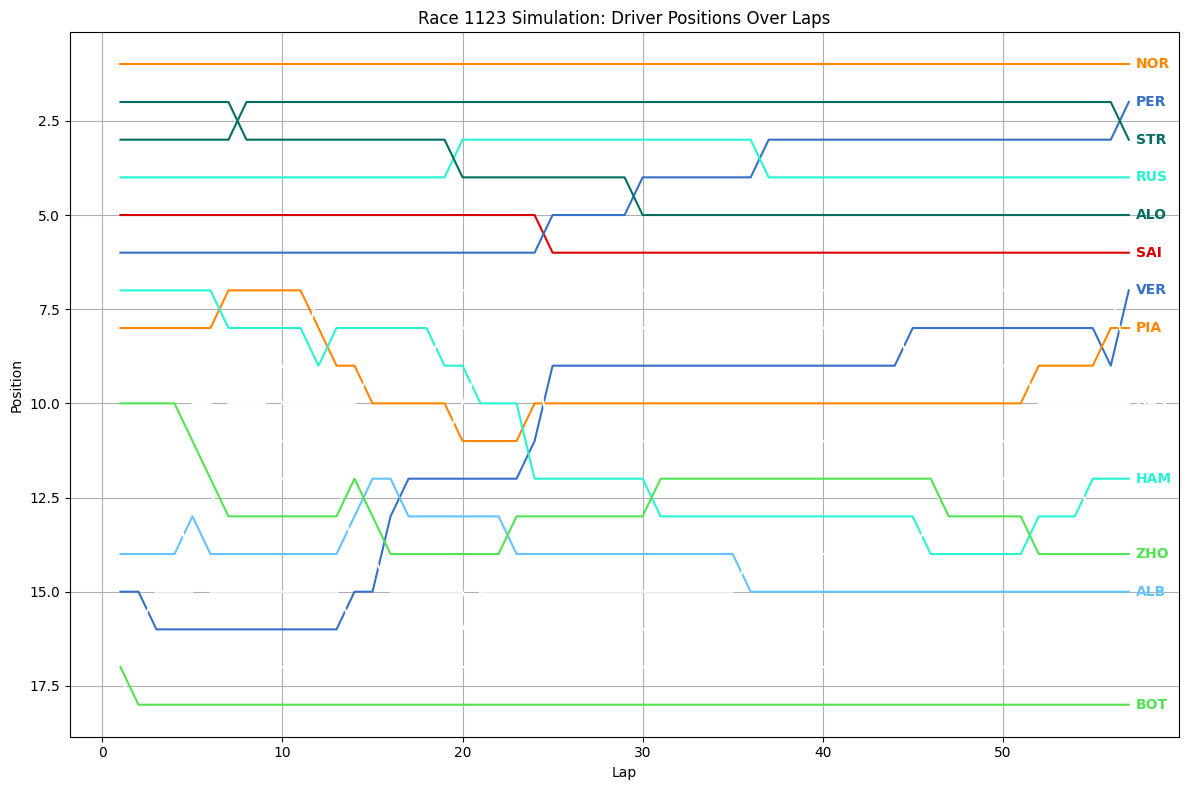

INFO:root:Lap times plot saved to plots/race_1123_times.png


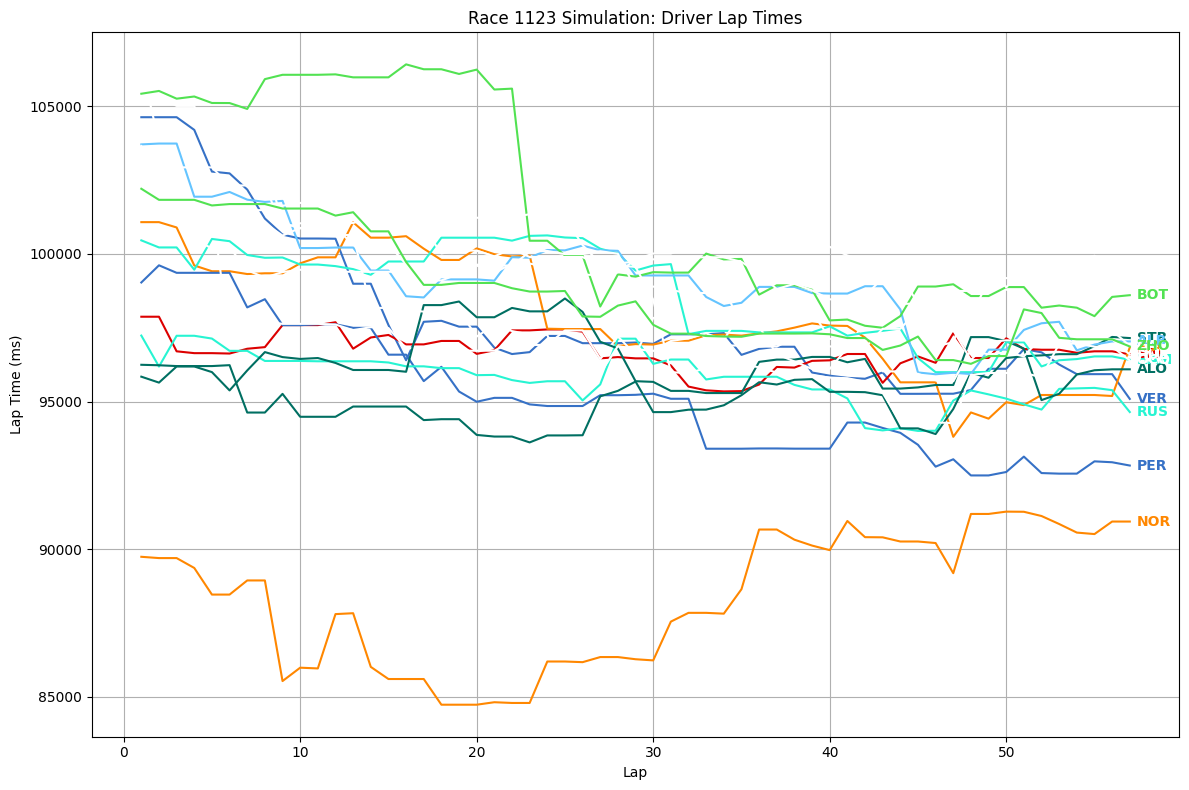

INFO:root:Evaluating race 1045
INFO:root:Initialized 18 drivers for raceId 1045
INFO:root:Simulating lap 1/56
INFO:root:Simulating lap 2/56
INFO:root:Simulating lap 3/56
INFO:root:Simulating lap 4/56
INFO:root:Simulating lap 5/56
INFO:root:Simulating lap 6/56
INFO:root:Simulating lap 7/56
INFO:root:Simulating lap 8/56
INFO:root:Simulating lap 9/56
INFO:root:Simulating lap 10/56
INFO:root:Simulating lap 11/56
INFO:root:Simulating lap 12/56
INFO:root:Simulating lap 13/56
INFO:root:Simulating lap 14/56
INFO:root:Simulating lap 15/56
INFO:root:Simulating lap 16/56
INFO:root:Simulating lap 17/56
INFO:root:Simulating lap 18/56
INFO:root:Simulating lap 19/56
INFO:root:Simulating lap 20/56
INFO:root:Simulating lap 21/56
INFO:root:Simulating lap 22/56
INFO:root:Simulating lap 23/56
INFO:root:Simulating lap 24/56
INFO:root:Simulating lap 25/56
INFO:root:Simulating lap 26/56
INFO:root:Simulating lap 27/56
INFO:root:Simulating lap 28/56
INFO:root:Simulating lap 29/56
INFO:root:Simulating lap 30/56

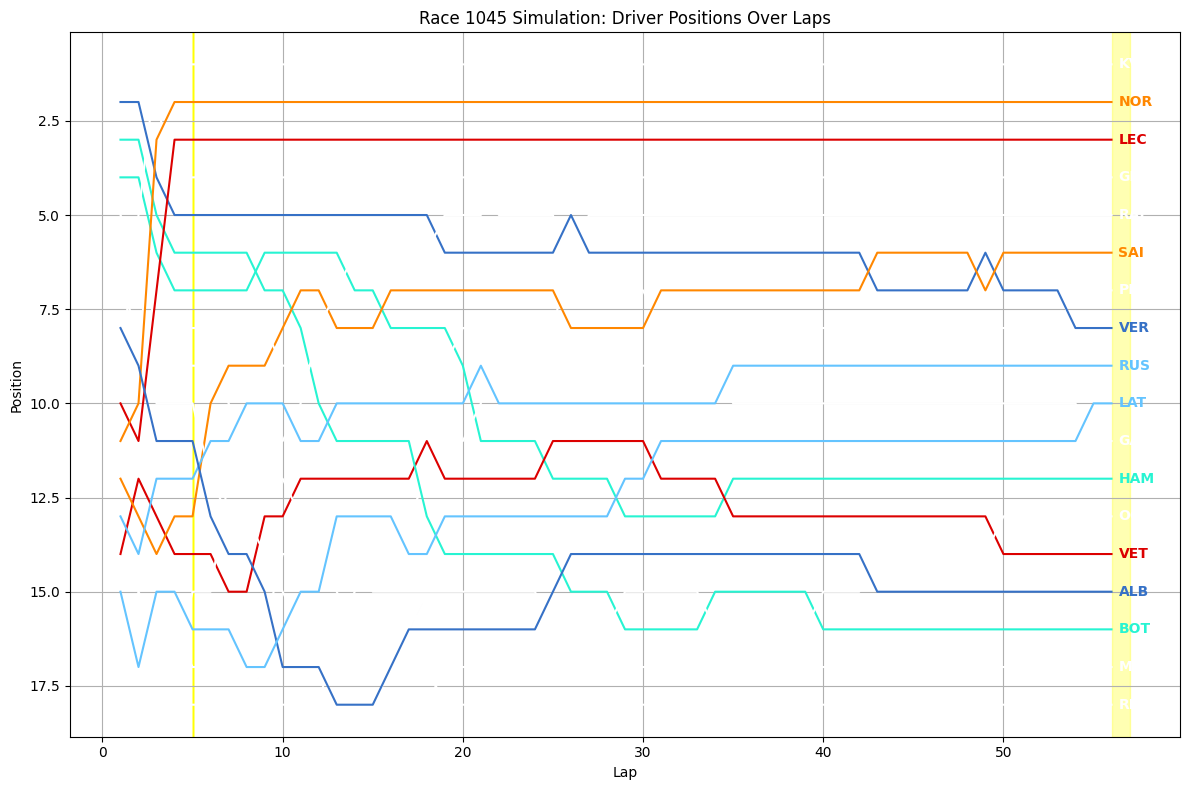

INFO:root:Lap times plot saved to plots/race_1045_times.png


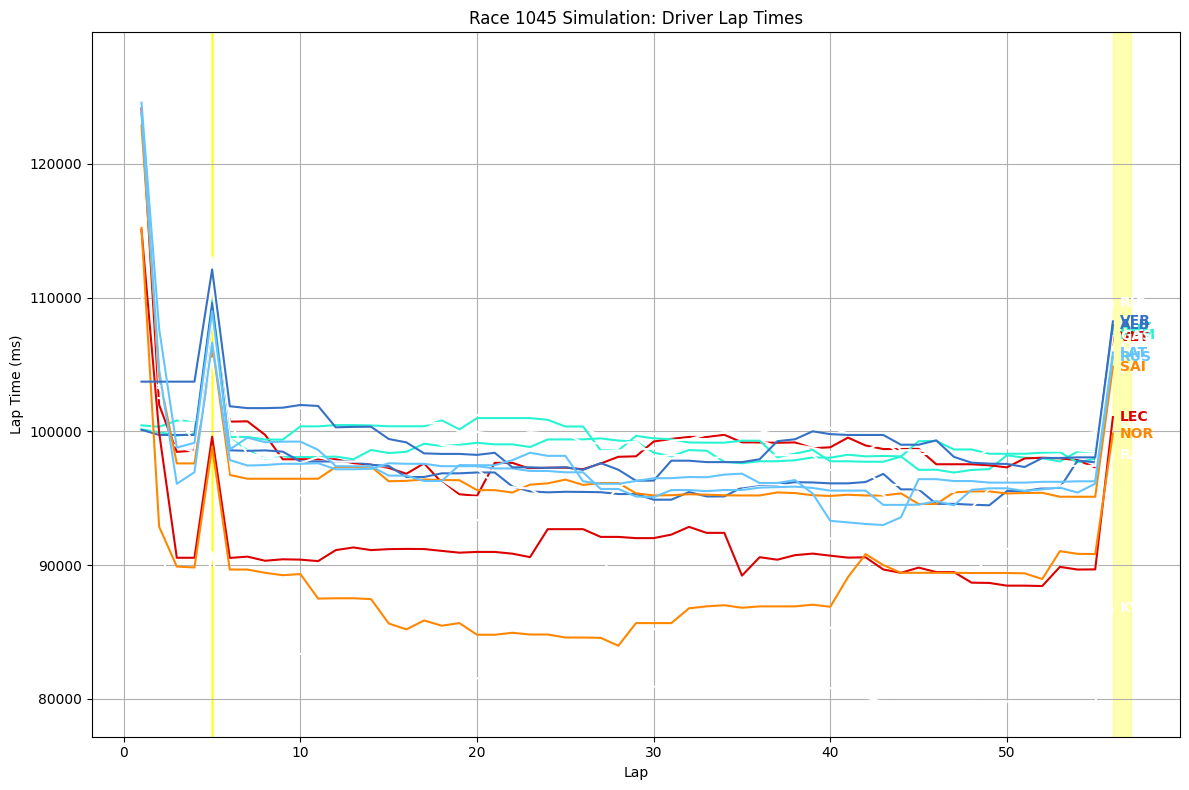

INFO:root:Evaluating race 993
INFO:root:Initialized 17 drivers for raceId 993
INFO:root:Simulating lap 1/66
INFO:root:Simulating lap 2/66
INFO:root:Simulating lap 3/66
INFO:root:Simulating lap 4/66
INFO:root:Simulating lap 5/66
INFO:root:Simulating lap 6/66
INFO:root:Simulating lap 7/66
INFO:root:Simulating lap 8/66
INFO:root:Simulating lap 9/66
INFO:root:Simulating lap 10/66
INFO:root:Simulating lap 11/66
INFO:root:Simulating lap 12/66
INFO:root:Simulating lap 13/66
INFO:root:Simulating lap 14/66
INFO:root:Simulating lap 15/66
INFO:root:Simulating lap 16/66
INFO:root:Simulating lap 17/66
INFO:root:Simulating lap 18/66
INFO:root:Simulating lap 19/66
INFO:root:Simulating lap 20/66
INFO:root:Simulating lap 21/66
INFO:root:Simulating lap 22/66
INFO:root:Simulating lap 23/66
INFO:root:Simulating lap 24/66
INFO:root:Simulating lap 25/66
INFO:root:Simulating lap 26/66
INFO:root:Simulating lap 27/66
INFO:root:Simulating lap 28/66
INFO:root:Simulating lap 29/66
INFO:root:Simulating lap 30/66
I

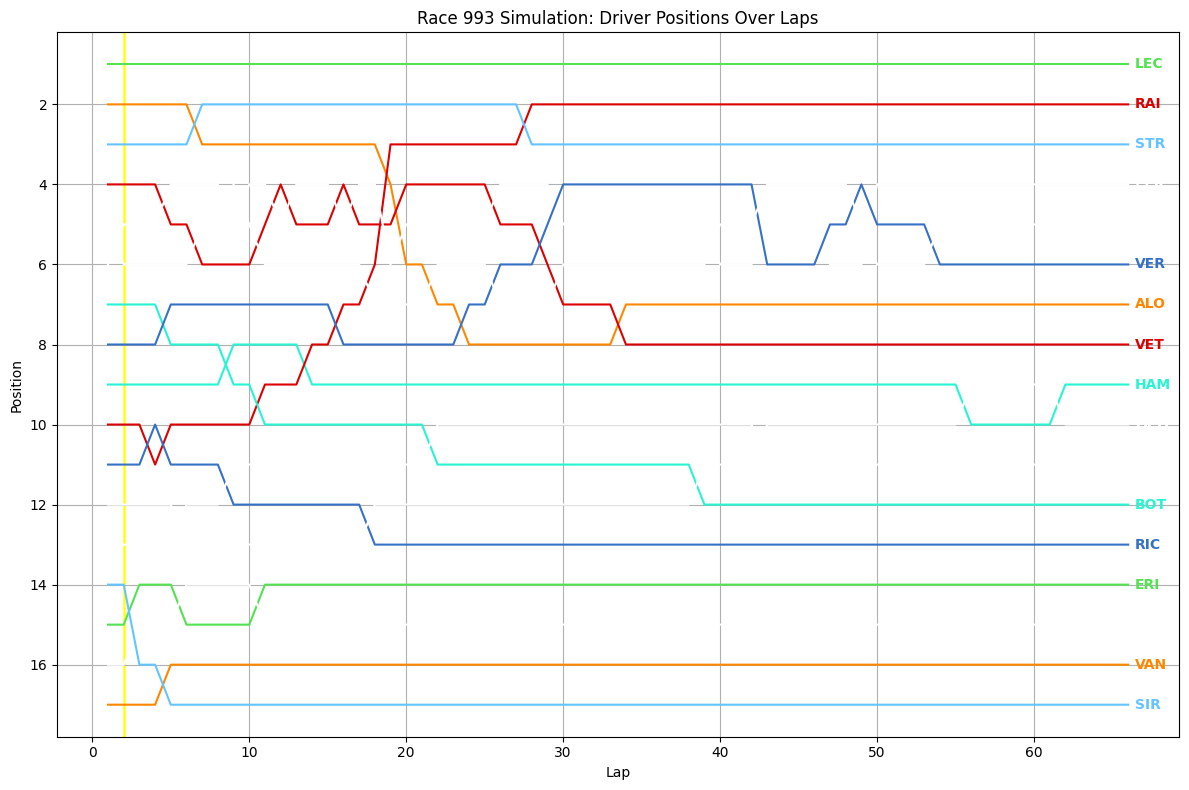

INFO:root:Lap times plot saved to plots/race_993_times.png


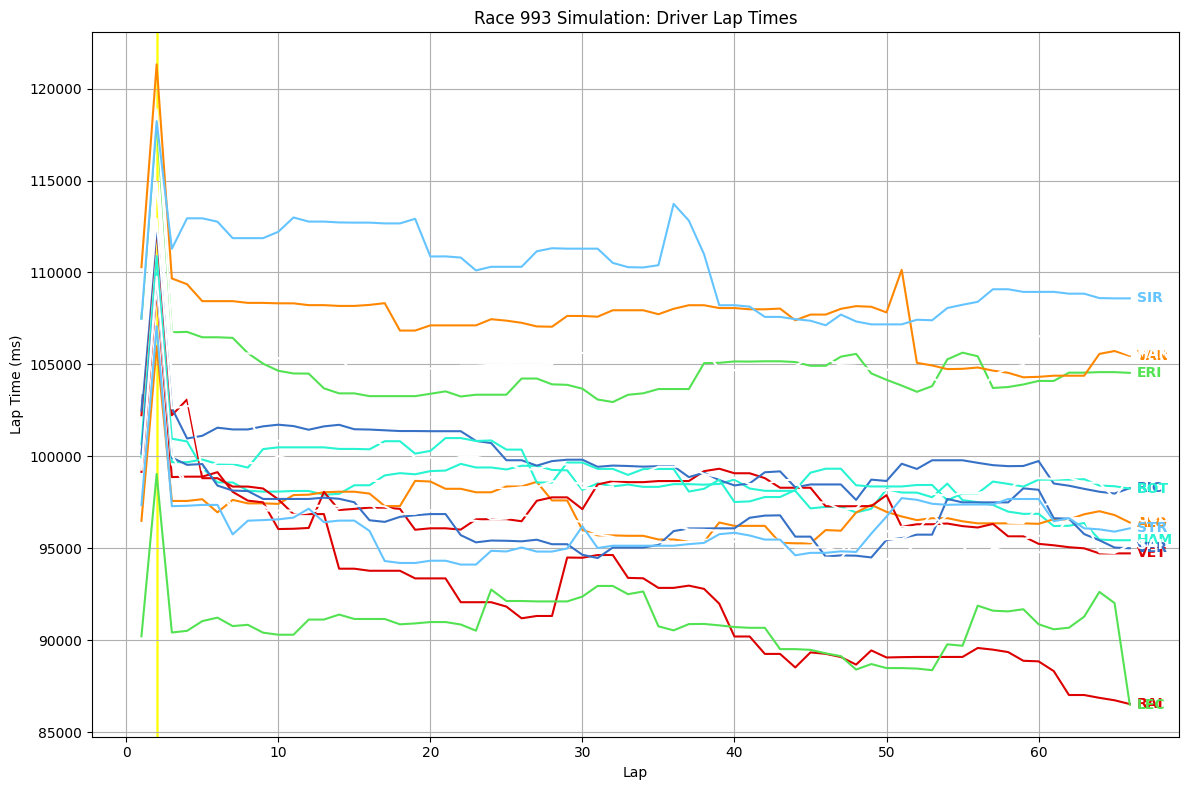

INFO:root:Evaluating race 1130
INFO:root:Initialized 20 drivers for raceId 1130
INFO:root:Simulating lap 1/66
INFO:root:Simulating lap 2/66
INFO:root:Simulating lap 3/66
INFO:root:Simulating lap 4/66
INFO:root:Simulating lap 5/66
INFO:root:Simulating lap 6/66
INFO:root:Simulating lap 7/66
INFO:root:Simulating lap 8/66
INFO:root:Simulating lap 9/66
INFO:root:Simulating lap 10/66
INFO:root:Simulating lap 11/66
INFO:root:Simulating lap 12/66
INFO:root:Simulating lap 13/66
INFO:root:Simulating lap 14/66
INFO:root:Simulating lap 15/66
INFO:root:Simulating lap 16/66
INFO:root:Simulating lap 17/66
INFO:root:Simulating lap 18/66
INFO:root:Simulating lap 19/66
INFO:root:Simulating lap 20/66
INFO:root:Simulating lap 21/66
INFO:root:Simulating lap 22/66
INFO:root:Simulating lap 23/66
INFO:root:Simulating lap 24/66
INFO:root:Simulating lap 25/66
INFO:root:Simulating lap 26/66
INFO:root:Simulating lap 27/66
INFO:root:Simulating lap 28/66
INFO:root:Simulating lap 29/66
INFO:root:Simulating lap 30/66

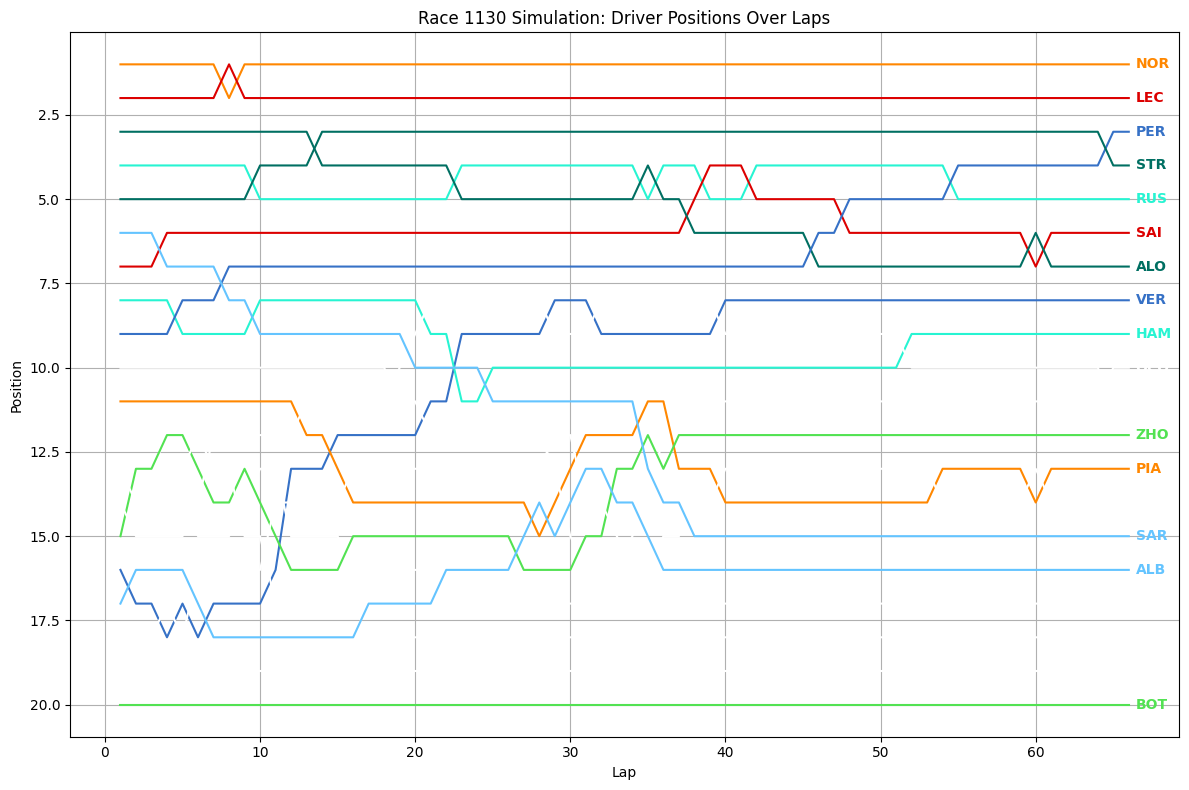

INFO:root:Lap times plot saved to plots/race_1130_times.png


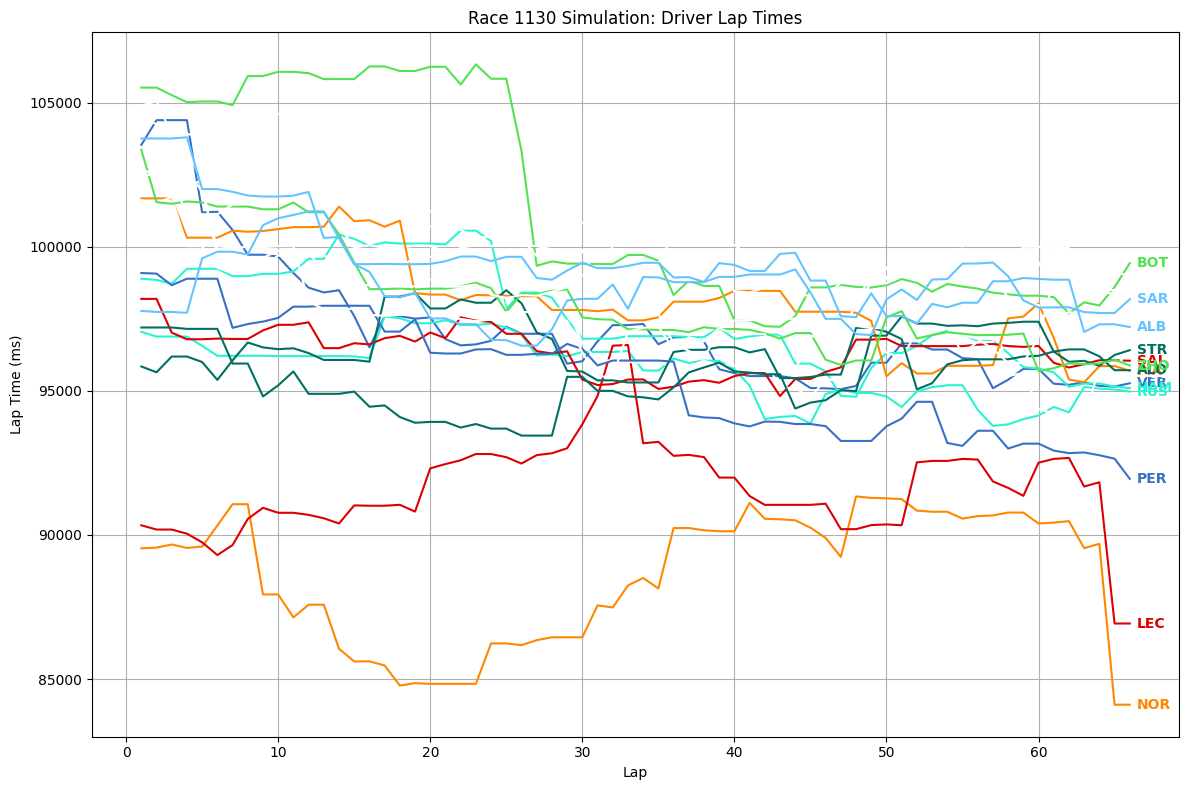

INFO:root:Evaluating race 1044
INFO:root:Initialized 20 drivers for raceId 1044
INFO:root:Simulating lap 1/58
INFO:root:Simulating lap 2/58
INFO:root:Simulating lap 3/58
INFO:root:Simulating lap 4/58
INFO:root:Simulating lap 5/58
INFO:root:Simulating lap 6/58
INFO:root:Simulating lap 7/58
INFO:root:Simulating lap 8/58
INFO:root:Simulating lap 9/58
INFO:root:Simulating lap 10/58
INFO:root:Simulating lap 11/58
INFO:root:Simulating lap 12/58
INFO:root:Simulating lap 13/58
INFO:root:Simulating lap 14/58
INFO:root:Simulating lap 15/58
INFO:root:Simulating lap 16/58
INFO:root:Simulating lap 17/58
INFO:root:Simulating lap 18/58
INFO:root:Simulating lap 19/58
INFO:root:Simulating lap 20/58
INFO:root:Simulating lap 21/58
INFO:root:Simulating lap 22/58
INFO:root:Simulating lap 23/58
INFO:root:Simulating lap 24/58
INFO:root:Simulating lap 25/58
INFO:root:Simulating lap 26/58
INFO:root:Simulating lap 27/58
INFO:root:Simulating lap 28/58
INFO:root:Simulating lap 29/58
INFO:root:Simulating lap 30/58

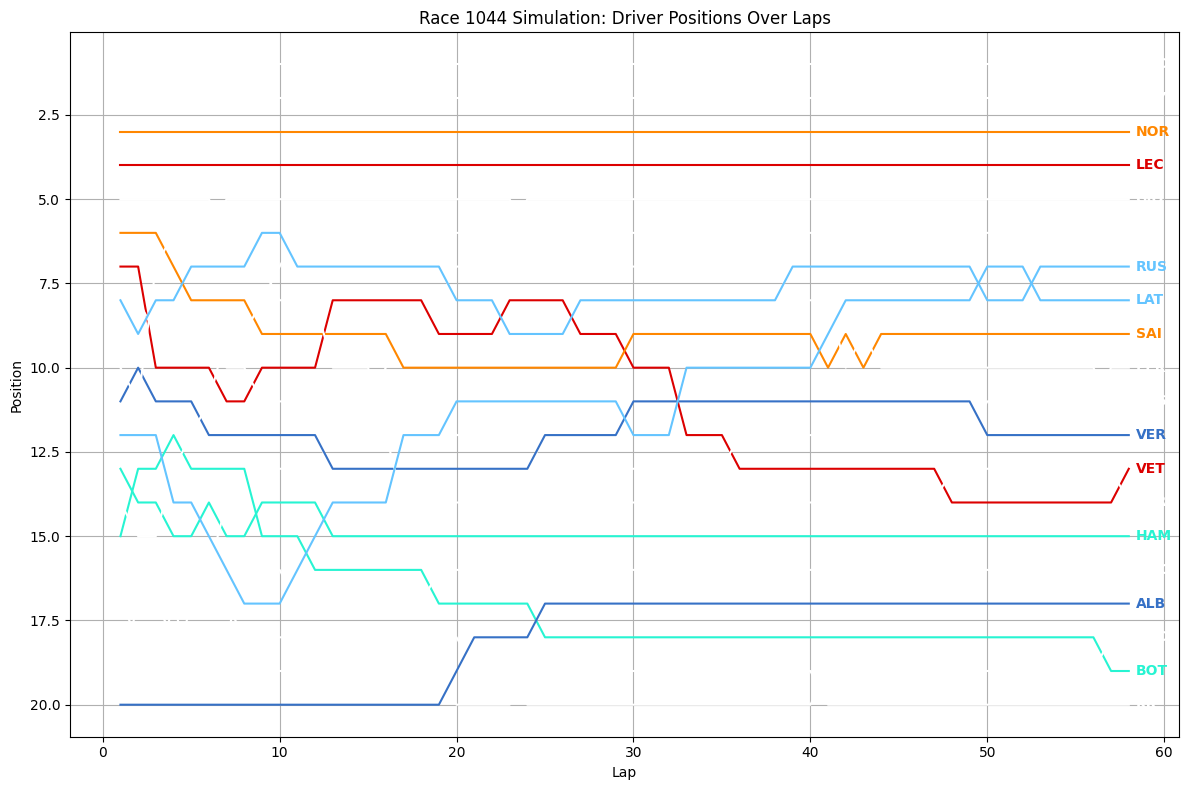

INFO:root:Lap times plot saved to plots/race_1044_times.png


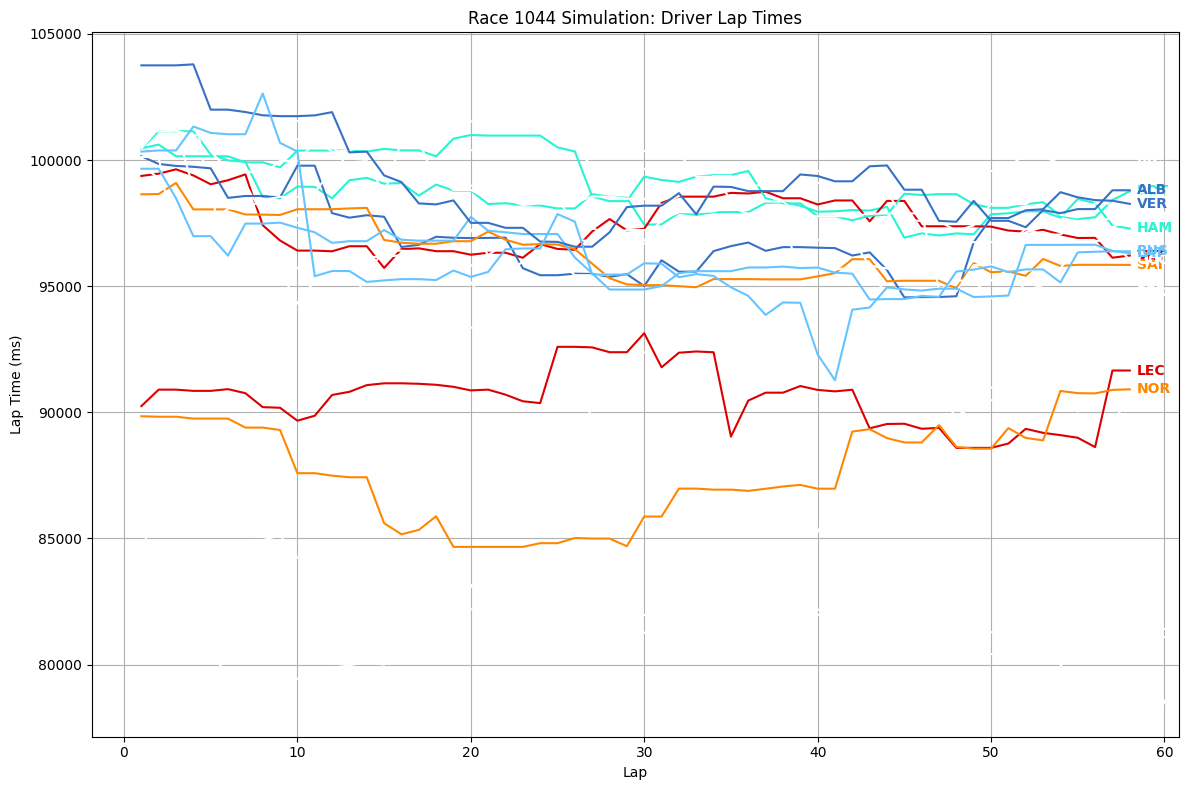

INFO:root:Evaluating race 1067
INFO:root:Initialized 20 drivers for raceId 1067
INFO:root:Simulating lap 1/58
INFO:root:Simulating lap 2/58
INFO:root:Simulating lap 3/58
INFO:root:Simulating lap 4/58
INFO:root:Simulating lap 5/58
INFO:root:Simulating lap 6/58
INFO:root:Simulating lap 7/58
INFO:root:Simulating lap 8/58
INFO:root:Simulating lap 9/58
INFO:root:Simulating lap 10/58
INFO:root:Simulating lap 11/58
INFO:root:Simulating lap 12/58
INFO:root:Simulating lap 13/58
INFO:root:Simulating lap 14/58
INFO:root:Simulating lap 15/58
INFO:root:Simulating lap 16/58
INFO:root:Simulating lap 17/58
INFO:root:Simulating lap 18/58
INFO:root:Simulating lap 19/58
INFO:root:Simulating lap 20/58
INFO:root:Simulating lap 21/58
INFO:root:Simulating lap 22/58
INFO:root:Simulating lap 23/58
INFO:root:Simulating lap 24/58
INFO:root:Simulating lap 25/58
INFO:root:Simulating lap 26/58
INFO:root:Simulating lap 27/58
INFO:root:Simulating lap 28/58
INFO:root:Simulating lap 29/58
INFO:root:Simulating lap 30/58

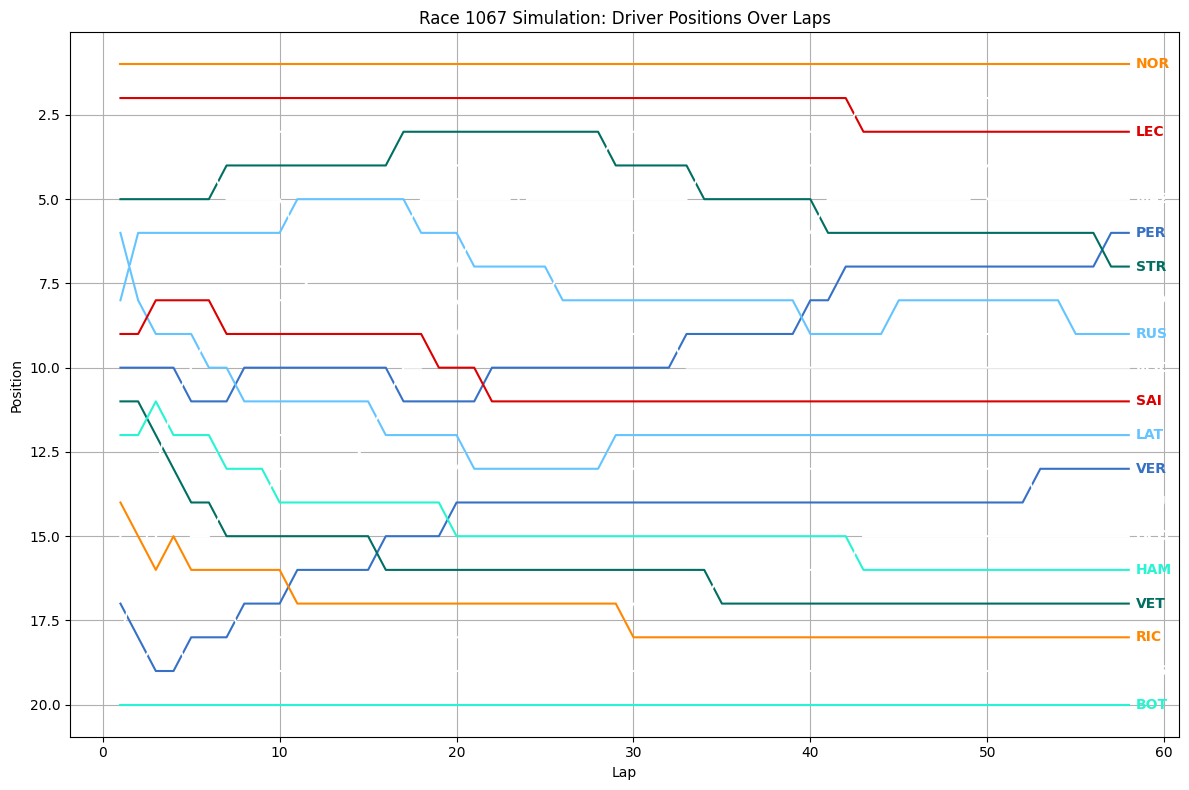

INFO:root:Lap times plot saved to plots/race_1067_times.png


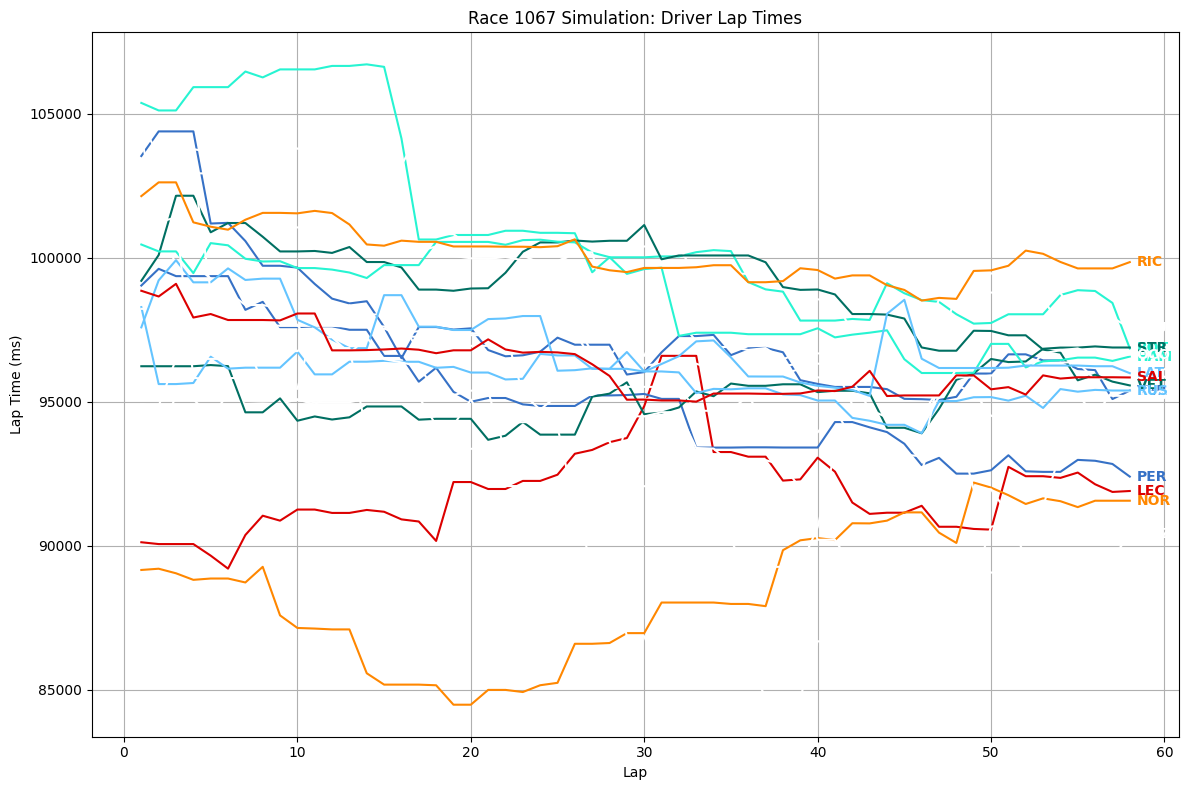

INFO:root:Evaluating race 1015
INFO:root:Initialized 20 drivers for raceId 1015
INFO:root:Simulating lap 1/78
INFO:root:Simulating lap 2/78
INFO:root:Simulating lap 3/78
INFO:root:Simulating lap 4/78
INFO:root:Simulating lap 5/78
INFO:root:Simulating lap 6/78
INFO:root:Simulating lap 7/78
INFO:root:Simulating lap 8/78
INFO:root:Simulating lap 9/78
INFO:root:Simulating lap 10/78
INFO:root:Simulating lap 11/78
INFO:root:Simulating lap 12/78
INFO:root:Simulating lap 13/78
INFO:root:Simulating lap 14/78
INFO:root:Simulating lap 15/78
INFO:root:Simulating lap 16/78
INFO:root:Simulating lap 17/78
INFO:root:Simulating lap 18/78
INFO:root:Simulating lap 19/78
INFO:root:Simulating lap 20/78
INFO:root:Simulating lap 21/78
INFO:root:Simulating lap 22/78
INFO:root:Simulating lap 23/78
INFO:root:Simulating lap 24/78
INFO:root:Simulating lap 25/78
INFO:root:Simulating lap 26/78
INFO:root:Simulating lap 27/78
INFO:root:Simulating lap 28/78
INFO:root:Simulating lap 29/78
INFO:root:Simulating lap 30/78

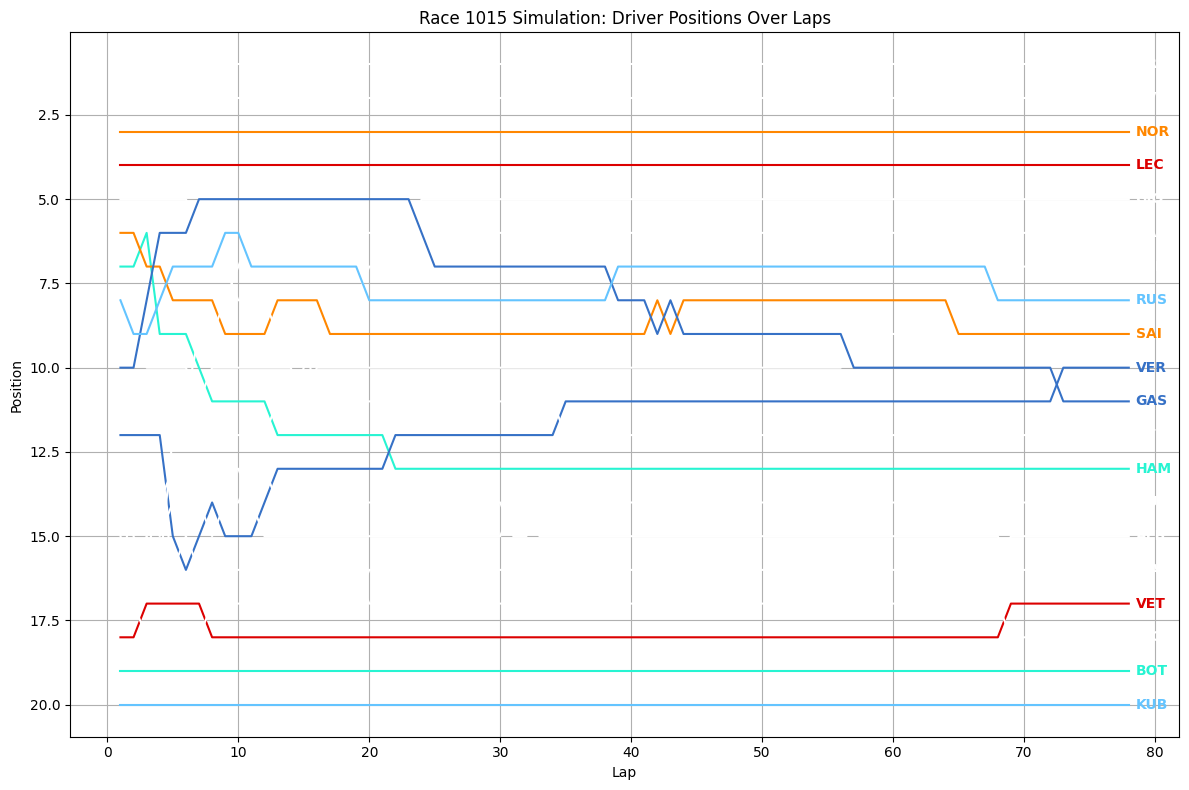

INFO:root:Lap times plot saved to plots/race_1015_times.png


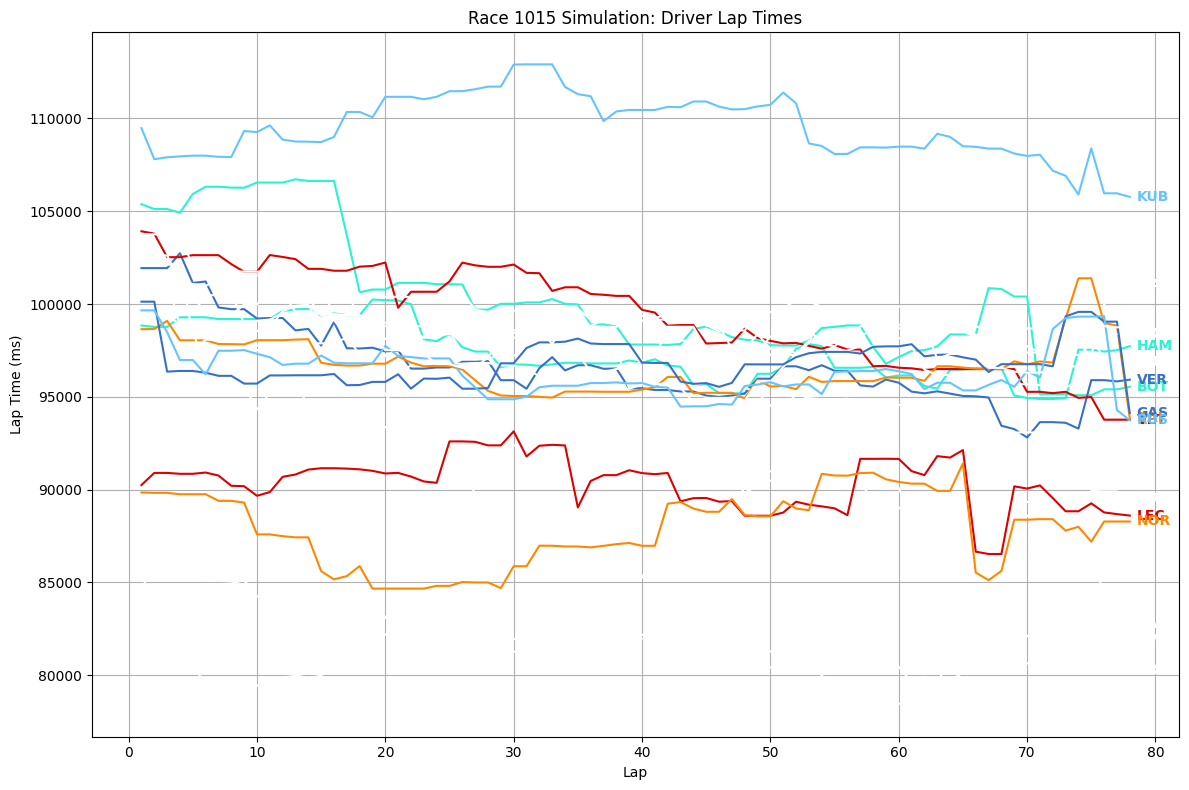

INFO:root:Evaluating race 1016
INFO:root:Initialized 20 drivers for raceId 1016
INFO:root:Simulating lap 1/70
INFO:root:Simulating lap 2/70
INFO:root:Simulating lap 3/70
INFO:root:Simulating lap 4/70
INFO:root:Simulating lap 5/70
INFO:root:Simulating lap 6/70
INFO:root:Simulating lap 7/70
INFO:root:Simulating lap 8/70
INFO:root:Simulating lap 9/70
INFO:root:Simulating lap 10/70
INFO:root:Simulating lap 11/70
INFO:root:Simulating lap 12/70
INFO:root:Simulating lap 13/70
INFO:root:Simulating lap 14/70
INFO:root:Simulating lap 15/70
INFO:root:Simulating lap 16/70
INFO:root:Simulating lap 17/70
INFO:root:Simulating lap 18/70
INFO:root:Simulating lap 19/70
INFO:root:Simulating lap 20/70
INFO:root:Simulating lap 21/70
INFO:root:Simulating lap 22/70
INFO:root:Simulating lap 23/70
INFO:root:Simulating lap 24/70
INFO:root:Simulating lap 25/70
INFO:root:Simulating lap 26/70
INFO:root:Simulating lap 27/70
INFO:root:Simulating lap 28/70
INFO:root:Simulating lap 29/70
INFO:root:Simulating lap 30/70

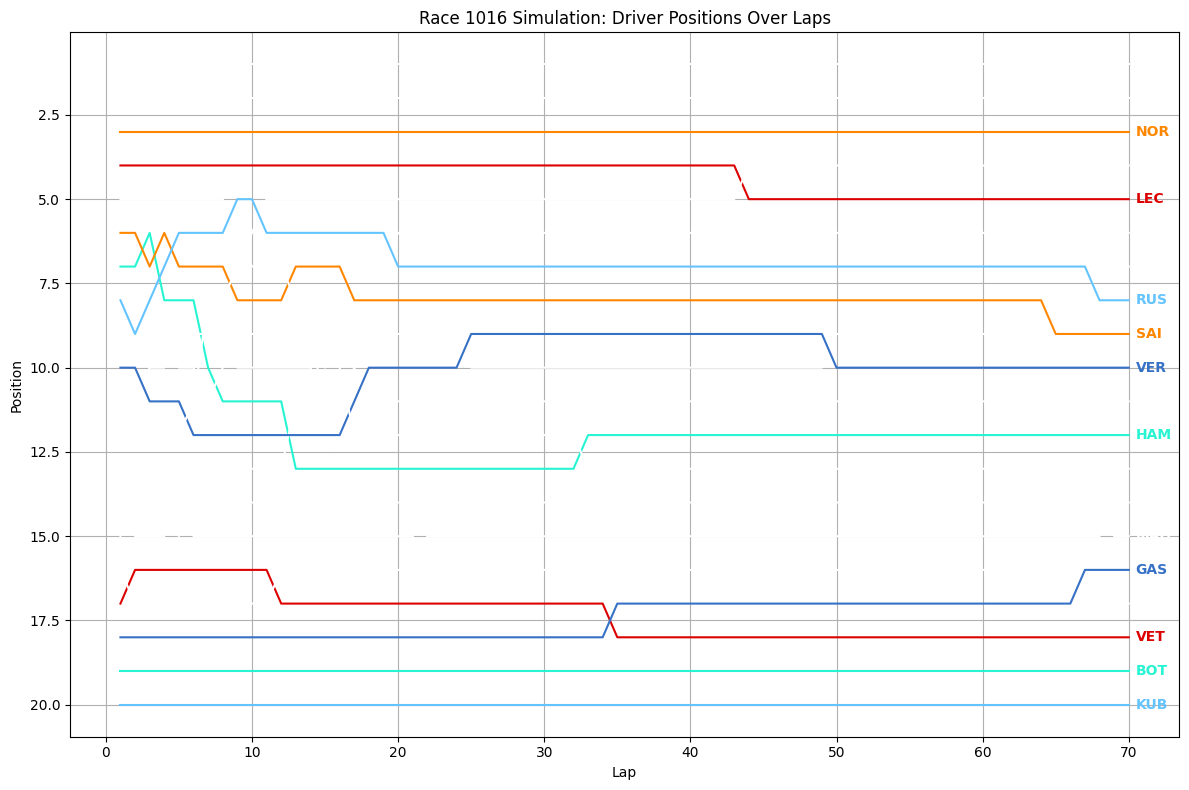

INFO:root:Lap times plot saved to plots/race_1016_times.png


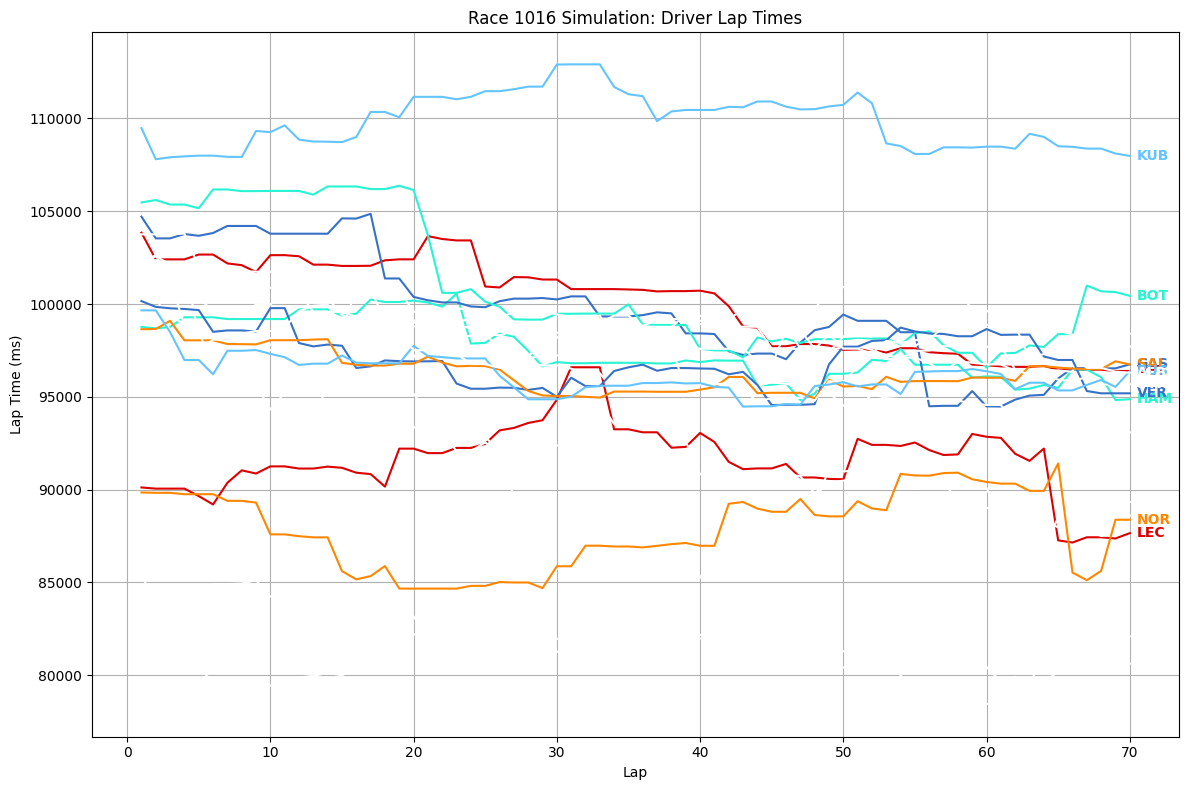

INFO:root:Evaluating race 998
INFO:root:Initialized 19 drivers for raceId 998
INFO:root:Simulating lap 1/52
INFO:root:Simulating lap 2/52
INFO:root:Simulating lap 3/52
INFO:root:Simulating lap 4/52
INFO:root:Simulating lap 5/52
INFO:root:Simulating lap 6/52
INFO:root:Simulating lap 7/52
INFO:root:Simulating lap 8/52
INFO:root:Simulating lap 9/52
INFO:root:Simulating lap 10/52
INFO:root:Simulating lap 11/52
INFO:root:Simulating lap 12/52
INFO:root:Simulating lap 13/52
INFO:root:Simulating lap 14/52
INFO:root:Simulating lap 15/52
INFO:root:Simulating lap 16/52
INFO:root:Simulating lap 17/52
INFO:root:Simulating lap 18/52
INFO:root:Simulating lap 19/52
INFO:root:Simulating lap 20/52
INFO:root:Simulating lap 21/52
INFO:root:Simulating lap 22/52
INFO:root:Simulating lap 23/52
INFO:root:Simulating lap 24/52
INFO:root:Simulating lap 25/52
INFO:root:Simulating lap 26/52
INFO:root:Simulating lap 27/52
INFO:root:Simulating lap 28/52
INFO:root:Simulating lap 29/52
INFO:root:Simulating lap 30/52
I

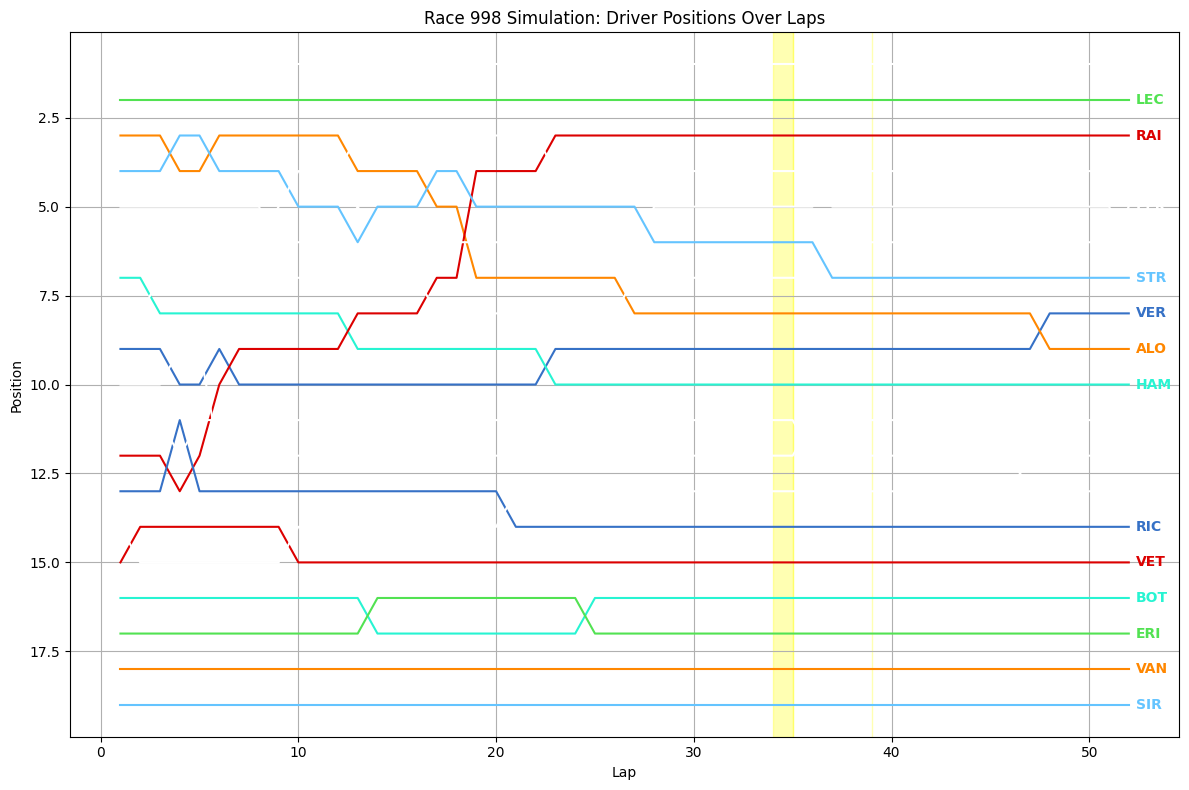

INFO:root:Lap times plot saved to plots/race_998_times.png


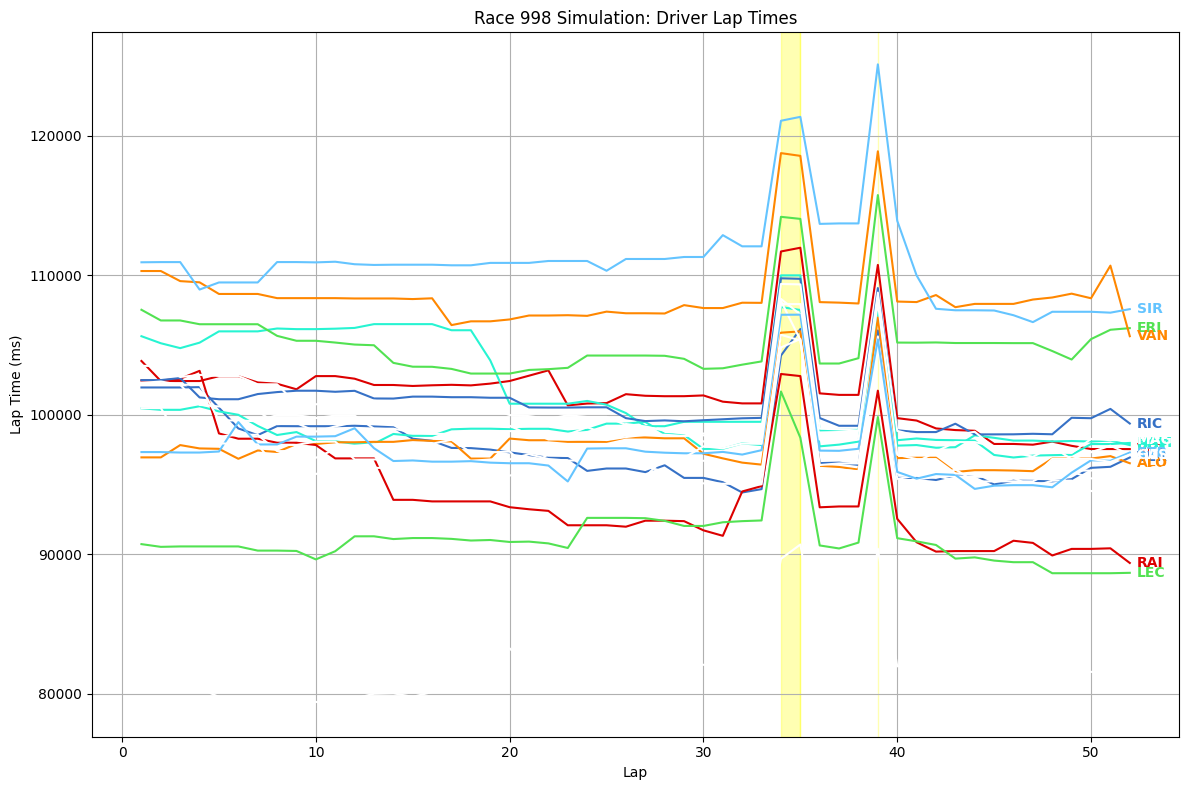

INFO:root:Evaluating race 1034
INFO:root:Initialized 18 drivers for raceId 1034
INFO:root:Simulating lap 1/52
INFO:root:Simulating lap 2/52
INFO:root:Simulating lap 3/52
INFO:root:Simulating lap 4/52
INFO:root:Simulating lap 5/52
INFO:root:Simulating lap 6/52
INFO:root:Simulating lap 7/52
INFO:root:Simulating lap 8/52
INFO:root:Simulating lap 9/52
INFO:root:Simulating lap 10/52
INFO:root:Simulating lap 11/52
INFO:root:Simulating lap 12/52
INFO:root:Simulating lap 13/52
INFO:root:Simulating lap 14/52
INFO:root:Simulating lap 15/52
INFO:root:Simulating lap 16/52
INFO:root:Simulating lap 17/52
INFO:root:Simulating lap 18/52
INFO:root:Simulating lap 19/52
INFO:root:Simulating lap 20/52
INFO:root:Simulating lap 21/52
INFO:root:Simulating lap 22/52
INFO:root:Simulating lap 23/52
INFO:root:Simulating lap 24/52
INFO:root:Simulating lap 25/52
INFO:root:Simulating lap 26/52
INFO:root:Simulating lap 27/52
INFO:root:Simulating lap 28/52
INFO:root:Simulating lap 29/52
INFO:root:Simulating lap 30/52

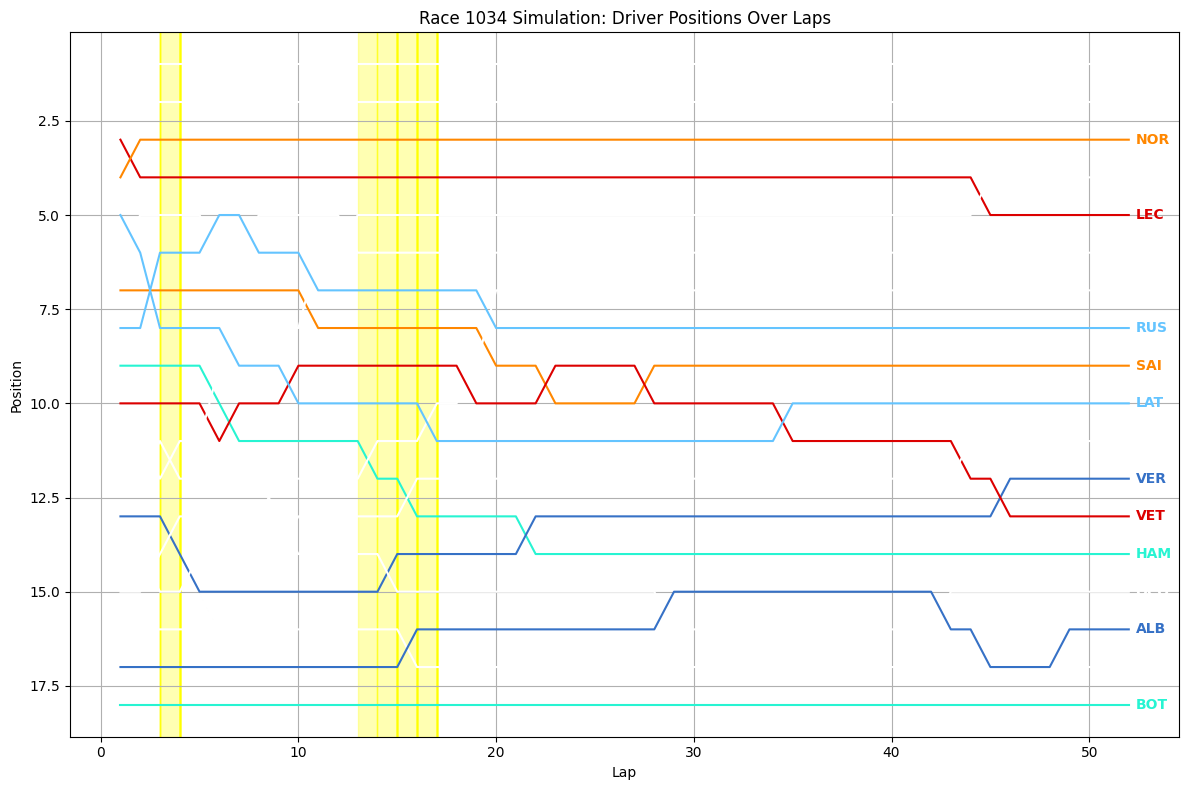

INFO:root:Lap times plot saved to plots/race_1034_times.png


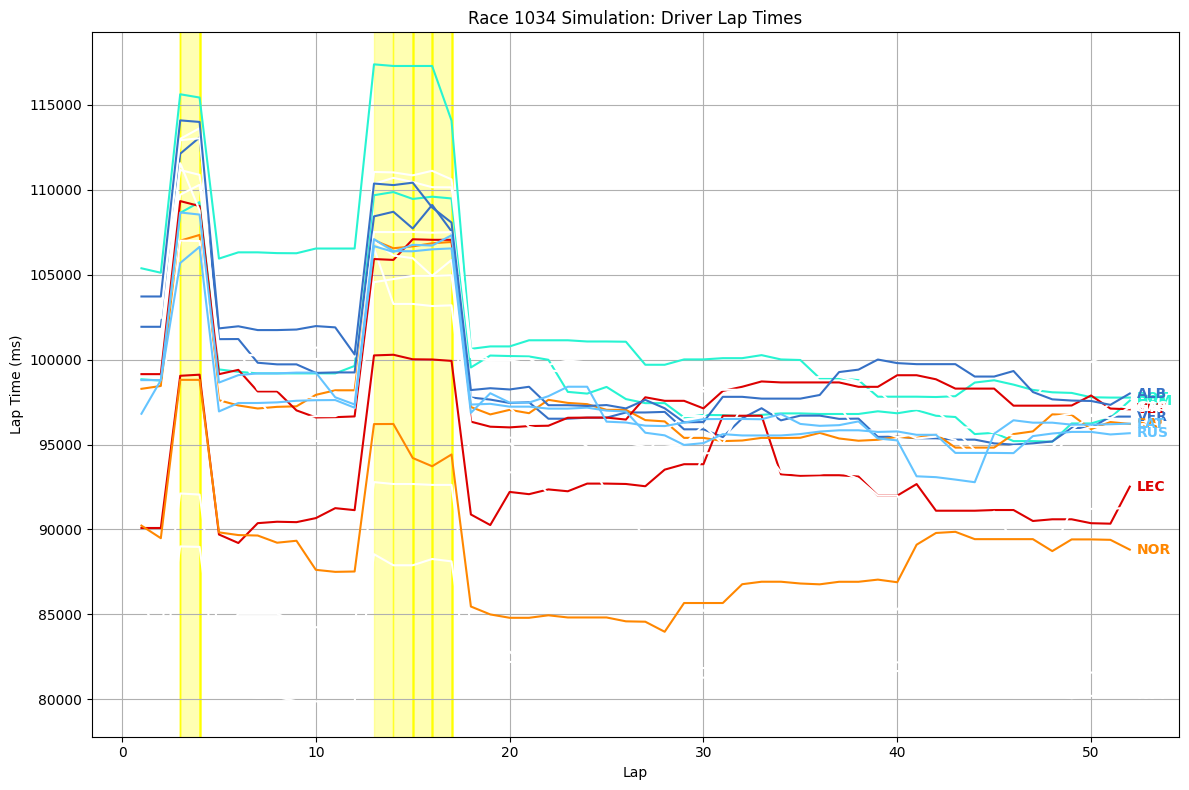

INFO:root:Evaluating race 1108
INFO:root:Initialized 20 drivers for raceId 1108
INFO:root:Simulating lap 1/52
INFO:root:Simulating lap 2/52
INFO:root:Simulating lap 3/52
INFO:root:Simulating lap 4/52
INFO:root:Simulating lap 5/52
INFO:root:Simulating lap 6/52
INFO:root:Simulating lap 7/52
INFO:root:Simulating lap 8/52
INFO:root:Simulating lap 9/52
INFO:root:Simulating lap 10/52
INFO:root:Simulating lap 11/52
INFO:root:Simulating lap 12/52
INFO:root:Simulating lap 13/52
INFO:root:Simulating lap 14/52
INFO:root:Simulating lap 15/52
INFO:root:Simulating lap 16/52
INFO:root:Simulating lap 17/52
INFO:root:Simulating lap 18/52
INFO:root:Simulating lap 19/52
INFO:root:Simulating lap 20/52
INFO:root:Simulating lap 21/52
INFO:root:Simulating lap 22/52
INFO:root:Simulating lap 23/52
INFO:root:Simulating lap 24/52
INFO:root:Simulating lap 25/52
INFO:root:Simulating lap 26/52
INFO:root:Simulating lap 27/52
INFO:root:Simulating lap 28/52
INFO:root:Simulating lap 29/52
INFO:root:Simulating lap 30/52

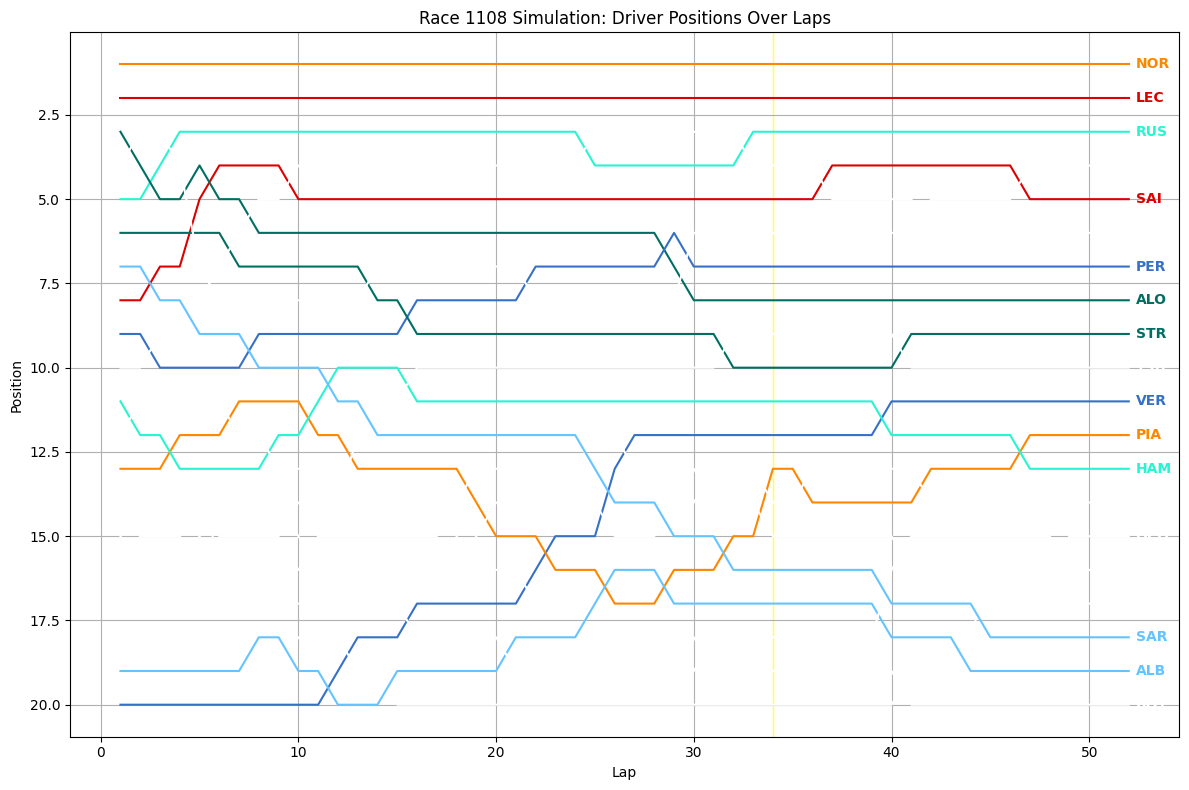

INFO:root:Lap times plot saved to plots/race_1108_times.png


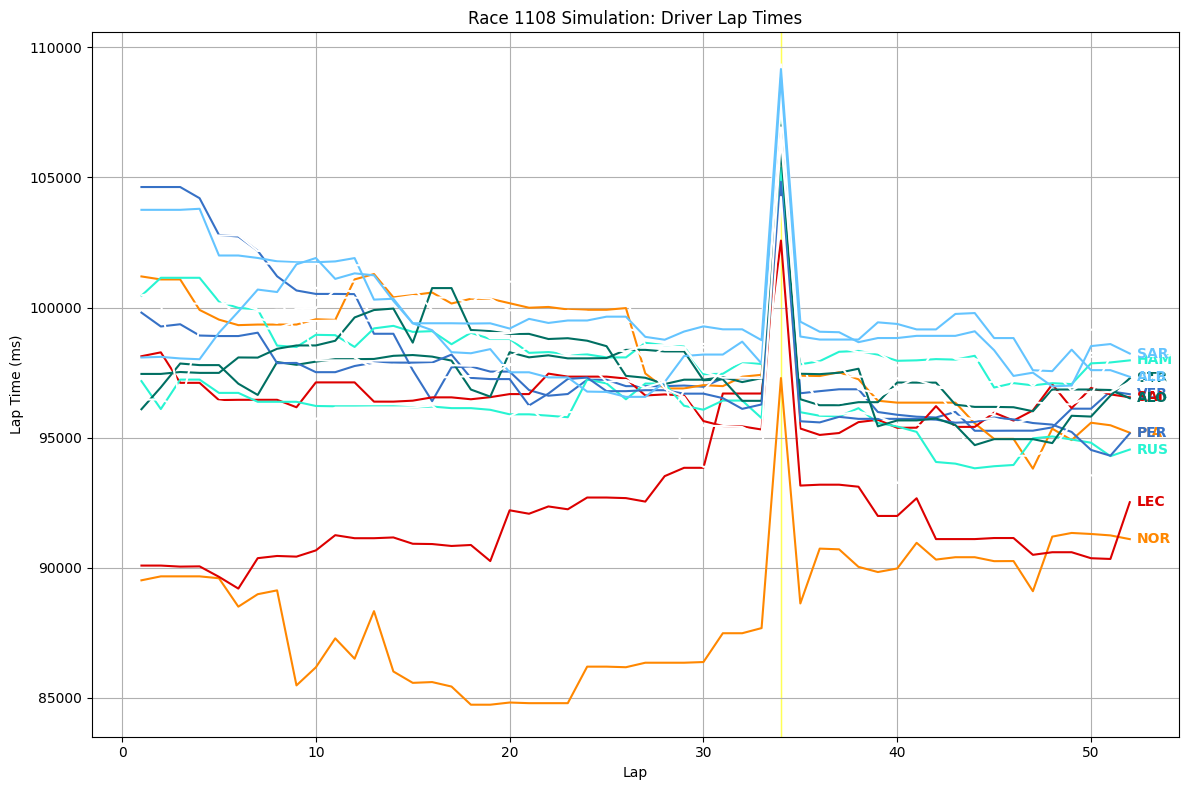

INFO:root:Evaluating race 1000
INFO:root:Initialized 19 drivers for raceId 1000
INFO:root:Simulating lap 1/70
INFO:root:Simulating lap 2/70
INFO:root:Simulating lap 3/70
INFO:root:Simulating lap 4/70
INFO:root:Simulating lap 5/70
INFO:root:Simulating lap 6/70
INFO:root:Simulating lap 7/70
INFO:root:Simulating lap 8/70
INFO:root:Simulating lap 9/70
INFO:root:Simulating lap 10/70
INFO:root:Simulating lap 11/70
INFO:root:Simulating lap 12/70
INFO:root:Simulating lap 13/70
INFO:root:Simulating lap 14/70
INFO:root:Simulating lap 15/70
INFO:root:Simulating lap 16/70
INFO:root:Simulating lap 17/70
INFO:root:Simulating lap 18/70
INFO:root:Simulating lap 19/70
INFO:root:Simulating lap 20/70
INFO:root:Simulating lap 21/70
INFO:root:Simulating lap 22/70
INFO:root:Simulating lap 23/70
INFO:root:Simulating lap 24/70
INFO:root:Simulating lap 25/70
INFO:root:Simulating lap 26/70
INFO:root:Simulating lap 27/70
INFO:root:Simulating lap 28/70
INFO:root:Simulating lap 29/70
INFO:root:Simulating lap 30/70

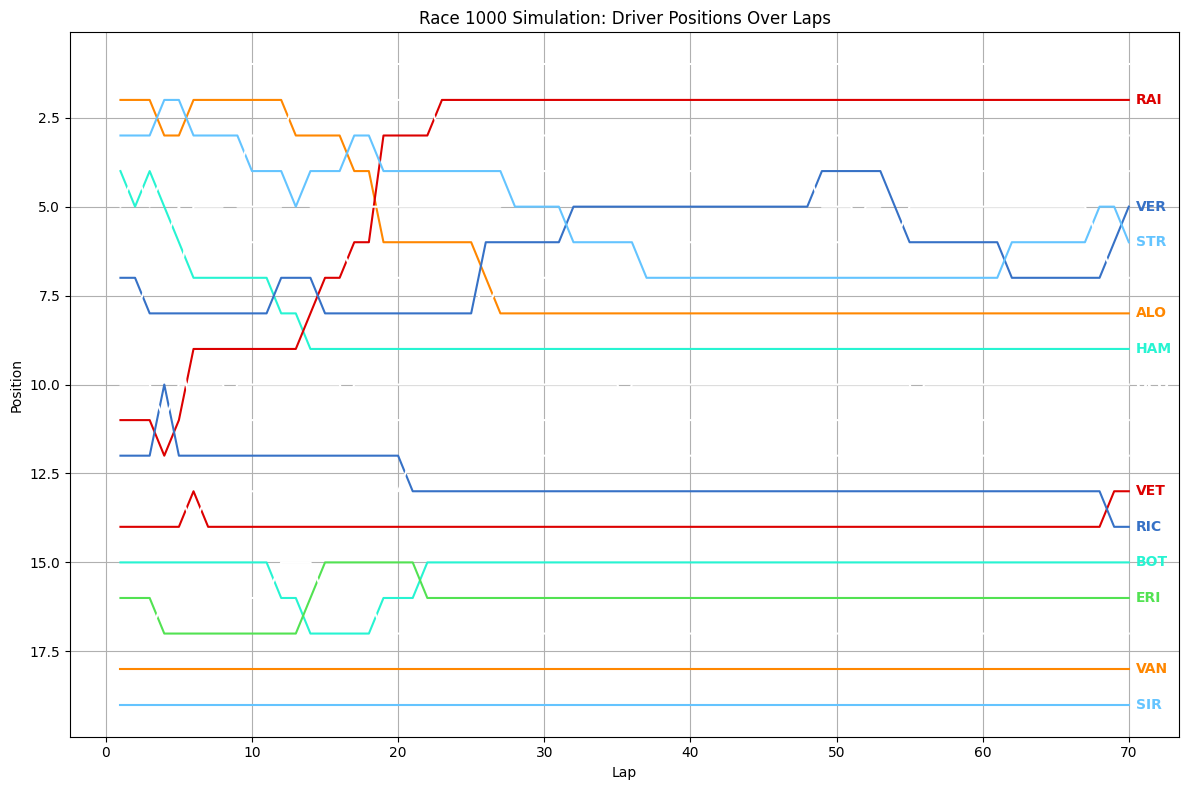

INFO:root:Lap times plot saved to plots/race_1000_times.png


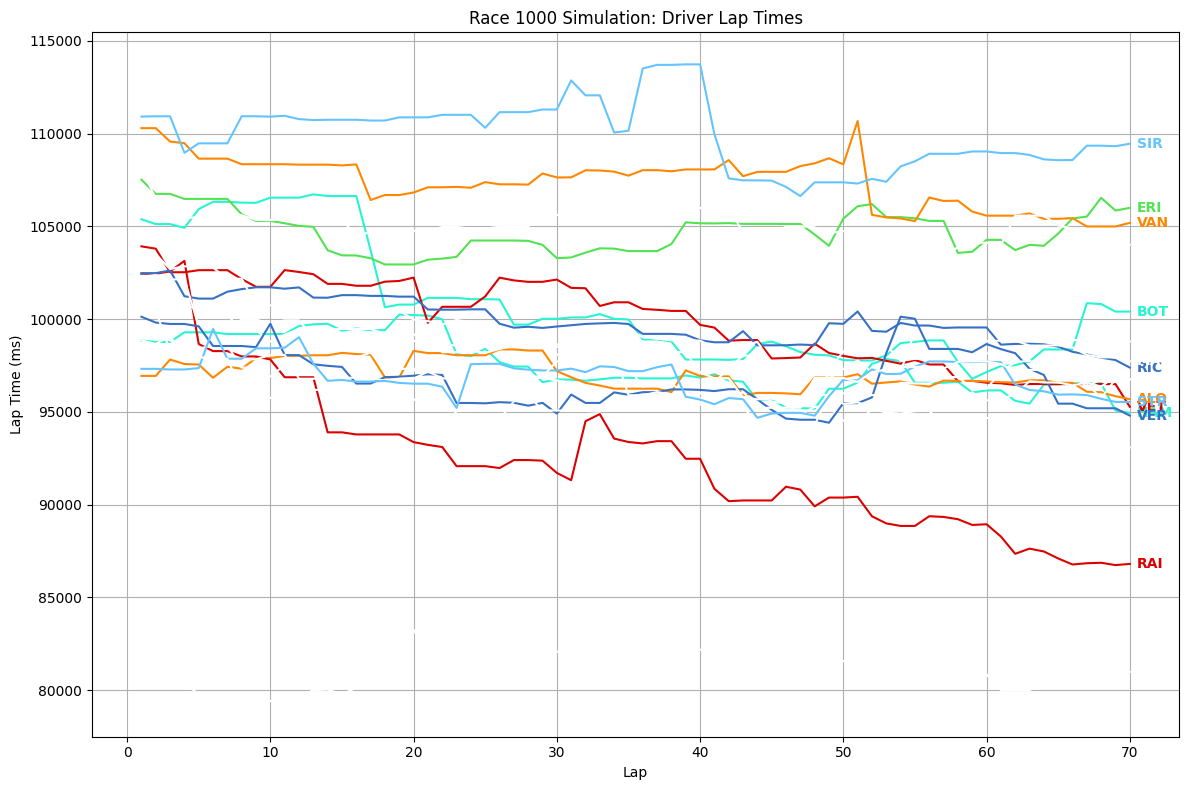

INFO:root:Evaluating race 1062
INFO:root:Initialized 14 drivers for raceId 1062
INFO:root:Simulating lap 1/70
INFO:root:Simulating lap 2/70
INFO:root:Simulating lap 3/70
INFO:root:Simulating lap 4/70
INFO:root:Simulating lap 5/70
INFO:root:Simulating lap 6/70
INFO:root:Simulating lap 7/70
INFO:root:Simulating lap 8/70
INFO:root:Simulating lap 9/70
INFO:root:Simulating lap 10/70
INFO:root:Simulating lap 11/70
INFO:root:Simulating lap 12/70
INFO:root:Simulating lap 13/70
INFO:root:Simulating lap 14/70
INFO:root:Simulating lap 15/70
INFO:root:Simulating lap 16/70
INFO:root:Simulating lap 17/70
INFO:root:Simulating lap 18/70
INFO:root:Simulating lap 19/70
INFO:root:Simulating lap 20/70
INFO:root:Simulating lap 21/70
INFO:root:Simulating lap 22/70
INFO:root:Simulating lap 23/70
INFO:root:Simulating lap 24/70
INFO:root:Simulating lap 25/70
INFO:root:Simulating lap 26/70
INFO:root:Simulating lap 27/70
INFO:root:Simulating lap 28/70
INFO:root:Simulating lap 29/70
INFO:root:Simulating lap 30/70

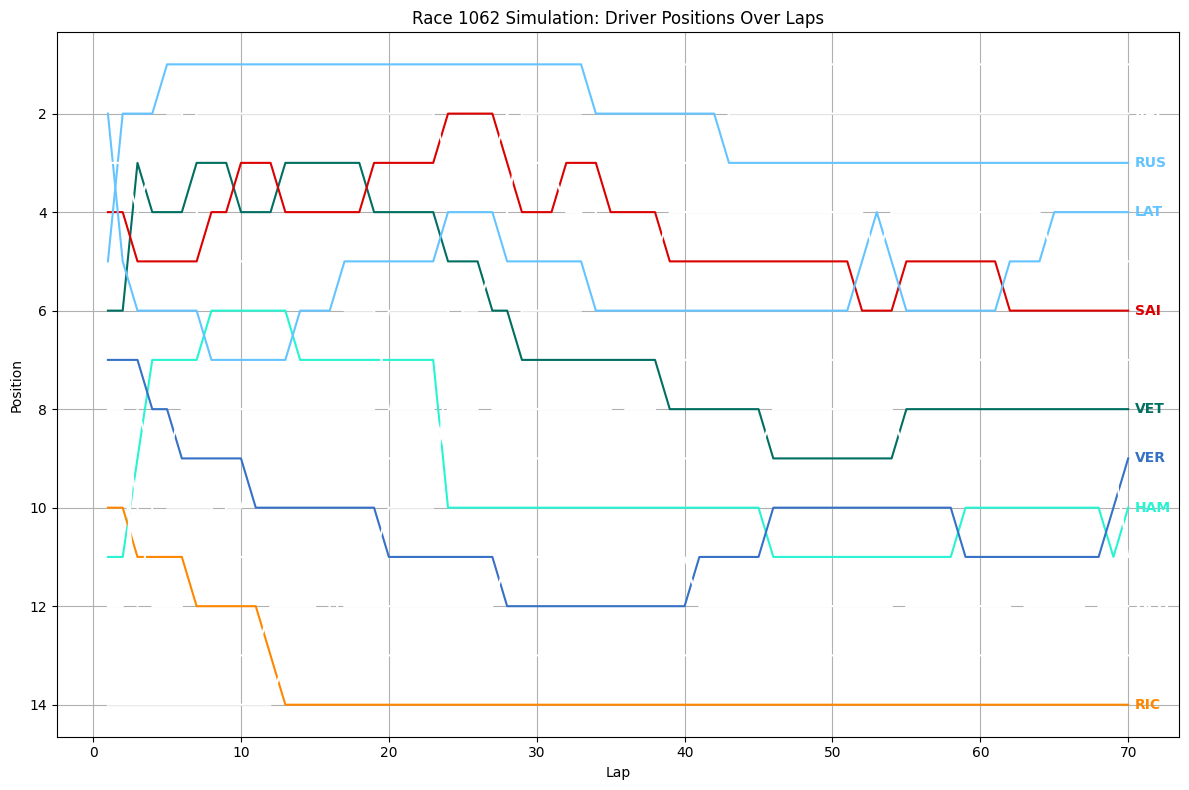

INFO:root:Lap times plot saved to plots/race_1062_times.png


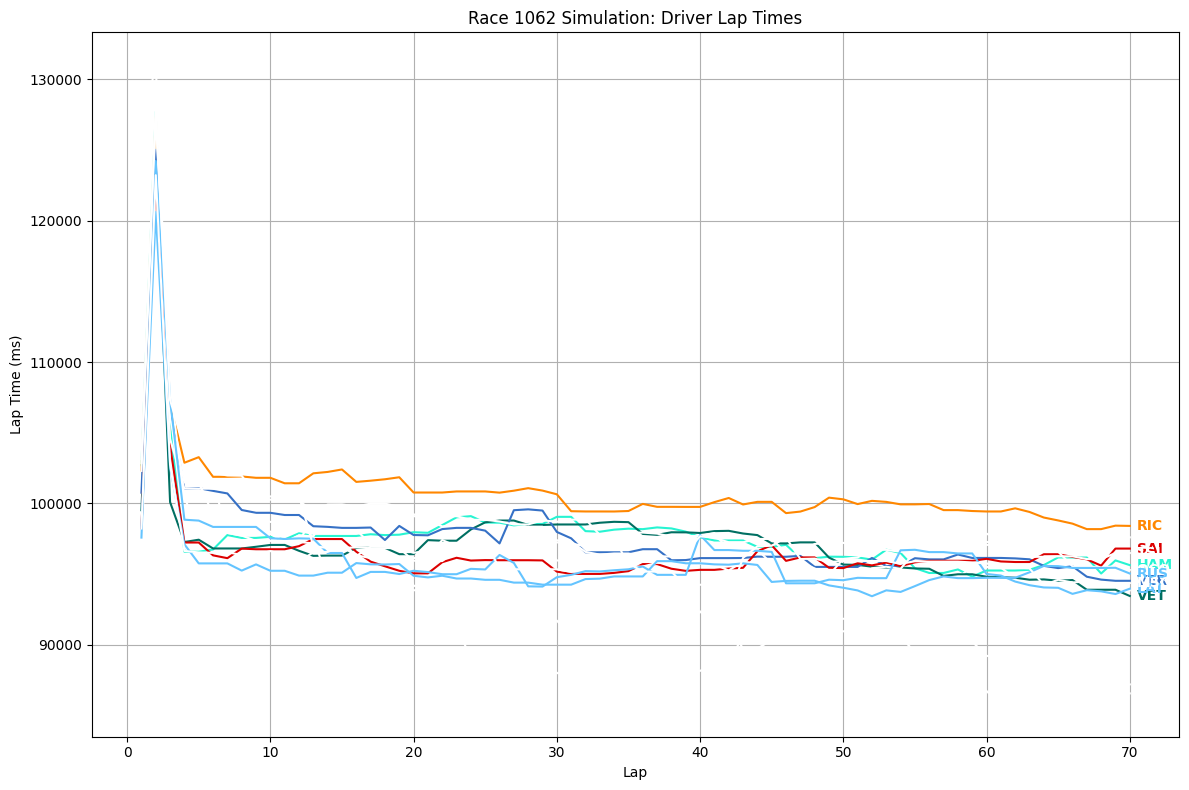

INFO:root:Evaluating race 1001
INFO:root:Initialized 17 drivers for raceId 1001
INFO:root:Simulating lap 1/44
INFO:root:Simulating lap 2/44
INFO:root:Simulating lap 3/44
INFO:root:Simulating lap 4/44
INFO:root:Simulating lap 5/44
INFO:root:Simulating lap 6/44
INFO:root:Simulating lap 7/44
INFO:root:Simulating lap 8/44
INFO:root:Simulating lap 9/44
INFO:root:Simulating lap 10/44
INFO:root:Simulating lap 11/44
INFO:root:Simulating lap 12/44
INFO:root:Simulating lap 13/44
INFO:root:Simulating lap 14/44
INFO:root:Simulating lap 15/44
INFO:root:Simulating lap 16/44
INFO:root:Simulating lap 17/44
INFO:root:Simulating lap 18/44
INFO:root:Simulating lap 19/44
INFO:root:Simulating lap 20/44
INFO:root:Simulating lap 21/44
INFO:root:Simulating lap 22/44
INFO:root:Simulating lap 23/44
INFO:root:Simulating lap 24/44
INFO:root:Simulating lap 25/44
INFO:root:Simulating lap 26/44
INFO:root:Simulating lap 27/44
INFO:root:Simulating lap 28/44
INFO:root:Simulating lap 29/44
INFO:root:Simulating lap 30/44

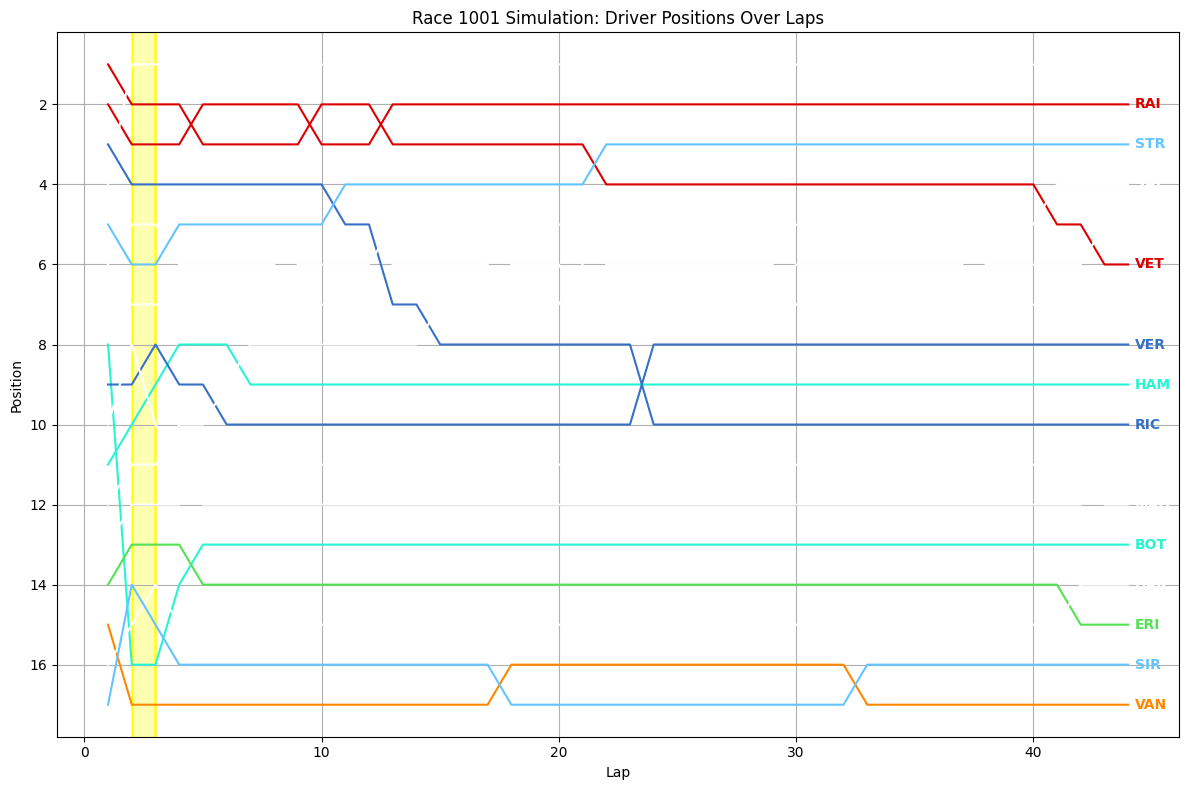

INFO:root:Lap times plot saved to plots/race_1001_times.png


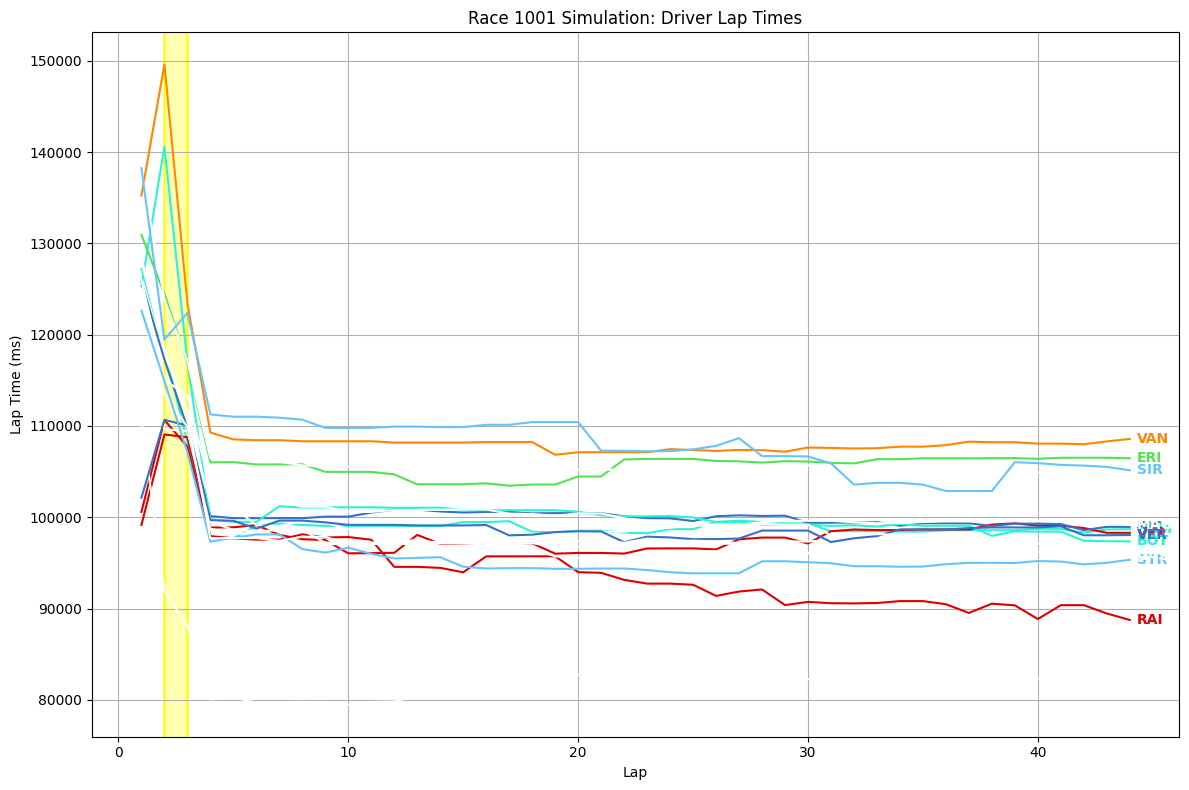

INFO:root:Evaluating race 1089
INFO:root:Initialized 20 drivers for raceId 1089
INFO:root:Simulating lap 1/52
INFO:root:Simulating lap 2/52
INFO:root:Simulating lap 3/52
INFO:root:Simulating lap 4/52
INFO:root:Simulating lap 5/52
INFO:root:Simulating lap 6/52
INFO:root:Simulating lap 7/52
INFO:root:Simulating lap 8/52
INFO:root:Simulating lap 9/52
INFO:root:Simulating lap 10/52
INFO:root:Simulating lap 11/52
INFO:root:Simulating lap 12/52
INFO:root:Simulating lap 13/52
INFO:root:Simulating lap 14/52
INFO:root:Simulating lap 15/52
INFO:root:Simulating lap 16/52
INFO:root:Simulating lap 17/52
INFO:root:Simulating lap 18/52
INFO:root:Simulating lap 19/52
INFO:root:Simulating lap 20/52
INFO:root:Simulating lap 21/52
INFO:root:Simulating lap 22/52
INFO:root:Simulating lap 23/52
INFO:root:Simulating lap 24/52
INFO:root:Simulating lap 25/52
INFO:root:Simulating lap 26/52
INFO:root:Simulating lap 27/52
INFO:root:Simulating lap 28/52
INFO:root:Simulating lap 29/52
INFO:root:Simulating lap 30/52

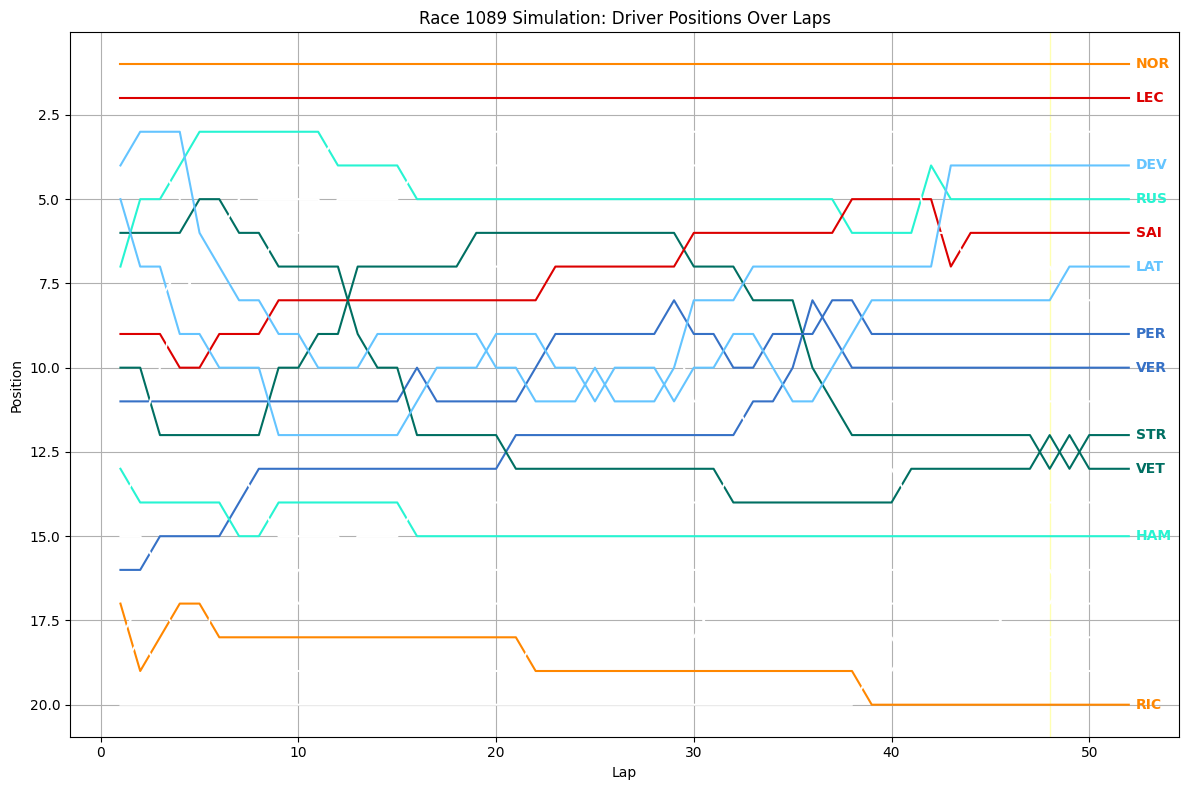

INFO:root:Lap times plot saved to plots/race_1089_times.png


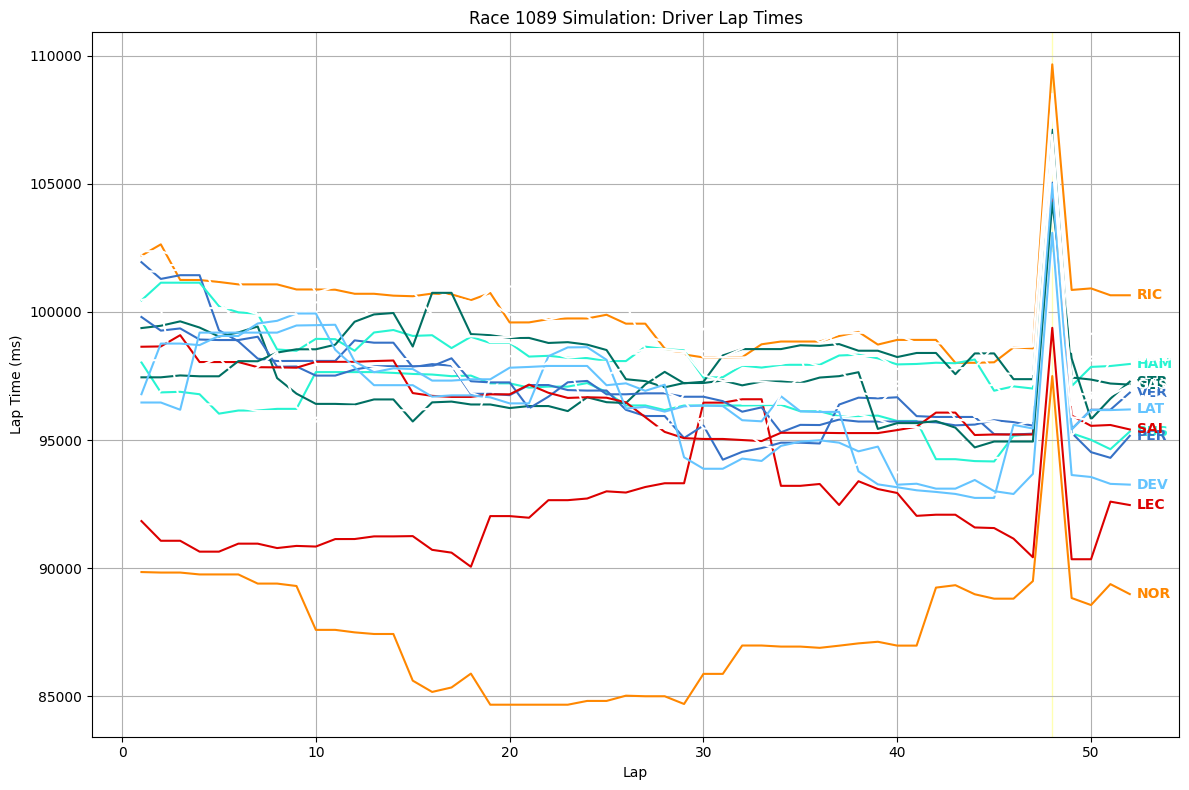

INFO:root:Evaluating race 1008
INFO:root:Initialized 20 drivers for raceId 1008
INFO:root:Simulating lap 1/71
INFO:root:Simulating lap 2/71
INFO:root:Simulating lap 3/71
INFO:root:Simulating lap 4/71
INFO:root:Simulating lap 5/71
INFO:root:Simulating lap 6/71
INFO:root:Simulating lap 7/71
INFO:root:Simulating lap 8/71
INFO:root:Simulating lap 9/71
INFO:root:Simulating lap 10/71
INFO:root:Simulating lap 11/71
INFO:root:Simulating lap 12/71
INFO:root:Simulating lap 13/71
INFO:root:Simulating lap 14/71
INFO:root:Simulating lap 15/71
INFO:root:Simulating lap 16/71
INFO:root:Simulating lap 17/71
INFO:root:Simulating lap 18/71
INFO:root:Simulating lap 19/71
INFO:root:Simulating lap 20/71
INFO:root:Simulating lap 21/71
INFO:root:Simulating lap 22/71
INFO:root:Simulating lap 23/71
INFO:root:Simulating lap 24/71
INFO:root:Simulating lap 25/71
INFO:root:Simulating lap 26/71
INFO:root:Simulating lap 27/71
INFO:root:Simulating lap 28/71
INFO:root:Simulating lap 29/71
INFO:root:Simulating lap 30/71

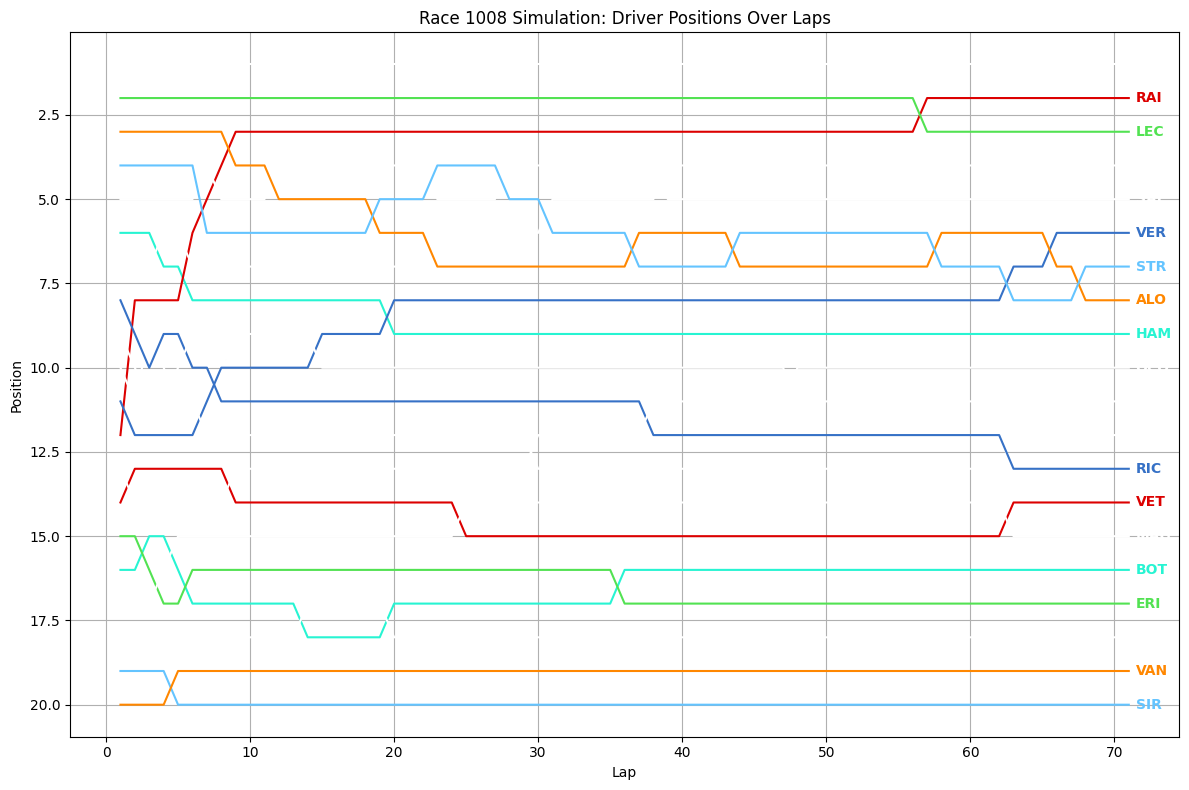

INFO:root:Lap times plot saved to plots/race_1008_times.png


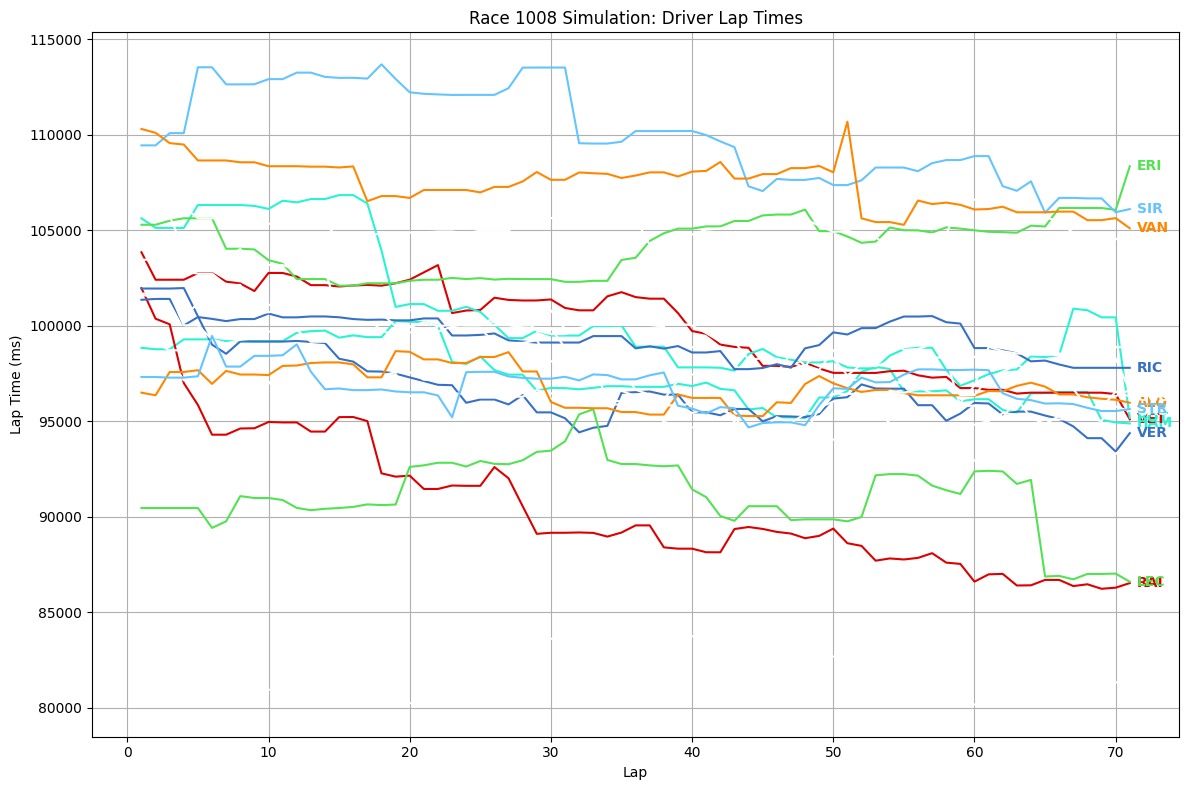

INFO:root:Evaluating race 1077
INFO:root:Initialized 18 drivers for raceId 1077
INFO:root:Simulating lap 1/63
INFO:root:Simulating lap 2/63
INFO:root:Simulating lap 3/63
INFO:root:Simulating lap 4/63
INFO:root:Simulating lap 5/63
INFO:root:Simulating lap 6/63
INFO:root:Simulating lap 7/63
INFO:root:Simulating lap 8/63
INFO:root:Simulating lap 9/63
INFO:root:Simulating lap 10/63
INFO:root:Simulating lap 11/63
INFO:root:Simulating lap 12/63
INFO:root:Simulating lap 13/63
INFO:root:Simulating lap 14/63
INFO:root:Simulating lap 15/63
INFO:root:Simulating lap 16/63
INFO:root:Simulating lap 17/63
INFO:root:Simulating lap 18/63
INFO:root:Simulating lap 19/63
INFO:root:Simulating lap 20/63
INFO:root:Simulating lap 21/63
INFO:root:Simulating lap 22/63
INFO:root:Simulating lap 23/63
INFO:root:Simulating lap 24/63
INFO:root:Simulating lap 25/63
INFO:root:Simulating lap 26/63
INFO:root:Simulating lap 27/63
INFO:root:Simulating lap 28/63
INFO:root:Simulating lap 29/63
INFO:root:Simulating lap 30/63

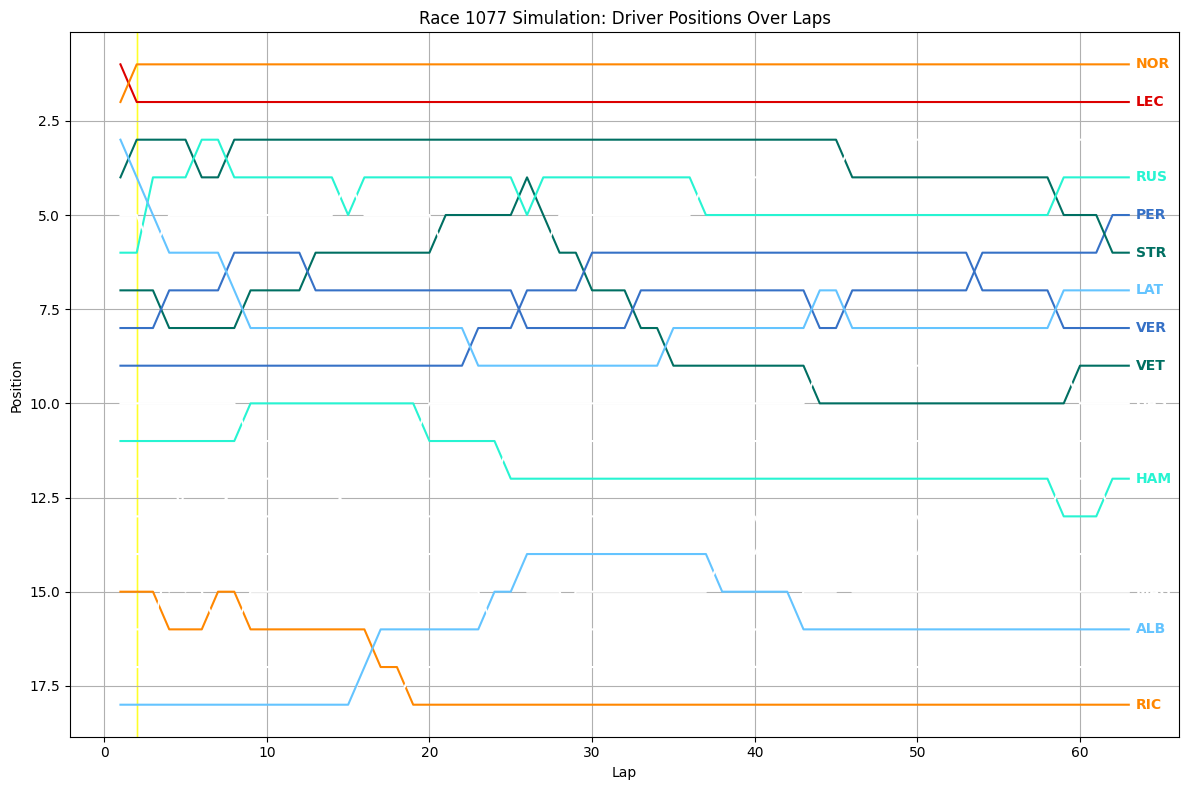

INFO:root:Lap times plot saved to plots/race_1077_times.png


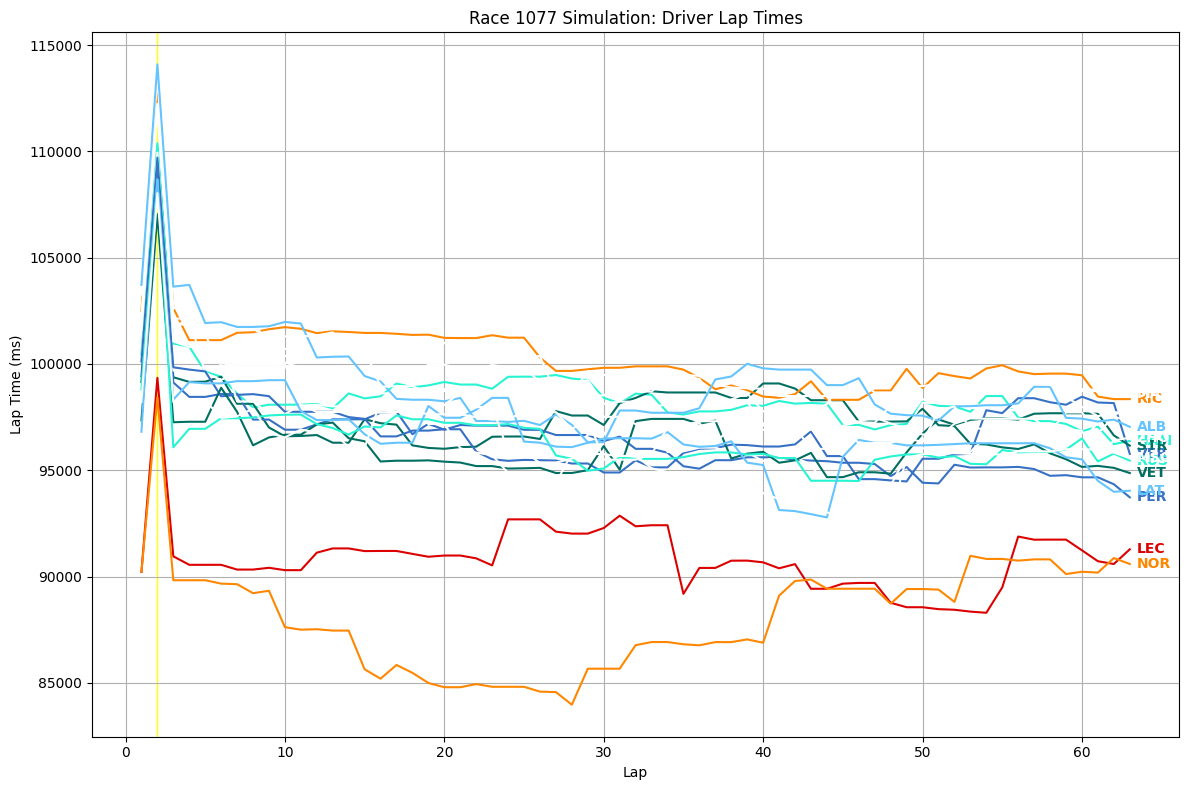

INFO:root:Evaluating race 1073
INFO:root:Initialized 19 drivers for raceId 1073
INFO:root:Simulating lap 1/58
INFO:root:Simulating lap 2/58
INFO:root:Simulating lap 3/58
INFO:root:Simulating lap 4/58
INFO:root:Simulating lap 5/58
INFO:root:Simulating lap 6/58
INFO:root:Simulating lap 7/58
INFO:root:Simulating lap 8/58
INFO:root:Simulating lap 9/58
INFO:root:Simulating lap 10/58
INFO:root:Simulating lap 11/58
INFO:root:Simulating lap 12/58
INFO:root:Simulating lap 13/58
INFO:root:Simulating lap 14/58
INFO:root:Simulating lap 15/58
INFO:root:Simulating lap 16/58
INFO:root:Simulating lap 17/58
INFO:root:Simulating lap 18/58
INFO:root:Simulating lap 19/58
INFO:root:Simulating lap 20/58
INFO:root:Simulating lap 21/58
INFO:root:Simulating lap 22/58
INFO:root:Simulating lap 23/58
INFO:root:Simulating lap 24/58
INFO:root:Simulating lap 25/58
INFO:root:Simulating lap 26/58
INFO:root:Simulating lap 27/58
INFO:root:Simulating lap 28/58
INFO:root:Simulating lap 29/58
INFO:root:Simulating lap 30/58

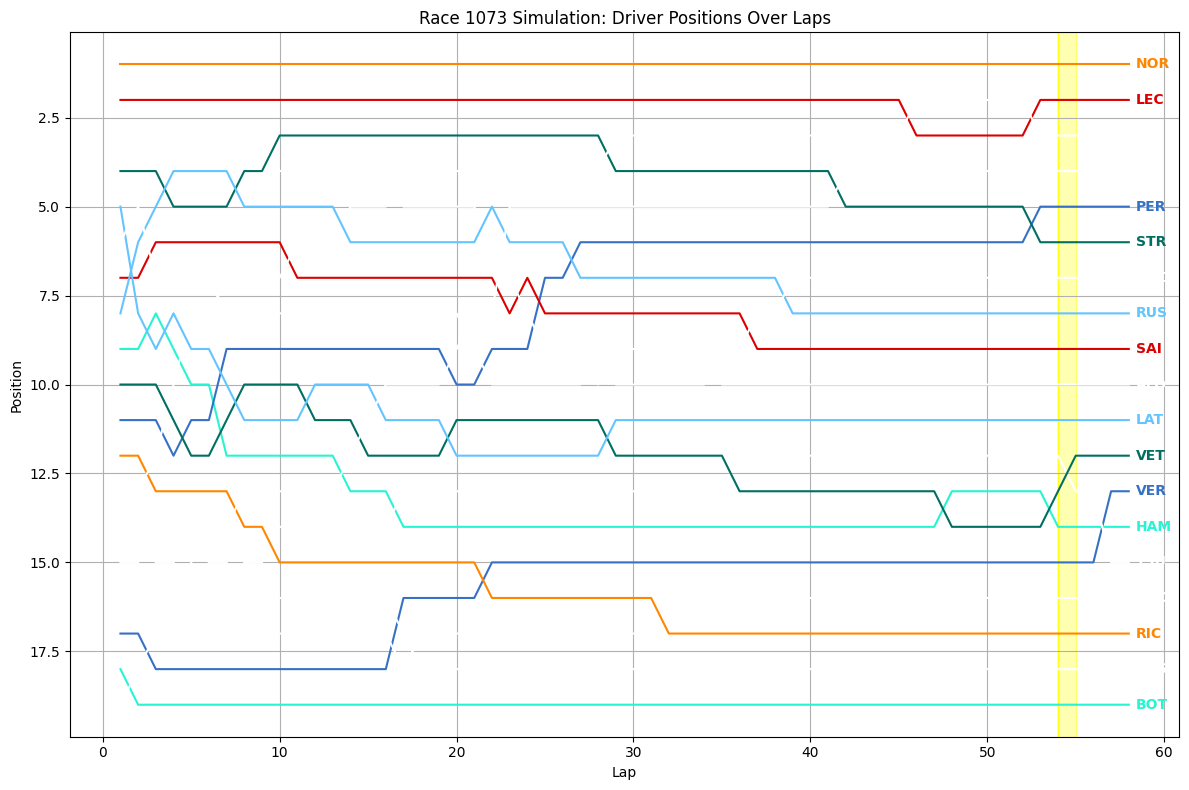

INFO:root:Lap times plot saved to plots/race_1073_times.png


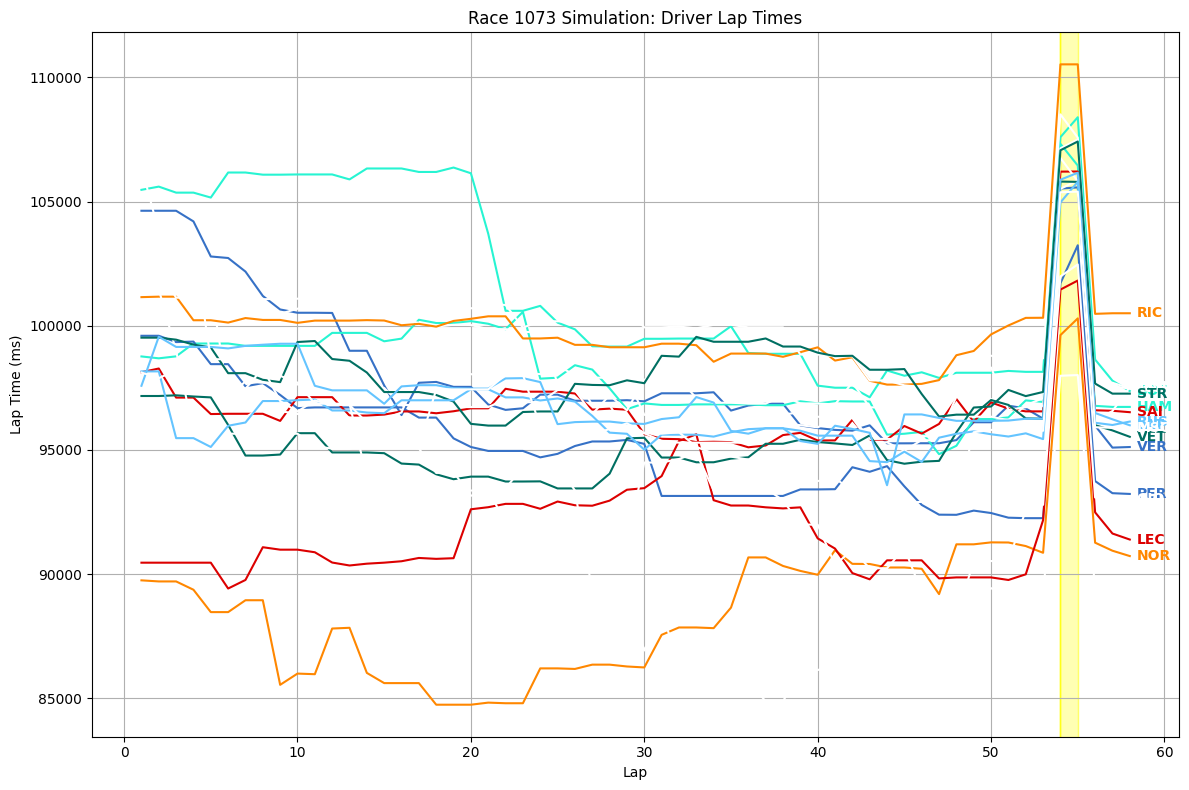

INFO:root:Evaluating race 1096
INFO:root:Initialized 20 drivers for raceId 1096
INFO:root:Simulating lap 1/58
INFO:root:Simulating lap 2/58
INFO:root:Simulating lap 3/58
INFO:root:Simulating lap 4/58
INFO:root:Simulating lap 5/58
INFO:root:Simulating lap 6/58
INFO:root:Simulating lap 7/58
INFO:root:Simulating lap 8/58
INFO:root:Simulating lap 9/58
INFO:root:Simulating lap 10/58
INFO:root:Simulating lap 11/58
INFO:root:Simulating lap 12/58
INFO:root:Simulating lap 13/58
INFO:root:Simulating lap 14/58
INFO:root:Simulating lap 15/58
INFO:root:Simulating lap 16/58
INFO:root:Simulating lap 17/58
INFO:root:Simulating lap 18/58
INFO:root:Simulating lap 19/58
INFO:root:Simulating lap 20/58
INFO:root:Simulating lap 21/58
INFO:root:Simulating lap 22/58
INFO:root:Simulating lap 23/58
INFO:root:Simulating lap 24/58
INFO:root:Simulating lap 25/58
INFO:root:Simulating lap 26/58
INFO:root:Simulating lap 27/58
INFO:root:Simulating lap 28/58
INFO:root:Simulating lap 29/58
INFO:root:Simulating lap 30/58

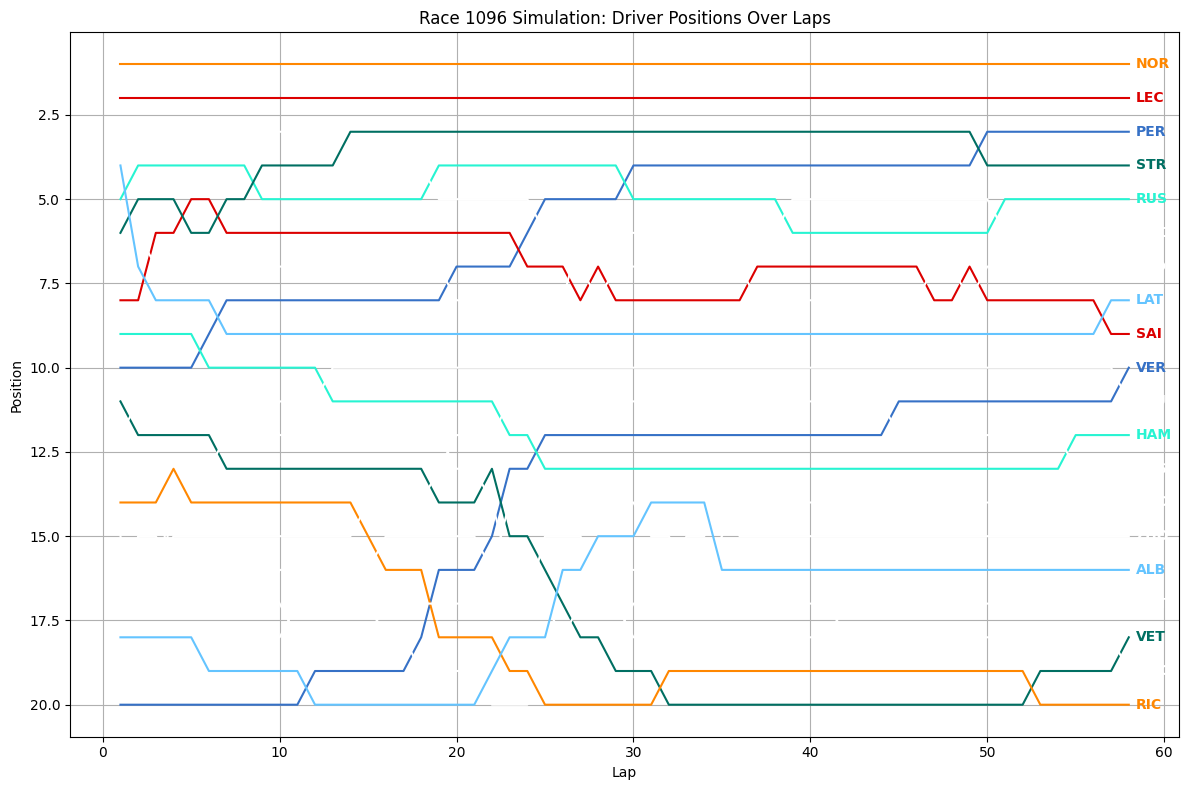

INFO:root:Lap times plot saved to plots/race_1096_times.png


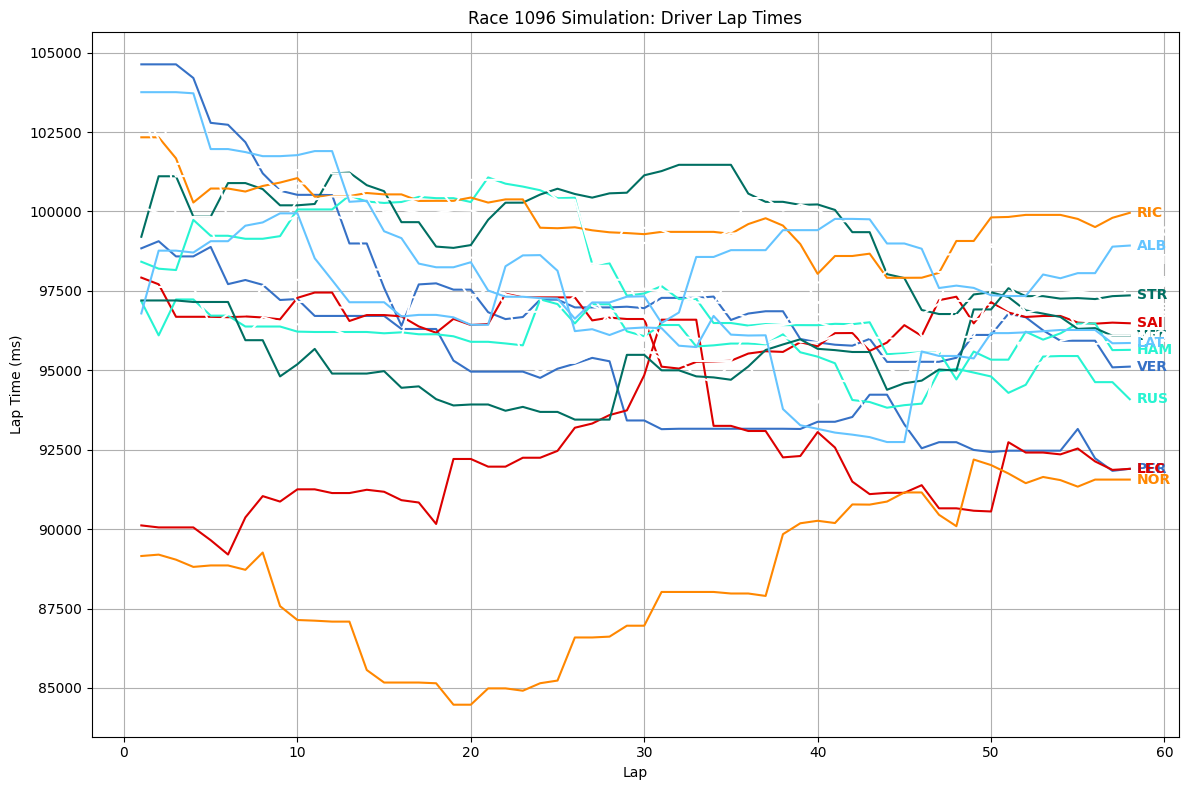

INFO:root:Evaluating race 1007
INFO:root:Initialized 20 drivers for raceId 1007
INFO:root:Simulating lap 1/71
INFO:root:Simulating lap 2/71
INFO:root:Simulating lap 3/71
INFO:root:Simulating lap 4/71
INFO:root:Simulating lap 5/71
INFO:root:Simulating lap 6/71
INFO:root:Simulating lap 7/71
INFO:root:Simulating lap 8/71
INFO:root:Simulating lap 9/71
INFO:root:Simulating lap 10/71
INFO:root:Simulating lap 11/71
INFO:root:Simulating lap 12/71
INFO:root:Simulating lap 13/71
INFO:root:Simulating lap 14/71
INFO:root:Simulating lap 15/71
INFO:root:Simulating lap 16/71
INFO:root:Simulating lap 17/71
INFO:root:Simulating lap 18/71
INFO:root:Simulating lap 19/71
INFO:root:Simulating lap 20/71
INFO:root:Simulating lap 21/71
INFO:root:Simulating lap 22/71
INFO:root:Simulating lap 23/71
INFO:root:Simulating lap 24/71
INFO:root:Simulating lap 25/71
INFO:root:Simulating lap 26/71
INFO:root:Simulating lap 27/71
INFO:root:Simulating lap 28/71
INFO:root:Simulating lap 29/71
INFO:root:Simulating lap 30/71

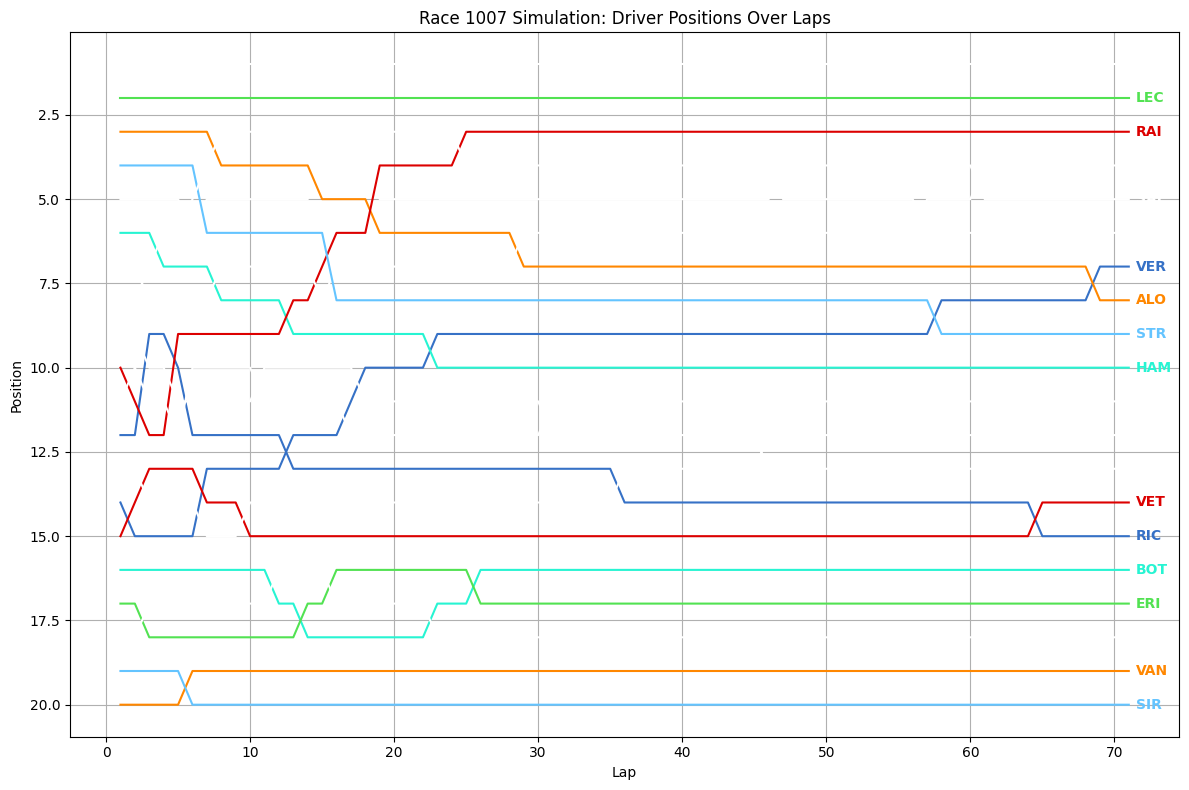

INFO:root:Lap times plot saved to plots/race_1007_times.png


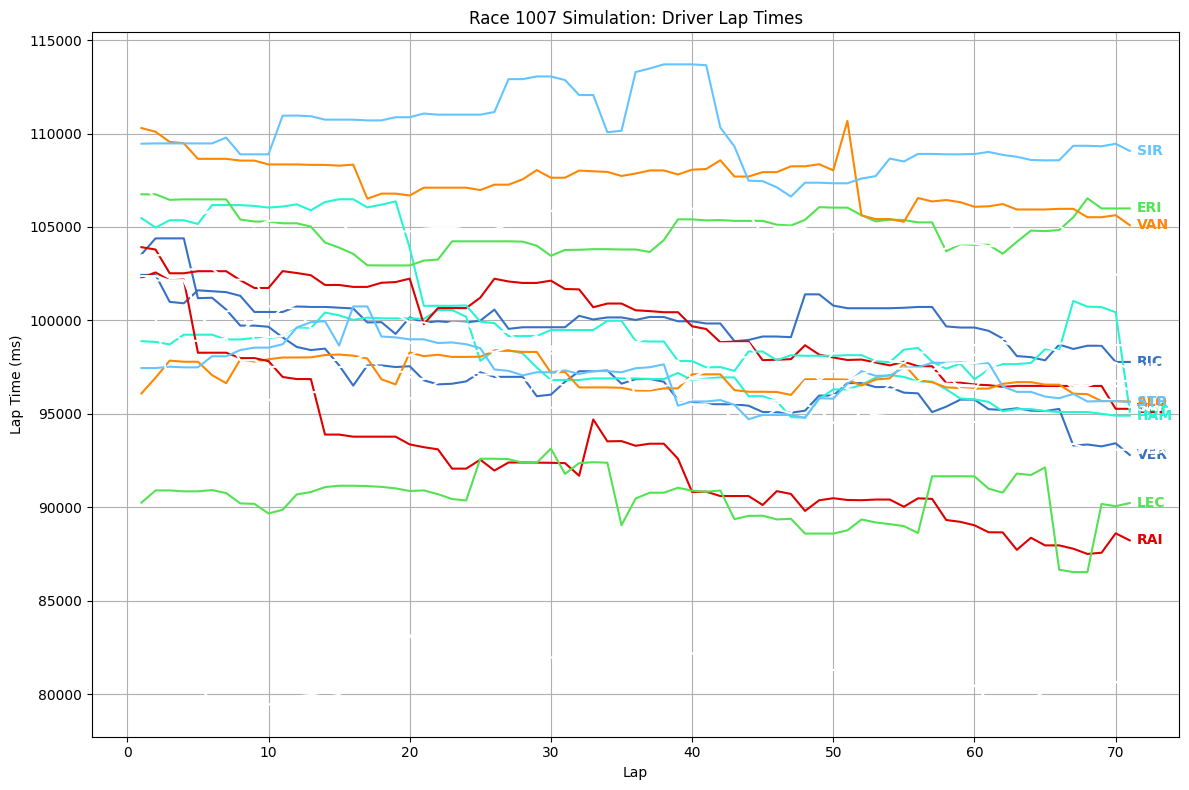

INFO:root:Evaluating race 1117
INFO:root:Initialized 18 drivers for raceId 1117
INFO:root:Simulating lap 1/71
INFO:root:Simulating lap 2/71
INFO:root:Simulating lap 3/71
INFO:root:Simulating lap 4/71
INFO:root:Simulating lap 5/71
INFO:root:Simulating lap 6/71
INFO:root:Simulating lap 7/71
INFO:root:Simulating lap 8/71
INFO:root:Simulating lap 9/71
INFO:root:Simulating lap 10/71
INFO:root:Simulating lap 11/71
INFO:root:Simulating lap 12/71
INFO:root:Simulating lap 13/71
INFO:root:Simulating lap 14/71
INFO:root:Simulating lap 15/71
INFO:root:Simulating lap 16/71
INFO:root:Simulating lap 17/71
INFO:root:Simulating lap 18/71
INFO:root:Simulating lap 19/71
INFO:root:Simulating lap 20/71
INFO:root:Simulating lap 21/71
INFO:root:Simulating lap 22/71
INFO:root:Simulating lap 23/71
INFO:root:Simulating lap 24/71
INFO:root:Simulating lap 25/71
INFO:root:Simulating lap 26/71
INFO:root:Simulating lap 27/71
INFO:root:Simulating lap 28/71
INFO:root:Simulating lap 29/71
INFO:root:Simulating lap 30/71

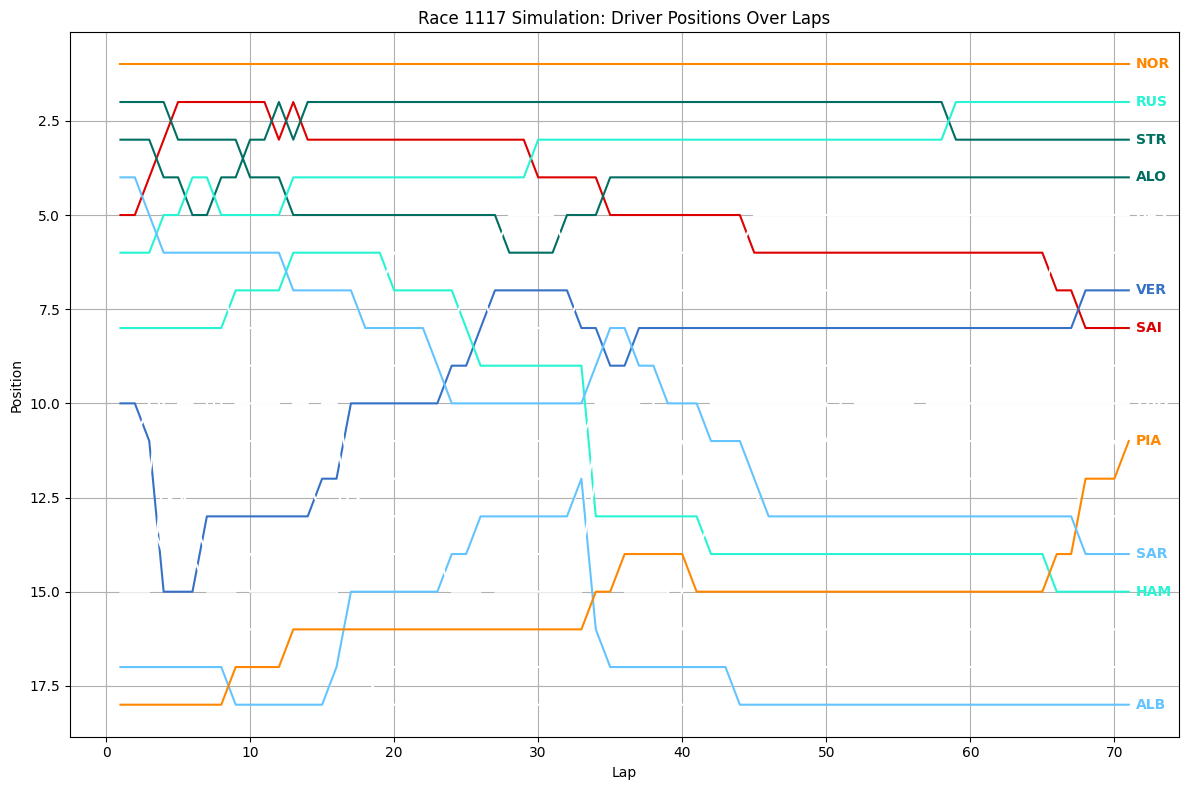

INFO:root:Lap times plot saved to plots/race_1117_times.png


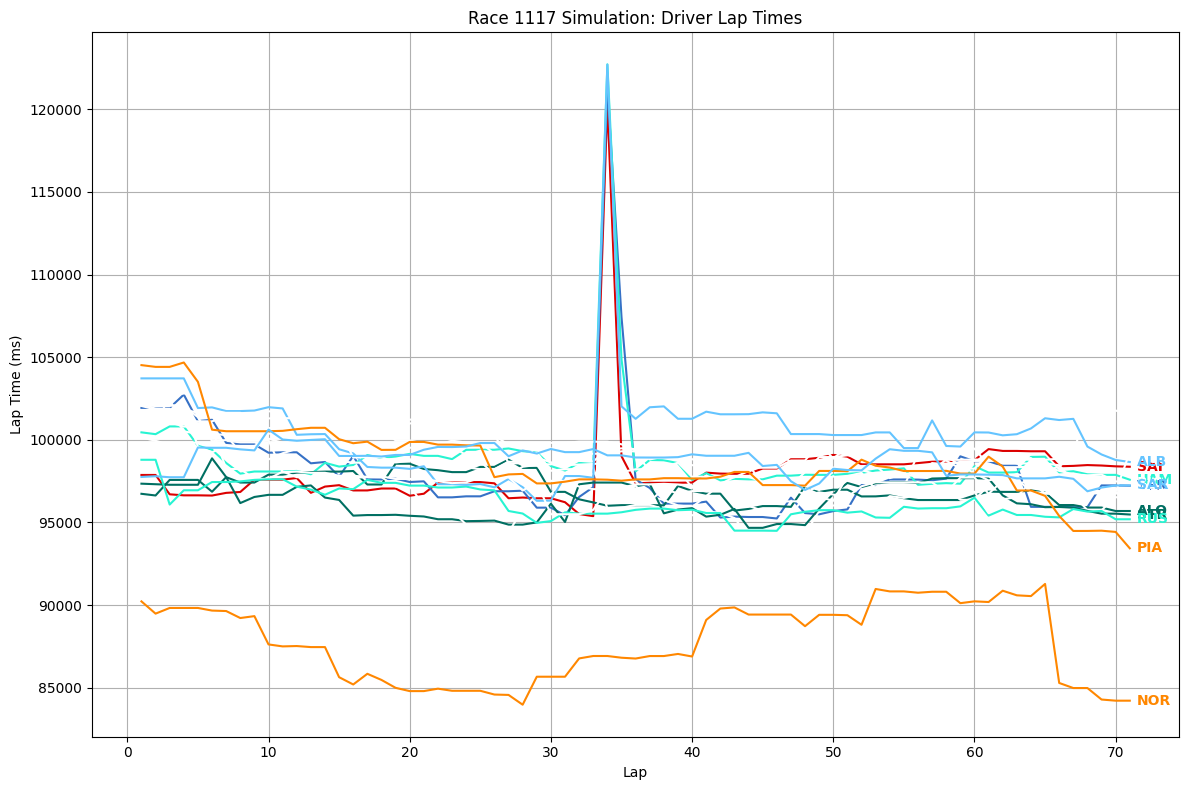

INFO:root:Evaluating race 1059
INFO:root:Initialized 19 drivers for raceId 1059
INFO:root:Simulating lap 1/53
INFO:root:Simulating lap 2/53
INFO:root:Simulating lap 3/53
INFO:root:Simulating lap 4/53
INFO:root:Simulating lap 5/53
INFO:root:Simulating lap 6/53
INFO:root:Simulating lap 7/53
INFO:root:Simulating lap 8/53
INFO:root:Simulating lap 9/53
INFO:root:Simulating lap 10/53
INFO:root:Simulating lap 11/53
INFO:root:Simulating lap 12/53
INFO:root:Simulating lap 13/53
INFO:root:Simulating lap 14/53
INFO:root:Simulating lap 15/53
INFO:root:Simulating lap 16/53
INFO:root:Simulating lap 17/53
INFO:root:Simulating lap 18/53
INFO:root:Simulating lap 19/53
INFO:root:Simulating lap 20/53
INFO:root:Simulating lap 21/53
INFO:root:Simulating lap 22/53
INFO:root:Simulating lap 23/53
INFO:root:Simulating lap 24/53
INFO:root:Simulating lap 25/53
INFO:root:Simulating lap 26/53
INFO:root:Simulating lap 27/53
INFO:root:Simulating lap 28/53
INFO:root:Simulating lap 29/53
INFO:root:Simulating lap 30/53

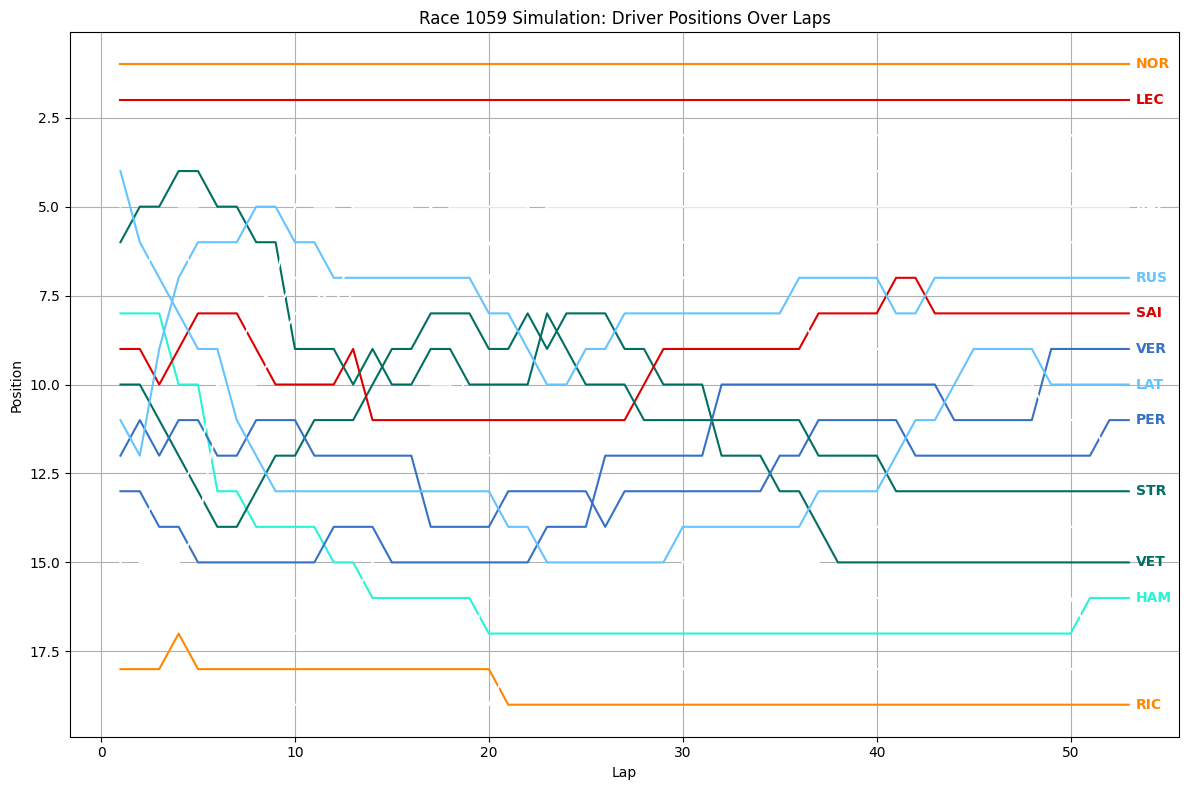

INFO:root:Lap times plot saved to plots/race_1059_times.png


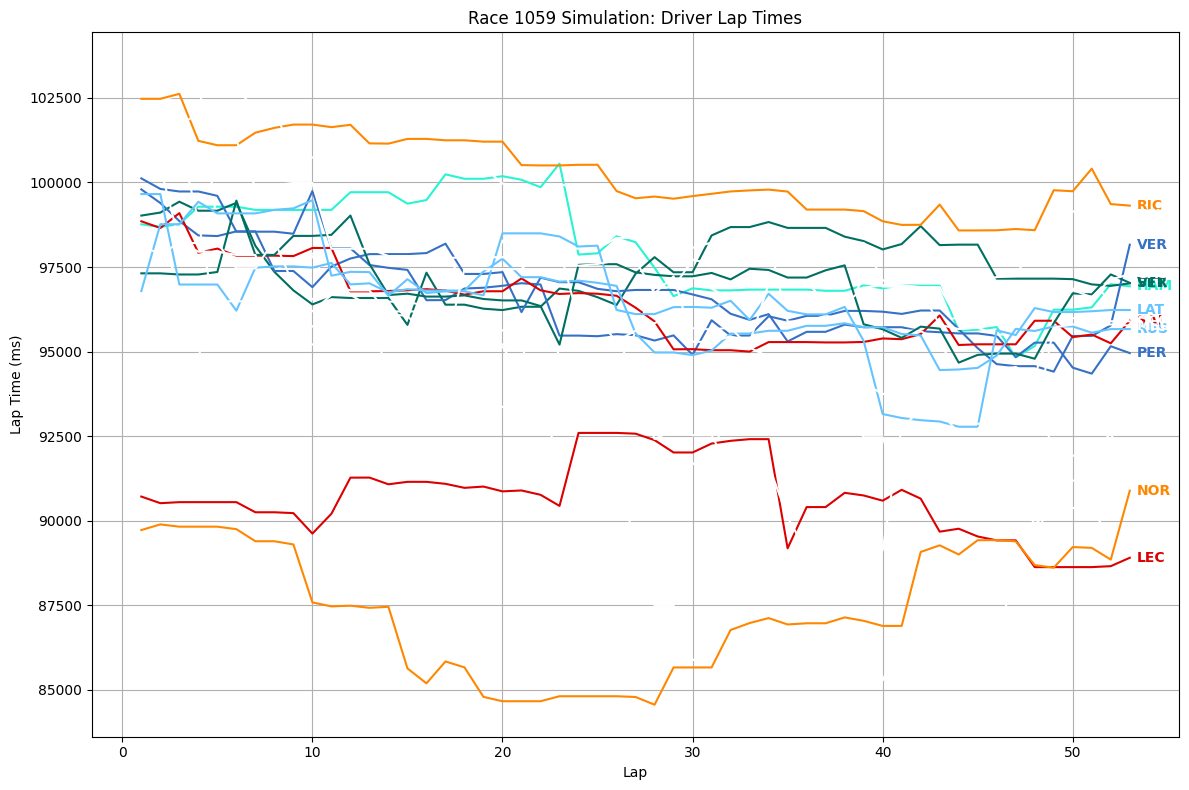

INFO:root:Evaluating race 1111
INFO:root:Initialized 20 drivers for raceId 1111
INFO:root:Simulating lap 1/72
INFO:root:Simulating lap 2/72
INFO:root:Simulating lap 3/72
INFO:root:Simulating lap 4/72
INFO:root:Simulating lap 5/72
INFO:root:Simulating lap 6/72
INFO:root:Simulating lap 7/72
INFO:root:Simulating lap 8/72
INFO:root:Simulating lap 9/72
INFO:root:Simulating lap 10/72
INFO:root:Simulating lap 11/72
INFO:root:Simulating lap 12/72
INFO:root:Simulating lap 13/72
INFO:root:Simulating lap 14/72
INFO:root:Simulating lap 15/72
INFO:root:Simulating lap 16/72
INFO:root:Simulating lap 17/72
INFO:root:Simulating lap 18/72
INFO:root:Simulating lap 19/72
INFO:root:Simulating lap 20/72
INFO:root:Simulating lap 21/72
INFO:root:Simulating lap 22/72
INFO:root:Simulating lap 23/72
INFO:root:Simulating lap 24/72
INFO:root:Simulating lap 25/72
INFO:root:Simulating lap 26/72
INFO:root:Simulating lap 27/72
INFO:root:Simulating lap 28/72
INFO:root:Simulating lap 29/72
INFO:root:Simulating lap 30/72

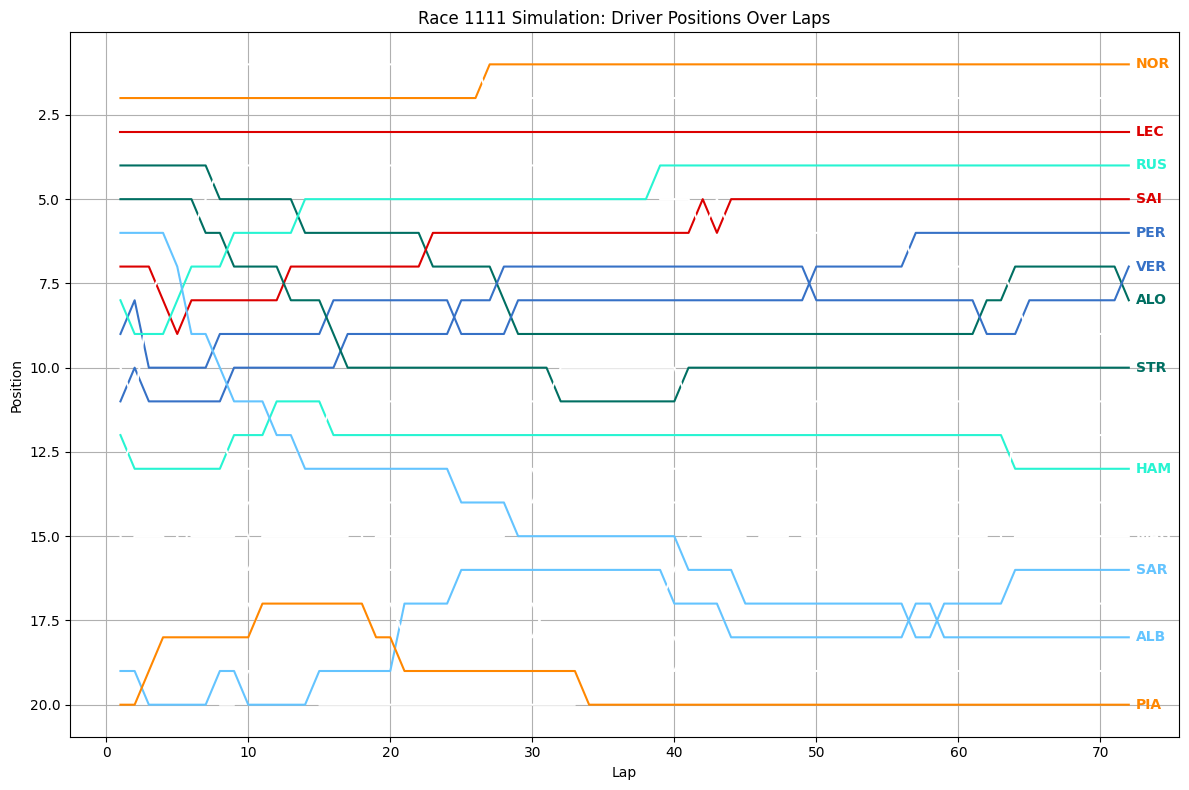

INFO:root:Lap times plot saved to plots/race_1111_times.png


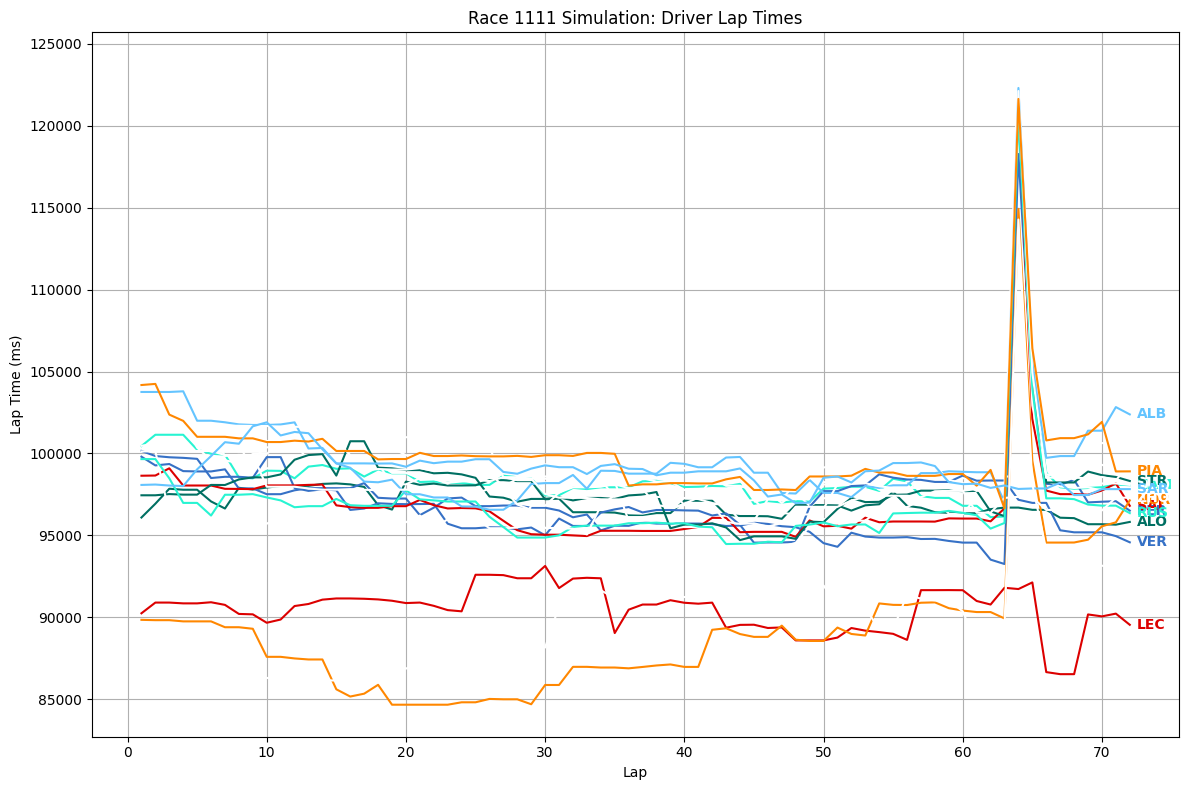

INFO:root:Evaluating race 1093
INFO:root:Initialized 19 drivers for raceId 1093
INFO:root:Simulating lap 1/56
INFO:root:Simulating lap 2/56
INFO:root:Simulating lap 3/56
INFO:root:Simulating lap 4/56
INFO:root:Simulating lap 5/56
INFO:root:Simulating lap 6/56
INFO:root:Simulating lap 7/56
INFO:root:Simulating lap 8/56
INFO:root:Simulating lap 9/56
INFO:root:Simulating lap 10/56
INFO:root:Simulating lap 11/56
INFO:root:Simulating lap 12/56
INFO:root:Simulating lap 13/56
INFO:root:Simulating lap 14/56
INFO:root:Simulating lap 15/56
INFO:root:Simulating lap 16/56
INFO:root:Simulating lap 17/56
INFO:root:Simulating lap 18/56
INFO:root:Simulating lap 19/56
INFO:root:Simulating lap 20/56
INFO:root:Simulating lap 21/56
INFO:root:Simulating lap 22/56
INFO:root:Simulating lap 23/56
INFO:root:Simulating lap 24/56
INFO:root:Simulating lap 25/56
INFO:root:Simulating lap 26/56
INFO:root:Simulating lap 27/56
INFO:root:Simulating lap 28/56
INFO:root:Simulating lap 29/56
INFO:root:Simulating lap 30/56

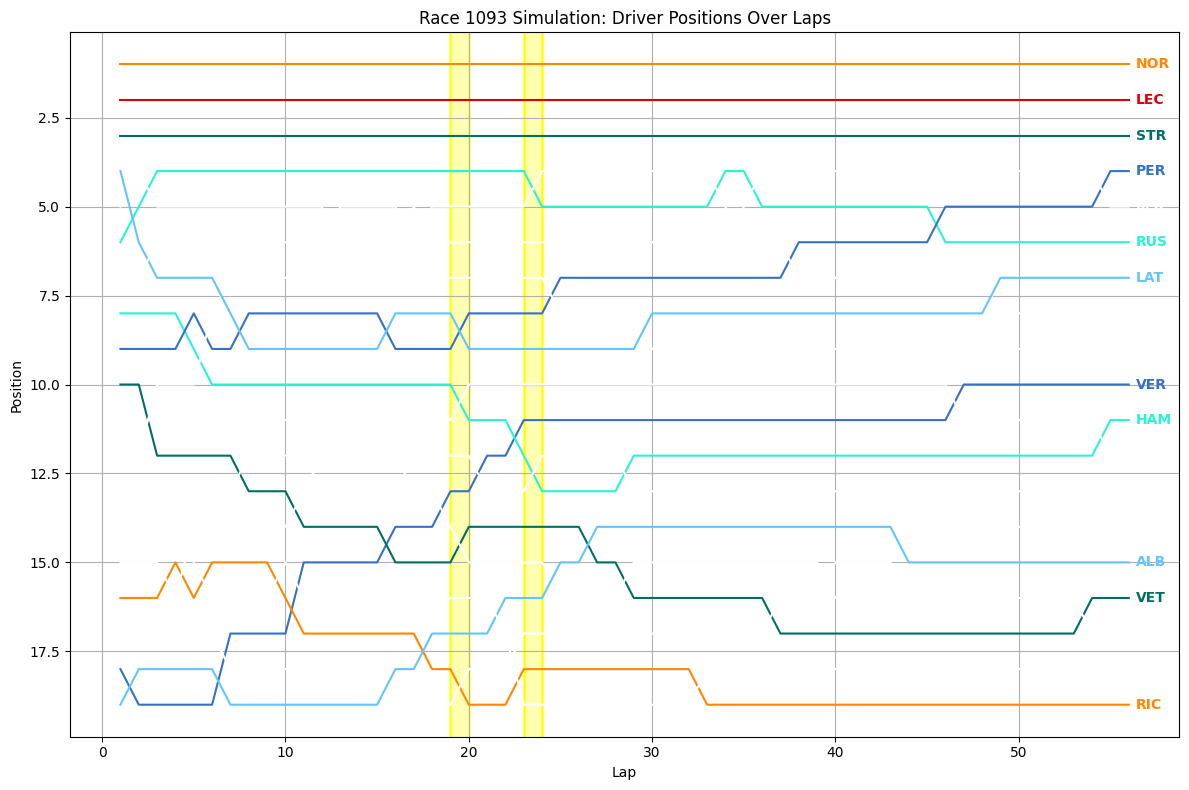

INFO:root:Lap times plot saved to plots/race_1093_times.png


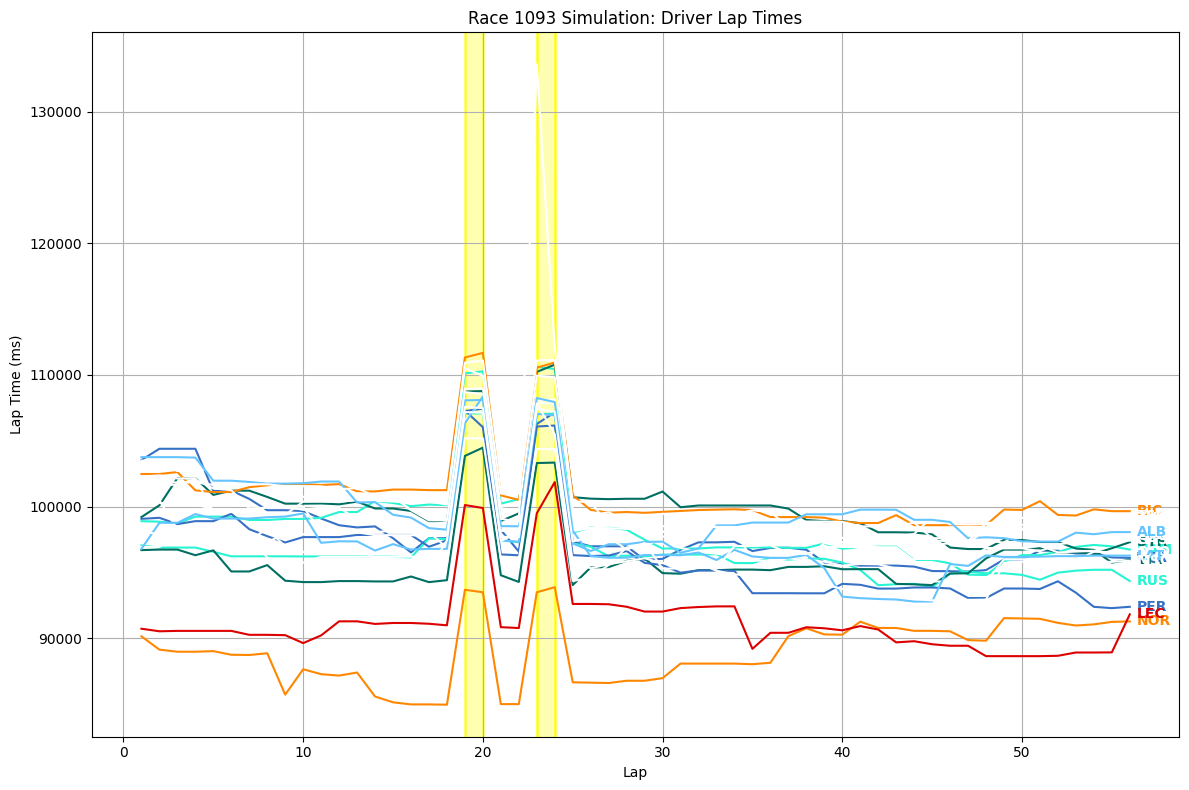

INFO:root:Evaluating race 1058
INFO:root:Initialized 18 drivers for raceId 1058
INFO:root:Simulating lap 1/71
INFO:root:Simulating lap 2/71
INFO:root:Simulating lap 3/71
INFO:root:Simulating lap 4/71
INFO:root:Simulating lap 5/71
INFO:root:Simulating lap 6/71
INFO:root:Simulating lap 7/71
INFO:root:Simulating lap 8/71
INFO:root:Simulating lap 9/71
INFO:root:Simulating lap 10/71
INFO:root:Simulating lap 11/71
INFO:root:Simulating lap 12/71
INFO:root:Simulating lap 13/71
INFO:root:Simulating lap 14/71
INFO:root:Simulating lap 15/71
INFO:root:Simulating lap 16/71
INFO:root:Simulating lap 17/71
INFO:root:Simulating lap 18/71
INFO:root:Simulating lap 19/71
INFO:root:Simulating lap 20/71
INFO:root:Simulating lap 21/71
INFO:root:Simulating lap 22/71
INFO:root:Simulating lap 23/71
INFO:root:Simulating lap 24/71
INFO:root:Simulating lap 25/71
INFO:root:Simulating lap 26/71
INFO:root:Simulating lap 27/71
INFO:root:Simulating lap 28/71
INFO:root:Simulating lap 29/71
INFO:root:Simulating lap 30/71

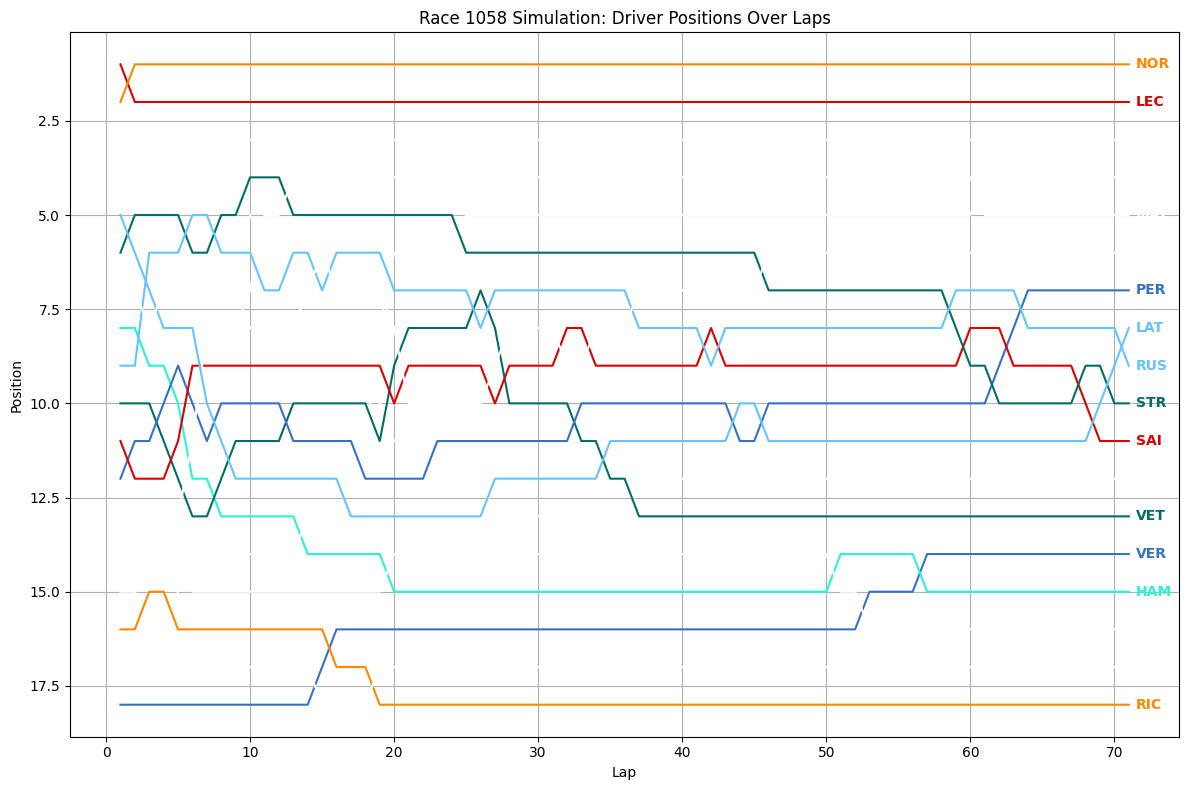

INFO:root:Lap times plot saved to plots/race_1058_times.png


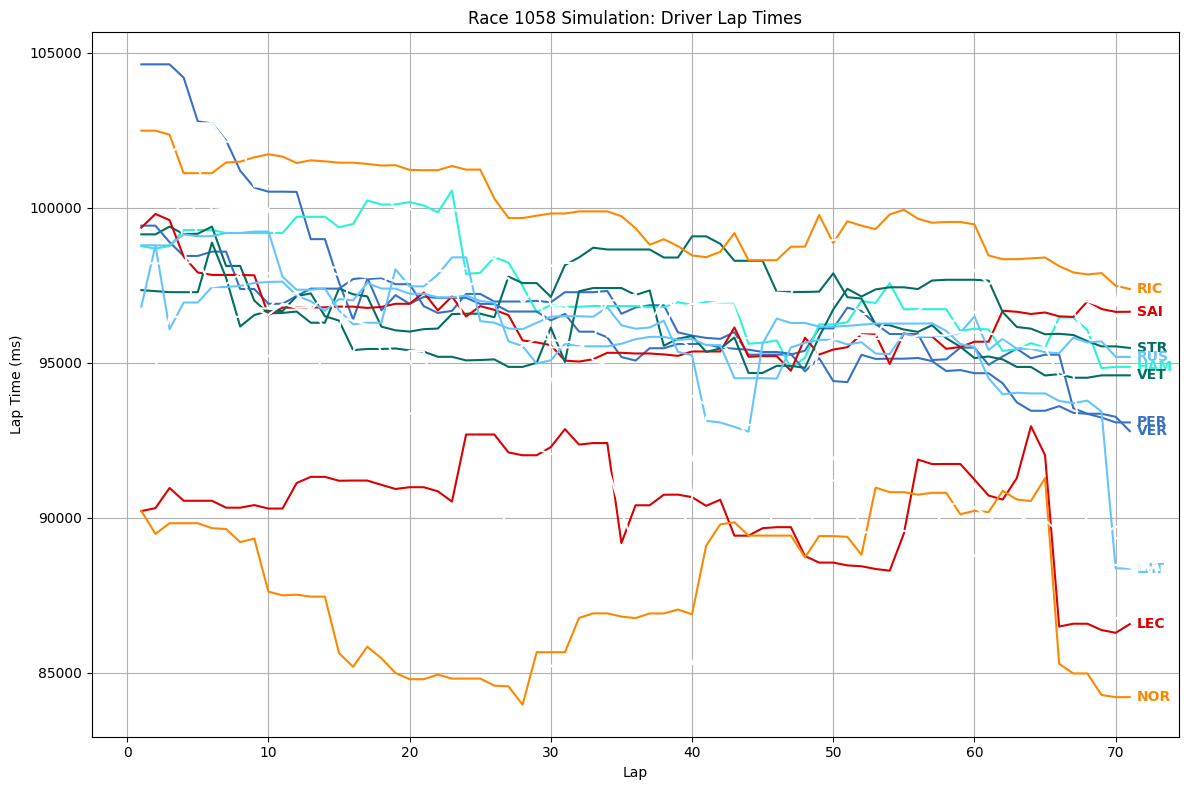

INFO:root:Evaluating race 1131
INFO:root:Initialized 20 drivers for raceId 1131
INFO:root:Simulating lap 1/71
INFO:root:Simulating lap 2/71
INFO:root:Simulating lap 3/71
INFO:root:Simulating lap 4/71
INFO:root:Simulating lap 5/71
INFO:root:Simulating lap 6/71
INFO:root:Simulating lap 7/71
INFO:root:Simulating lap 8/71
INFO:root:Simulating lap 9/71
INFO:root:Simulating lap 10/71
INFO:root:Simulating lap 11/71
INFO:root:Simulating lap 12/71
INFO:root:Simulating lap 13/71
INFO:root:Simulating lap 14/71
INFO:root:Simulating lap 15/71
INFO:root:Simulating lap 16/71
INFO:root:Simulating lap 17/71
INFO:root:Simulating lap 18/71
INFO:root:Simulating lap 19/71
INFO:root:Simulating lap 20/71
INFO:root:Simulating lap 21/71
INFO:root:Simulating lap 22/71
INFO:root:Simulating lap 23/71
INFO:root:Simulating lap 24/71
INFO:root:Simulating lap 25/71
INFO:root:Simulating lap 26/71
INFO:root:Simulating lap 27/71
INFO:root:Simulating lap 28/71
INFO:root:Simulating lap 29/71
INFO:root:Simulating lap 30/71

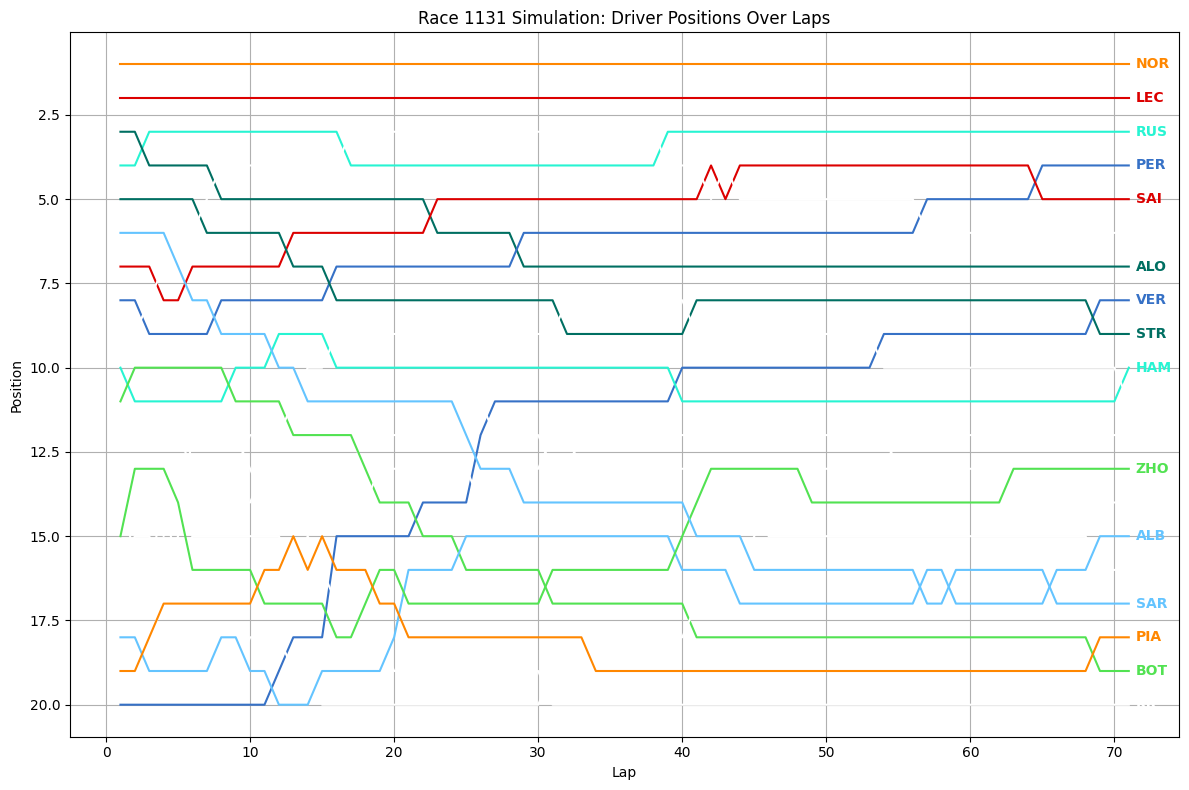

INFO:root:Lap times plot saved to plots/race_1131_times.png


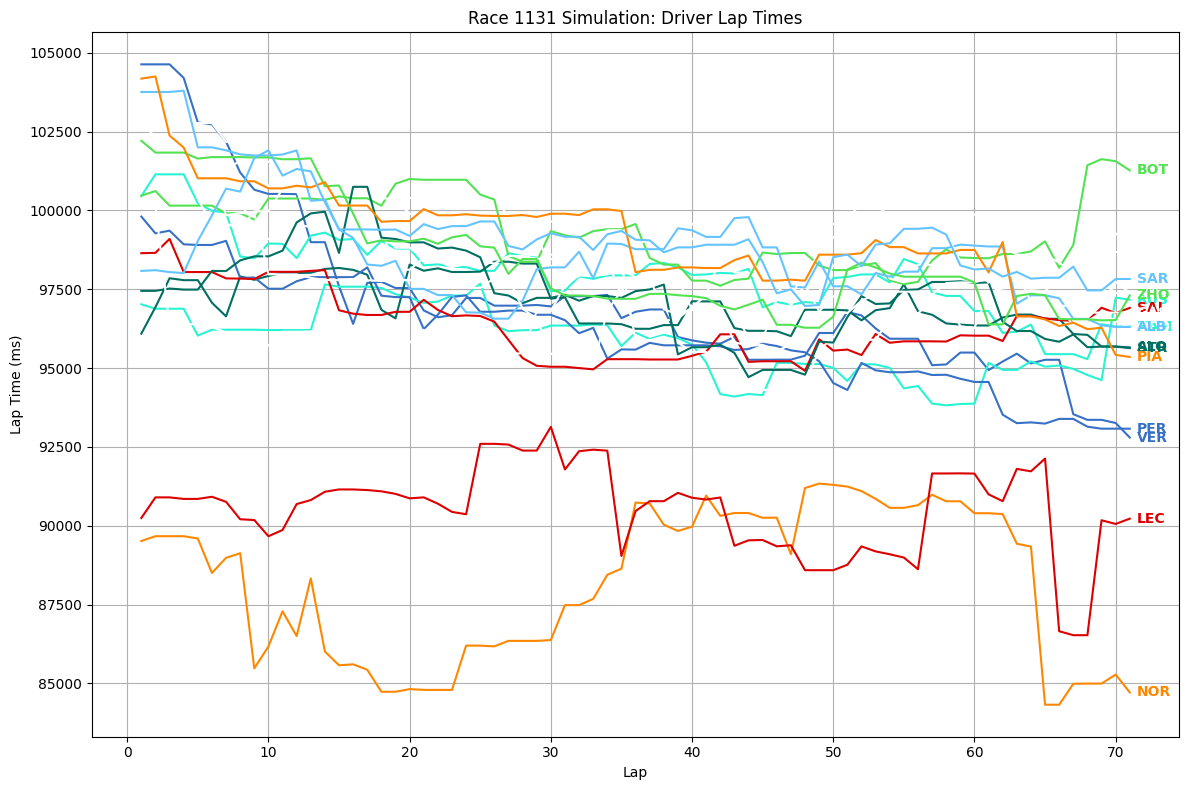

INFO:root:Evaluating race 1040
INFO:root:Initialized 18 drivers for raceId 1040
INFO:root:Simulating lap 1/53
INFO:root:Simulating lap 2/53
INFO:root:Simulating lap 3/53
INFO:root:Simulating lap 4/53
INFO:root:Simulating lap 5/53
INFO:root:Simulating lap 6/53
INFO:root:Simulating lap 7/53
INFO:root:Simulating lap 8/53
INFO:root:Simulating lap 9/53
INFO:root:Simulating lap 10/53
INFO:root:Simulating lap 11/53
INFO:root:Simulating lap 12/53
INFO:root:Simulating lap 13/53
INFO:root:Simulating lap 14/53
INFO:root:Simulating lap 15/53
INFO:root:Simulating lap 16/53
INFO:root:Simulating lap 17/53
INFO:root:Simulating lap 18/53
INFO:root:Simulating lap 19/53
INFO:root:Simulating lap 20/53
INFO:root:Simulating lap 21/53
INFO:root:Simulating lap 22/53
INFO:root:Simulating lap 23/53
INFO:root:Simulating lap 24/53
INFO:root:Simulating lap 25/53
INFO:root:Simulating lap 26/53
INFO:root:Simulating lap 27/53
INFO:root:Simulating lap 28/53
INFO:root:Simulating lap 29/53
INFO:root:Simulating lap 30/53

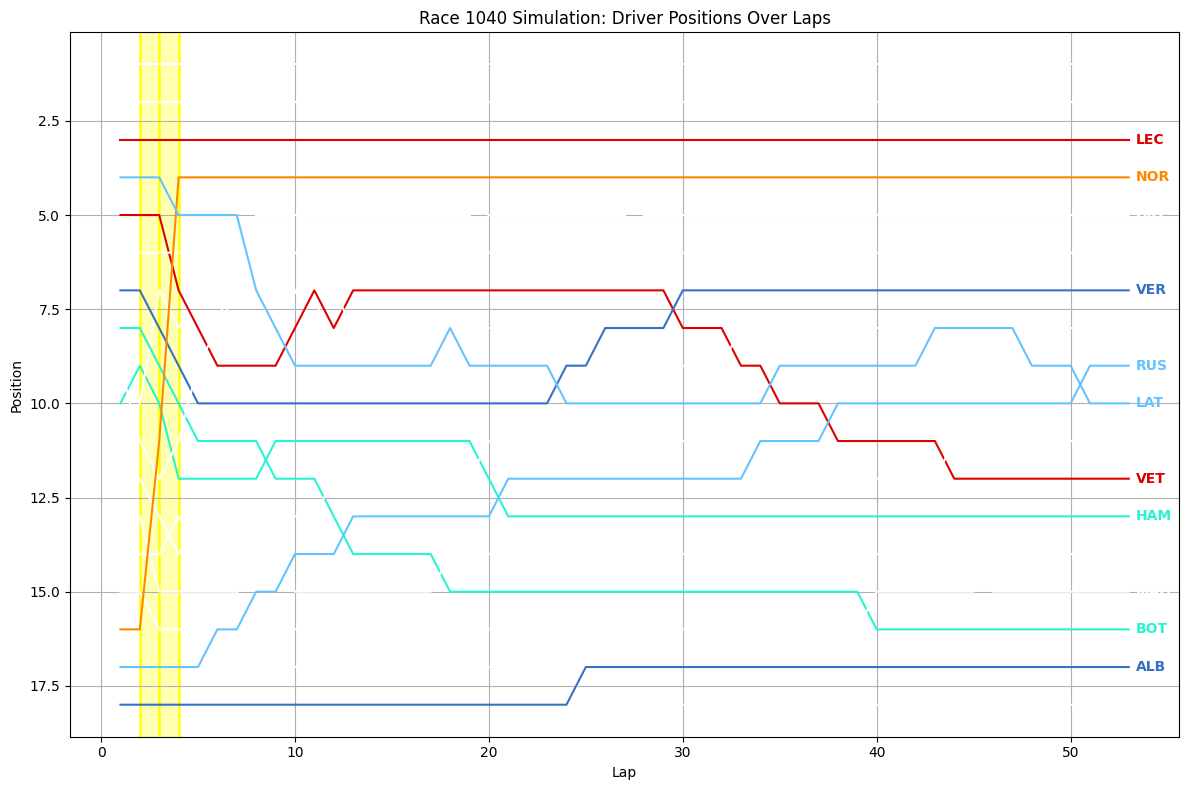

INFO:root:Lap times plot saved to plots/race_1040_times.png


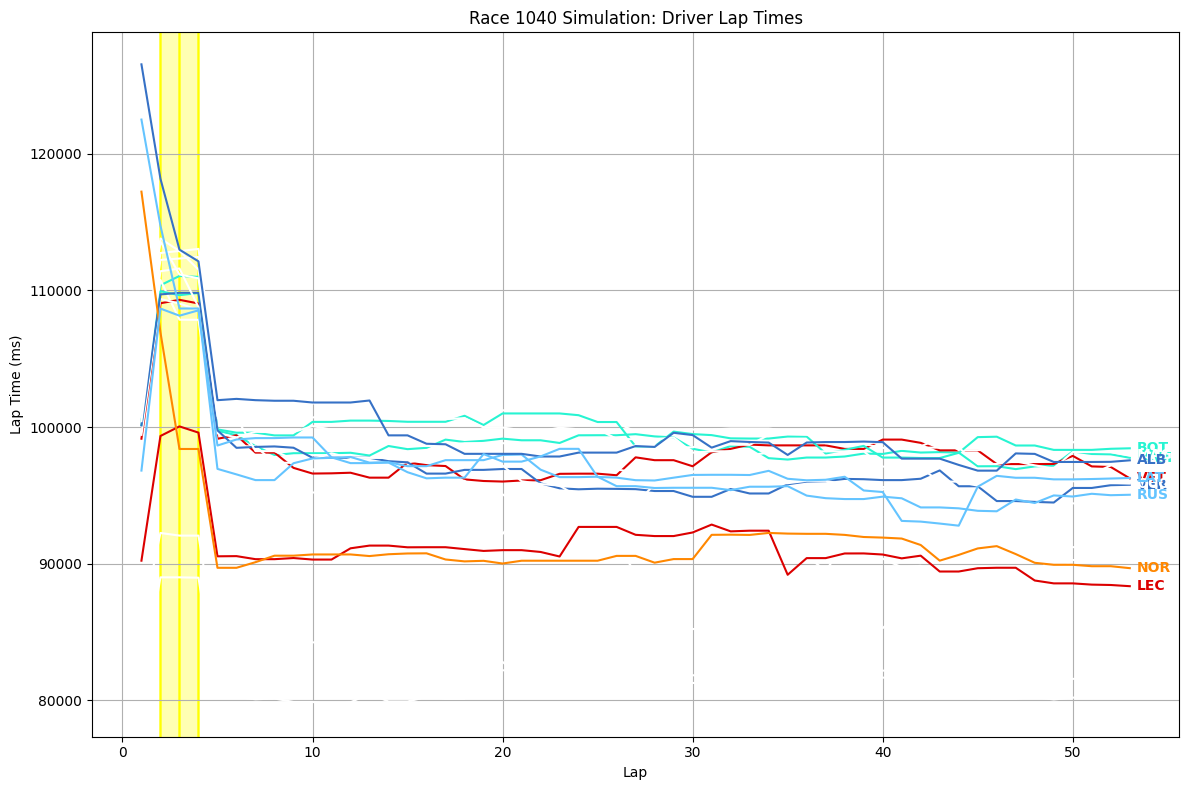

INFO:root:Evaluating race 1057
INFO:root:Initialized 19 drivers for raceId 1057
INFO:root:Simulating lap 1/51
INFO:root:Simulating lap 2/51
INFO:root:Simulating lap 3/51
INFO:root:Simulating lap 4/51
INFO:root:Simulating lap 5/51
INFO:root:Simulating lap 6/51
INFO:root:Simulating lap 7/51
INFO:root:Simulating lap 8/51
INFO:root:Simulating lap 9/51
INFO:root:Simulating lap 10/51
INFO:root:Simulating lap 11/51
INFO:root:Simulating lap 12/51
INFO:root:Simulating lap 13/51
INFO:root:Simulating lap 14/51
INFO:root:Simulating lap 15/51
INFO:root:Simulating lap 16/51
INFO:root:Simulating lap 17/51
INFO:root:Simulating lap 18/51
INFO:root:Simulating lap 19/51
INFO:root:Simulating lap 20/51
INFO:root:Simulating lap 21/51
INFO:root:Simulating lap 22/51
INFO:root:Simulating lap 23/51
INFO:root:Simulating lap 24/51
INFO:root:Simulating lap 25/51
INFO:root:Simulating lap 26/51
INFO:root:Simulating lap 27/51
INFO:root:Simulating lap 28/51
INFO:root:Simulating lap 29/51
INFO:root:Simulating lap 30/51

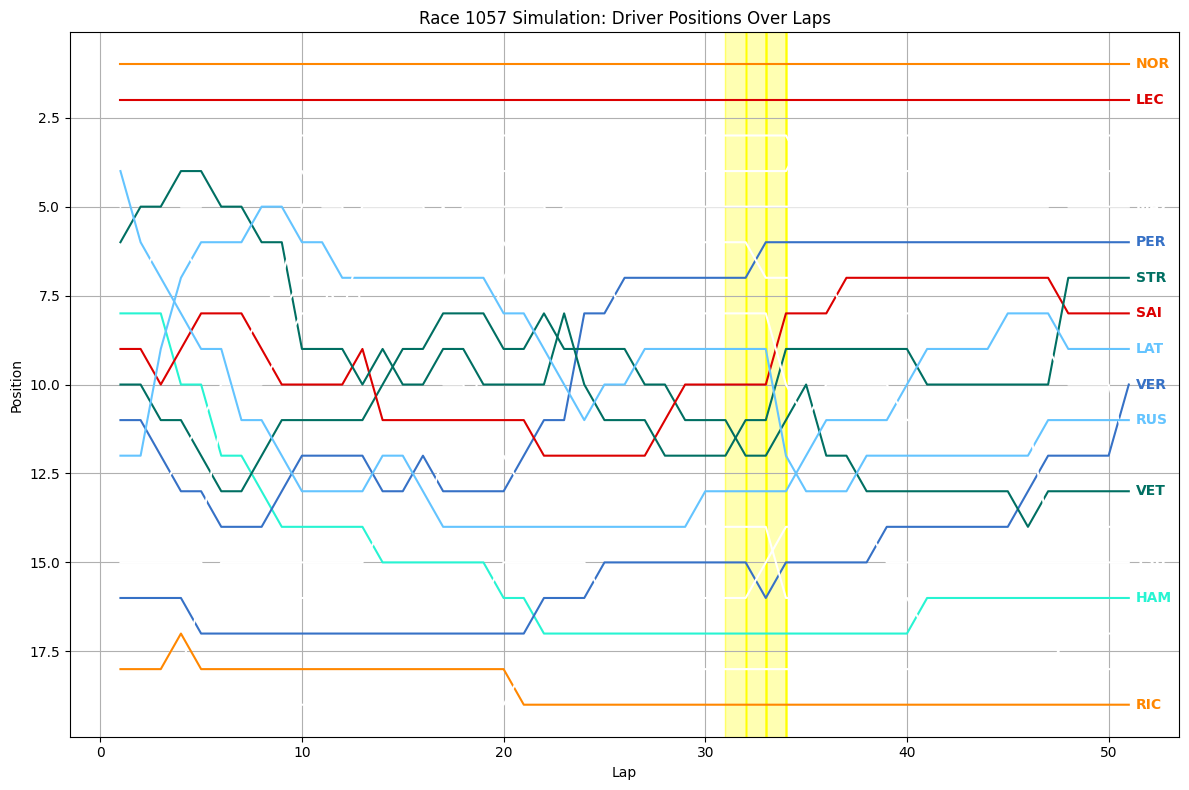

INFO:root:Lap times plot saved to plots/race_1057_times.png


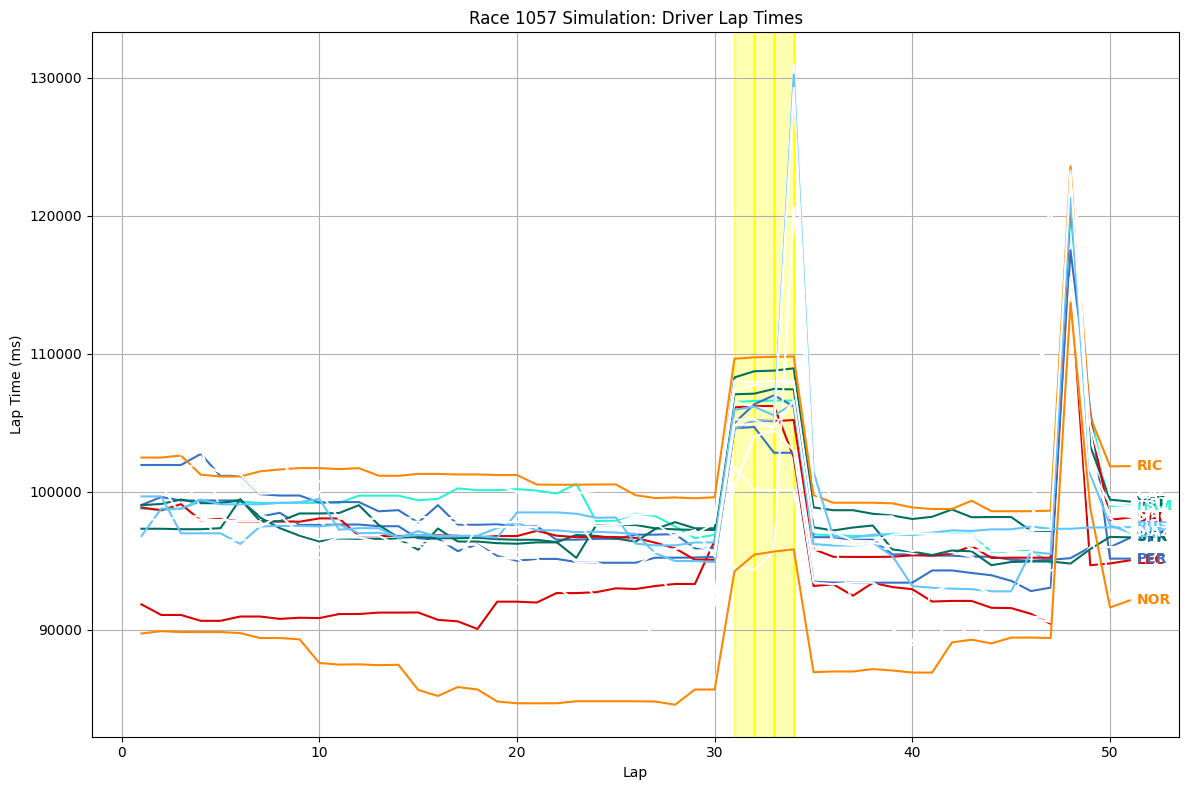

INFO:root:Evaluating race 1115
INFO:root:Initialized 18 drivers for raceId 1115
INFO:root:Simulating lap 1/57
INFO:root:Simulating lap 2/57
INFO:root:Simulating lap 3/57
INFO:root:Simulating lap 4/57
INFO:root:Simulating lap 5/57
INFO:root:Simulating lap 6/57
INFO:root:Simulating lap 7/57
INFO:root:Simulating lap 8/57
INFO:root:Simulating lap 9/57
INFO:root:Simulating lap 10/57
INFO:root:Simulating lap 11/57
INFO:root:Simulating lap 12/57
INFO:root:Simulating lap 13/57
INFO:root:Simulating lap 14/57
INFO:root:Simulating lap 15/57
INFO:root:Simulating lap 16/57
INFO:root:Simulating lap 17/57
INFO:root:Simulating lap 18/57
INFO:root:Simulating lap 19/57
INFO:root:Simulating lap 20/57
INFO:root:Simulating lap 21/57
INFO:root:Simulating lap 22/57
INFO:root:Simulating lap 23/57
INFO:root:Simulating lap 24/57
INFO:root:Simulating lap 25/57
INFO:root:Simulating lap 26/57
INFO:root:Simulating lap 27/57
INFO:root:Simulating lap 28/57
INFO:root:Simulating lap 29/57
INFO:root:Simulating lap 30/57

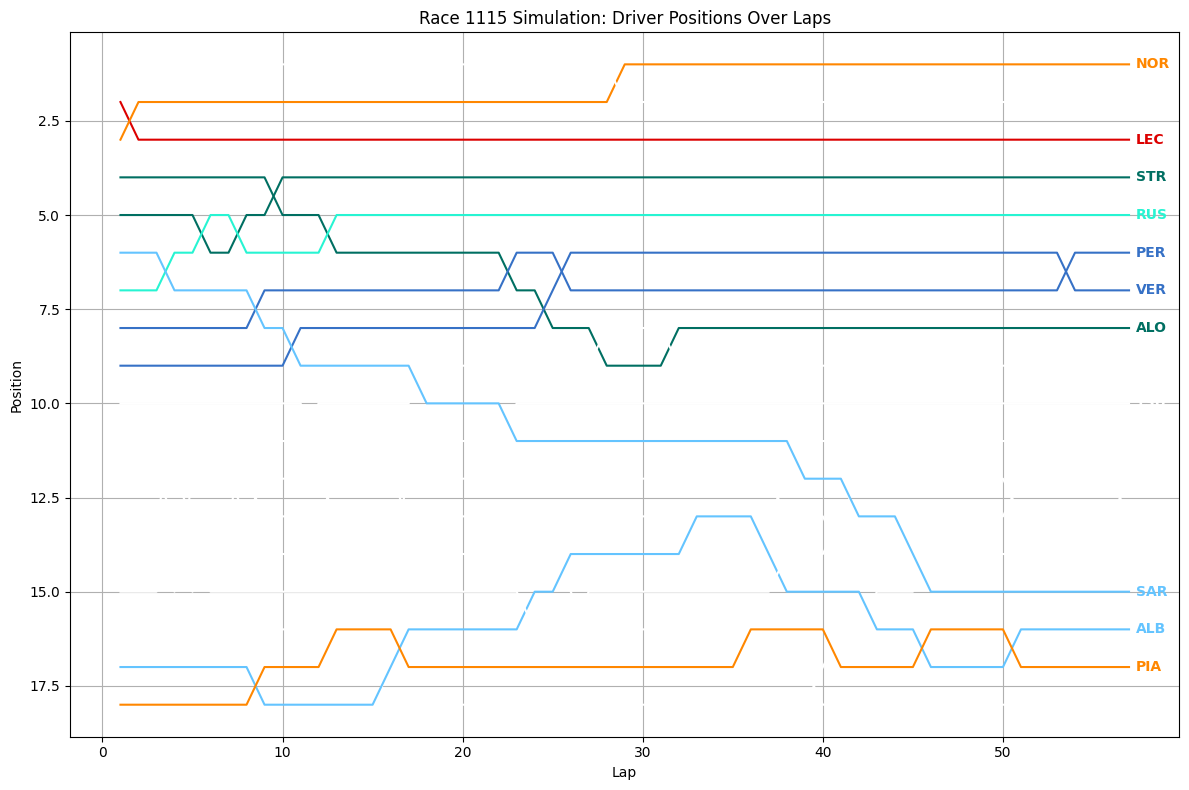

INFO:root:Lap times plot saved to plots/race_1115_times.png


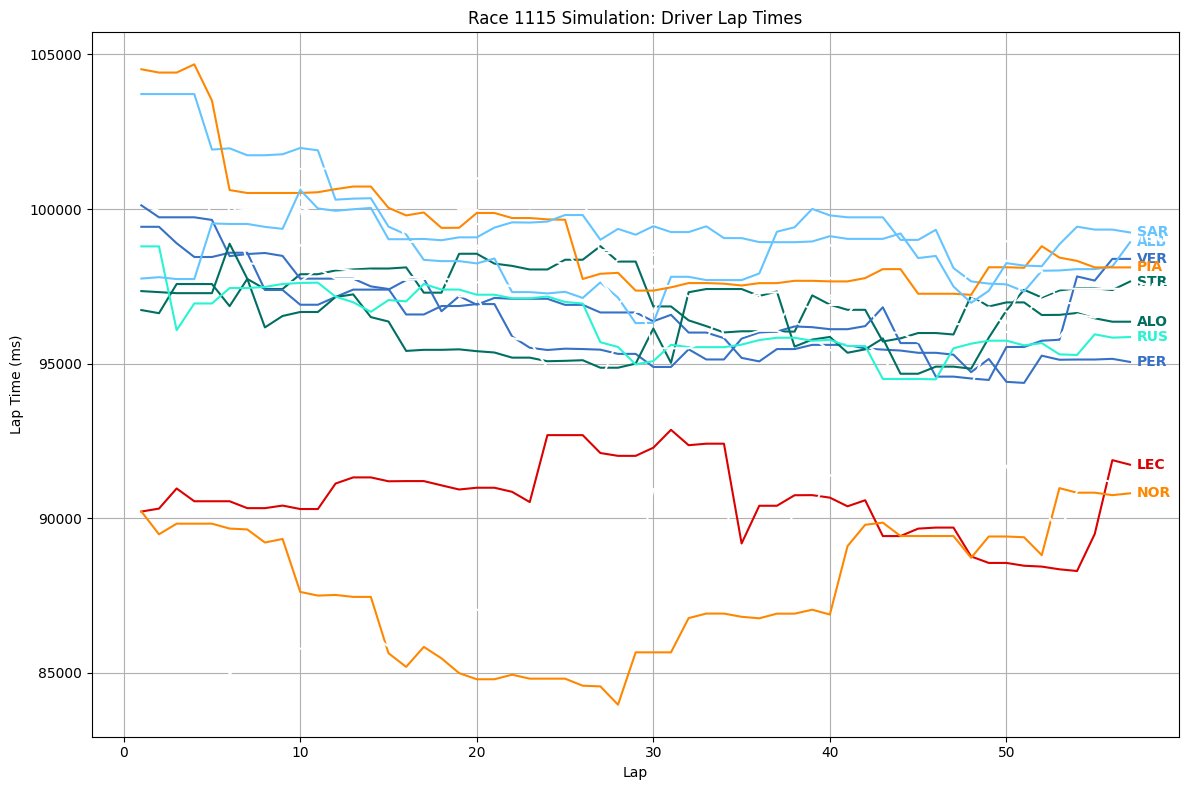

INFO:root:
Overall Results:
INFO:root:
       rmse    mae  positions_correct  position_changes_accuracy  num_drivers
mean  7.089  5.970              0.044                      0.085        900.0
std   1.269  1.209              0.034                      0.189          NaN


In [5]:
from evaluation import evaluate_race_simulation

def evaluate_race_simulation_model(simulator: RaceSimulator, test_df: pd.DataFrame):
    """
    Evaluate race simulation model on test races.
    
    Args:
        simulator: Your race simulator instance
        test_df: Test dataset containing race results
    """
    # Store results for all races
    all_results = []
    
    # Get unique test races
    test_races = test_df['raceId'].unique()
    
    for race_id in test_races:
        try:
            logging.info(f"Evaluating race {race_id}")
            
            # Get race data
            race_data = test_df[test_df['raceId'] == race_id]
            
            # Skip if no data for this race
            if race_data.empty:
                logging.warning(f"No data found for race {race_id}, skipping...")
                continue
                
            if 'circuitId' not in race_data.columns:
                logging.warning(f"No circuit ID found for race {race_id}, skipping...")
                continue
            
            # Get race parameters
            race_length = get_race_length(race_id, lap_times)
            safety_car_periods = extract_safety_car_periods(special_laps, race_id)
            
            # Create race instance
            race = Race(
                race_id=race_id,
                circuit_id=race_data['circuitId'].iloc[0],
                total_laps=race_length,
                weather_conditions={},
                safety_car_periods=safety_car_periods
            )
            
            try:
                # Initialize drivers for this race
                drivers_list, pit_strategies, _ = initialize_drivers(
                    drivers_df, 
                    lap_times, 
                    special_laps, 
                    race
                )
                
                if not drivers_list:
                    logging.warning(f"No drivers initialized for race {race_id}, skipping...")
                    continue
                    
                race.drivers.extend(drivers_list)
                
                # Run simulation
                race_lap_data = simulator.simulate_race(race)
                sim_results = evaluate_race_simulation(race, race_data)
                
                # Add race ID to metrics
                sim_results['metrics']['race_id'] = race_id
                all_results.append(sim_results['metrics'])
                
                # Create results directory if it doesn't exist
                Path('results').mkdir(exist_ok=True)
                Path('plots').mkdir(exist_ok=True)
                
                # Save detailed results for this race
                detailed_df = sim_results['detailed_results']
                detailed_df.to_csv(f'results/race_{race_id}_detailed.csv', index=False)
                
                logging.info(f"\nResults for Race {race_id}:")
                logging.info(f"RMSE: {sim_results['metrics']['rmse']:.2f}")
                logging.info(f"MAE: {sim_results['metrics']['mae']:.2f}")
                logging.info(f"Positions Correct: {sim_results['metrics']['positions_correct']*100:.1f}%")
                
                # Plot race simulation
                try:
                    plot_race_positions(
                        race,
                        drivers_df,
                        constructor_mapping,
                        driver_code_mapping,
                        TEAM_COLORS,
                        save_path=f'plots/race_{race_id}_positions.png'
                    )

                    # Plot and save driver lap times
                    plot_lap_times(
                        race,
                        drivers_df,  # Add this parameter
                        constructor_mapping,
                        driver_code_mapping,
                        TEAM_COLORS,
                        save_path=f'plots/race_{race_id}_times.png'
                    )
                except Exception as e:
                    logging.error(f"Error plotting race {race_id}: {str(e)}")
                    
            except Exception as e:
                logging.error(f"Error simulating race {race_id}: {str(e)}")
                continue
                
        except Exception as e:
            logging.error(f"Error processing race {race_id}: {str(e)}")
            continue
    
    if not all_results:
        logging.error("No successful race simulations completed")
        return None, None
    
    # Create final results DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Calculate aggregate metrics
    overall_metrics = results_df.agg({
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'positions_correct': ['mean', 'std'],
        'position_changes_accuracy': ['mean', 'std'],
        'num_drivers': 'mean'
    }).round(3)
    
    logging.info("\nOverall Results:")
    logging.info(f"\n{overall_metrics}")
    
    # Save overall results
    results_df.to_csv('results/simulation_evaluation.csv', index=False)
    overall_metrics.to_csv('results/simulation_overall_metrics.csv')
    
    return results_df, overall_metrics

# Usage example:
if __name__ == "__main__":
    # Load your train/test split
    train_df, test_df = load_data_splits()
    
    # Initialize simulator (assuming you already have the pipeline loaded)
    simulator = RaceSimulator(pipeline, model_type='xgboost')
    
    # Run evaluation
    results_df, overall_metrics = evaluate_race_simulation_model(simulator, test_df)